In [109]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns

# matplotlib imports
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Sequential
from numpy.random import seed

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [157]:
from IPython.display import Image

## <center><font color='darkred'>COMP47490 Machine Learning Assignment 2 </center></font>
###  <center><font color='darkred'>Dervla Scully 18329511</font></center>

This assignement focuses on ensemble classifiers. Ensemble methods is a machine learning technique that combines several base models in order to produce one optimal predictive model. In this assignment I will construct 3 base classifiers - a decision tree classifier, a k-nearest neighbours classifier, and a neural network classifier. I will first investigate and compare the performance of these base classifiers. Following this I will apply two ensemble techniques - bagging and random subspacing, and compare the results to that of the base classifiers. I will then go on to explore some additional methods, such as Ada Boosting. Finnaly, I will apply parameter tuning to the base classifiers and explore which improves the performace more, the parameter tuning or the ensembles. 

The dataset which is used has been extracted from the US census data. The data contains 14 attributes including age, race, sex, marital status, and the classification goal is to predict whether the individual earns over $50k per year.

I will begin by cleaning the dataset and doing some exploratory data analysis. I will then apply the necessary encoding and normalisation. Following this, I will be ready to construct my classifiers and start the ensemble tasks.

In [2]:
# read in data from csv file to pandas dataframe.  
df = pd.read_csv('data/US_census_18329511.csv',  keep_default_na=True, delimiter=',', skipinitialspace=True)

In [3]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income-category'],
      dtype='object')

## Data Cleaning & Exploratory Data Analysis

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
0,47,Private,162741,Assoc-acdm,12,Married-civ-spouse,Prof-specialty,Wife,Black,Female,15024,0,40,United-States,>50K
1,76,Private,70697,7th-8th,4,Widowed,Other-service,Not-in-family,White,Female,0,0,25,United-States,<=50K
2,36,Private,222584,HS-grad,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
3,28,Private,76313,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,0,0,60,United-States,<=50K
4,33,?,173998,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,1485,38,United-States,<=50K


I immediately notice the '?' for 'workclass' in row 4. This will be important later when identifying missing values.

In [5]:
df.shape

(5000, 15)

There are 5,000 rows, 14 explanatory variables, and 1 target variable.

In [6]:
df["Income-category"].value_counts()

<=50K    3822
>50K     1178
Name: Income-category, dtype: int64

The data is quite unbalanced, with 76% of rows belonging to the target class <=50k, and 23% belonging to the target class >50k. This will be important later when choosing the evaluation metrics.

Before we begin the data cleaning and exploratory data analysis, it is important to have a clear understanding of the meaning of each variable. My understanding of each variable is summarised below. This will be very important for checking the logical integrity of variables, and is good to have an understanding of before deciding how to fill missing values for each variable, how to deal with duplicates, etc.

### Summary of variables: data types and interpretations

| Variable | Data Type | Explanation | 
|--------------------------|-------------|-------------
| age | numeric (int) | Age of the individual | 
| workclass | categorical | Employment class or status, categorizes individuals according to the type of ownership of the employing organization, for example self-employed, works in the private sector, works in government |
| fnlwgt | numeric (int) | The number of people the census believes the entry represents |
| education | categorical (ordinal) | The class of highest education received, e.g. high school, masters, etc. |
| education_num | numeric (int) | The number of years of education received |
| marital-status | categorical | Marital status of an individual. Married-civ-spouse corresponds to a civilian spouse while Married-AF-spouse is a spouse in the Armed Forces. The rest of the values are self explanatory |
| occupation | categorical | The general type of occupation of an individual |
| relationship | categorical | Represents what this individual is relative to others. For example 'Husband' means that the individual is a Husband. Each entry only has one relationship attribute |
| race | categorical | Description of an individual's race | 
| sex | categorical | The biological sex of the individual |
| capital-gain | numeric (int) | Capital gain from the sale of capital property or an investment |
| capital-loss | numeric (int) | Capital loss from the sale of capital property or an invertment |
| hours-per-week | numeric (int) | The number of hours the individual works per week |
| native-country | categorical | The country of origin of the individual |
| Income-category | categorical | The target label - Whether or not an individual makes more than $50,000 a year |

Now I will start by viewing a summary of the dataframe to identify missing values:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              5000 non-null   int64 
 1   workclass        5000 non-null   object
 2   fnlwgt           5000 non-null   int64 
 3   education        5000 non-null   object
 4   education-num    5000 non-null   int64 
 5   marital-status   5000 non-null   object
 6   occupation       5000 non-null   object
 7   relationship     5000 non-null   object
 8   race             5000 non-null   object
 9   sex              5000 non-null   object
 10  capital-gain     5000 non-null   int64 
 11  capital-loss     5000 non-null   int64 
 12  hours-per-week   5000 non-null   int64 
 13  native-country   5000 non-null   object
 14  Income-category  5000 non-null   object
dtypes: int64(6), object(9)
memory usage: 586.1+ KB


#### Check for Missing Values

As seen above, there are 15 variables. The non-null count shows that there are no missing values. However, in the preview of the dataframe above we can see a '?' for workclass on line 4. It is likely that '?' was used to encode missing values. We can set the NaN to be '?' and then check for the number of missing values again for each variable:

In [8]:
df[df == '?'] = np.nan

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              5000 non-null   int64 
 1   workclass        4704 non-null   object
 2   fnlwgt           5000 non-null   int64 
 3   education        5000 non-null   object
 4   education-num    5000 non-null   int64 
 5   marital-status   5000 non-null   object
 6   occupation       4704 non-null   object
 7   relationship     5000 non-null   object
 8   race             5000 non-null   object
 9   sex              5000 non-null   object
 10  capital-gain     5000 non-null   int64 
 11  capital-loss     5000 non-null   int64 
 12  hours-per-week   5000 non-null   int64 
 13  native-country   4902 non-null   object
 14  Income-category  5000 non-null   object
dtypes: int64(6), object(9)
memory usage: 586.1+ KB


Now we see that workclass, occupation and native country contain missing values. Workclass and occupation contain 296 missing values, and native country contains 98 missing values. There are a number of possible ways to deal with these missing values. 

1. Assumpte values are missing at random and that these missing values look like the majority. Replace the missing values with the mode (the most frequent) for that variable. This is simple to implement but could lead to some bias prediction as it distorts the relation of the most frequent label.

2. Replace the missing values with the most occurred values as in (1), but add a new feature to introduce some weight/importance to non-imputed and imputed observations. This is more complicated to implement and interpret, and it adds additional features which as we know from the curese of dimensionality can reduce model accurracy.

3. Create a new category for each variable for missing values. This is simple to implement but can lead to model inaccuracy for unseen data, and is not really any different to just leaving the missing values as '?'.

Due to the fact that there are a relatively small percentage of missing values (296 = 5% for workclass and occupation, 98 = 2% for native country), replacing the mising values with the mode shouldn't distort the relation of the most frequent lable too much or cause serious prediction bias. Thus I will replace each with the mode of that variable:

In [10]:
for col in ['workclass', 'occupation', 'native-country']:
    print("Variable: %s\nMode: %s\n" %(col, df[col].mode()[0]))
    df[col].fillna(df[col].mode()[0], inplace=True)

Variable: workclass
Mode: Private

Variable: occupation
Mode: Craft-repair

Variable: native-country
Mode: United-States



The missing values for workclass were replaced with 'Private', occupation were replaced with 'Craft-repair', and native-country were replaced with 'United-States'.

We can check the number of missing values again to ensure that they are now 0:

In [11]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
Income-category    0
dtype: int64

#### Check for duplicate rows

In [12]:
df.loc[df.duplicated()[df.duplicated()==True].index]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
4935,44,Private,367749,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,Mexico,<=50K


#### Check for constant columns

Next we can check for constant columns by counting the number of unique values for each column.

In [13]:
df.nunique()

age                  68
workclass             7
fnlwgt             4577
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain         82
capital-loss         57
hours-per-week       74
native-country       39
Income-category       2
dtype: int64

All cells have 2 or more values, meaning that there are no constant columns.

__Convert variables to the correct data types__

Later I will be converting categorical data types to numeric, but for now we can check that all variables have the correct data types for their current format.

In [14]:
df.head(4)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
0,47,Private,162741,Assoc-acdm,12,Married-civ-spouse,Prof-specialty,Wife,Black,Female,15024,0,40,United-States,>50K
1,76,Private,70697,7th-8th,4,Widowed,Other-service,Not-in-family,White,Female,0,0,25,United-States,<=50K
2,36,Private,222584,HS-grad,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
3,28,Private,76313,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,0,0,60,United-States,<=50K


In [15]:
# Data types of each feature
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
Income-category    object
dtype: object

From examining the data and the data types above, the variables ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'Income-category'] are categorical, and the remaining variables ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] are all integers.

The integer variables are in the correct format. We can convert the categorical variables to type 'category':

In [16]:
# Select columns containing categorical data
categorical_columns = df[['workclass', 'education', 'marital-status', 
                         'occupation', 'relationship', 'race', 'sex', 'native-country', 
                         'Income-category']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category') 

In [17]:
# Data types of each feature
df.dtypes

age                   int64
workclass          category
fnlwgt                int64
education          category
education-num         int64
marital-status     category
occupation         category
relationship       category
race               category
sex                category
capital-gain          int64
capital-loss          int64
hours-per-week        int64
native-country     category
Income-category    category
dtype: object

### Logical Integrity - Check for Irregular cardinalities & permitted values

Next I will check the logical integrity of the values - i.e. checking if the values make sense. For the categorical colummns I will look at the unique values for each column and check that these make sense in the context and that there are no obvious mistakes, for example we could hasve values 'male', 'female', 'femalr' for the variable 'sex', where 'femalr' is an obvious input spelling mistake. For each categorical variable I will print the value counts and check that the values make sense:

In [18]:
categorical_columns_list = list(categorical_columns)

for column in categorical_columns_list:
    print("*",column, "*") 
    print(df[column].value_counts(), "\n")

* workclass *
Private             3759
Self-emp-not-inc     387
Local-gov            347
State-gov            222
Self-emp-inc         141
Federal-gov          141
Without-pay            3
Name: workclass, dtype: int64 

* education *
HS-grad         1591
Some-college    1115
Bachelors        831
Masters          256
Assoc-voc        210
11th             184
Assoc-acdm       177
10th             159
7th-8th          111
9th               81
Prof-school       74
Doctorate         73
12th              66
5th-6th           37
1st-4th           29
Preschool          6
Name: education, dtype: int64 

* marital-status *
Married-civ-spouse    2289
Never-married         1674
Divorced               655
Separated              183
Widowed                136
Married-spouse-abs      60
Married-AF-spouse        3
Name: marital-status, dtype: int64 

* occupation *
Craft-repair         939
Exec-managerial      641
Prof-specialty       635
Adm-clerical         577
Sales                541
Other-servic

Upon an inspection of the values for the categorical variables, all values seems to make sense and I don't think that there are any obvious mistakes.

In [19]:
df.groupby(["workclass", "Income-category"])['workclass'].count()

workclass         Income-category
Federal-gov       <=50K                90
                  >50K                 51
Local-gov         <=50K               253
                  >50K                 94
Private           <=50K              2973
                  >50K                786
Self-emp-inc      <=50K                57
                  >50K                 84
Self-emp-not-inc  <=50K               282
                  >50K                105
State-gov         <=50K               164
                  >50K                 58
Without-pay       <=50K                 3
                  >50K                  0
Name: workclass, dtype: int64

In [20]:
categorical_columns_list

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'Income-category']

In [21]:
def stackedBarCategorical(x, w=5, l=12):
    cols=categorical_columns_list.copy()
    cols.remove("Income-category")
    
    grouped=df[[cols[x], "Income-category"]].value_counts()
    
    ax = grouped.unstack(level=1).plot.bar(stacked=True, fontsize=10, figsize=(l, w))

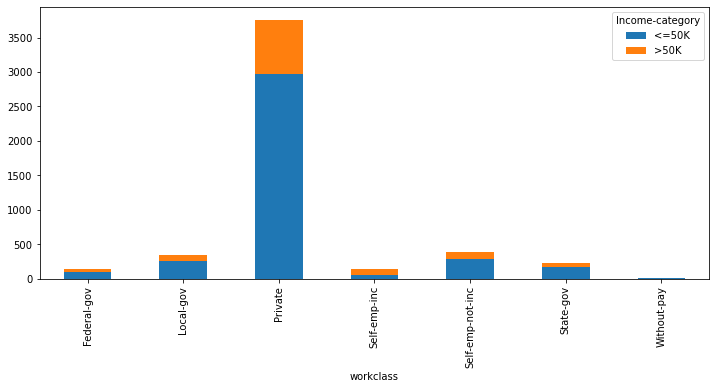

In [22]:
stackedBarCategorical(0)

About 60% of the values are workclass private and income <=50K, and 15% are private and income >50K. All workclass without-pay have income <=50K. For the remaining workclass values, 50%+ are <=50K.

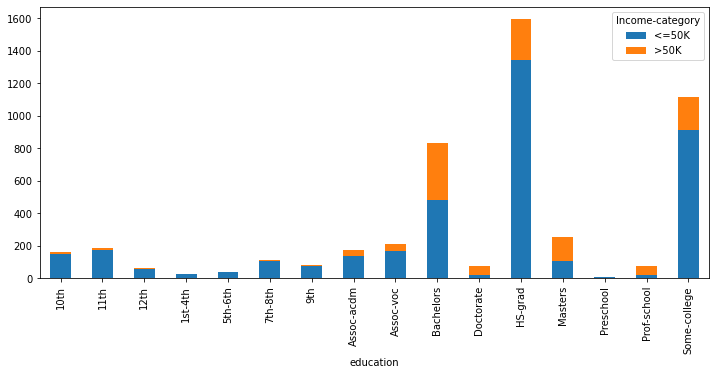

In [23]:
stackedBarCategorical(1)

HS grad has the highest count. About 27% of the data are HS grad with income <= 50K, and 5% are HS grad with income  >50K. About 18% of the data are Some-college with income <= 50K, and 4% are Some-college grad with income  >50K. About 9% of the data are Bachelors with income <= 50K, and 7% are Bachelors grad with income  >50K. Bachelors is one of the only education level without a major difference between the count for <=50K and >50K income. The remainder of the education levels each account for less than 5% of the data. Of the individuals with a highest education Masters, more than 50% of these have an income >50K.

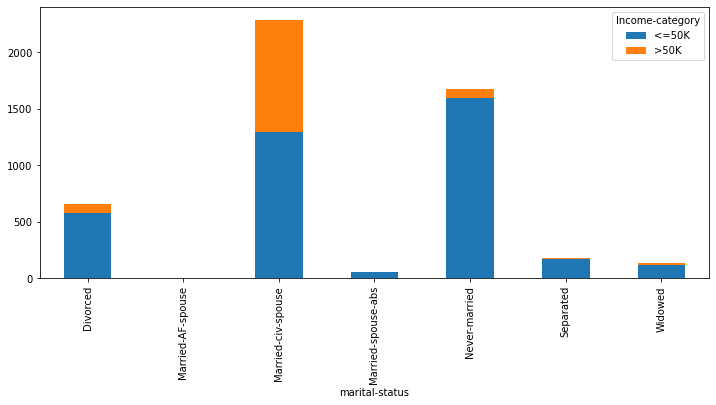

In [24]:
stackedBarCategorical(2)

For marital status, married-civ-spouse (married to a civilian spouse) has the highest count, and just over half of these individuals have an income <=50K, in other words 25% of the total data correspond to those who are married to a civilian and earn <=50K, and 19% are married to a civilian and earn >50K. 31% were never married and earn <=50K, and onyl 1.5% were never married and earn >50K. The rest of the values all make up less than 15% of the data, and all have the majority income <=50K. Married-spose-abs all have income <=50K.

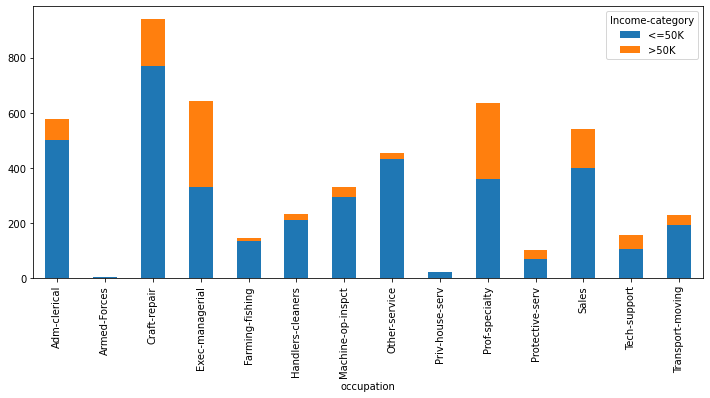

In [25]:
stackedBarCategorical(3)

For occupation, craft-repair has the highest count, about 18%, with about 80% of those having income <=50K. Exec-managerial and prof-speciality have about 50% income >50k and 50% <=50K. The remainder of occupations have income <=50K as the majority.

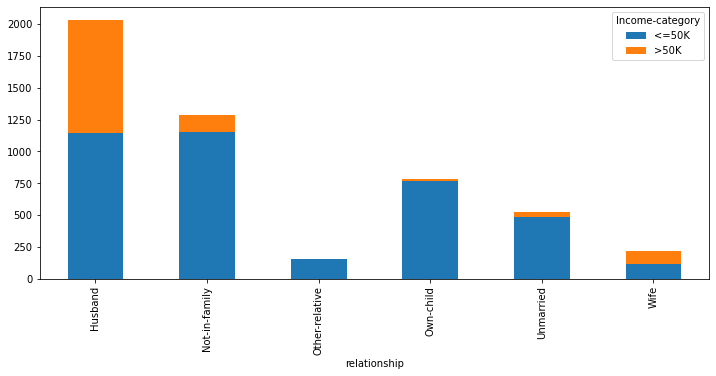

In [26]:
stackedBarCategorical(4)

For relationship, Husbands make up the largest portion of the data, and about 56% of these earn <=50K, and 44% >40K. Wives make up a very small portion of the data, but again the income split is about 50-50. For all other relationship types, income <=50K makes up the majority.

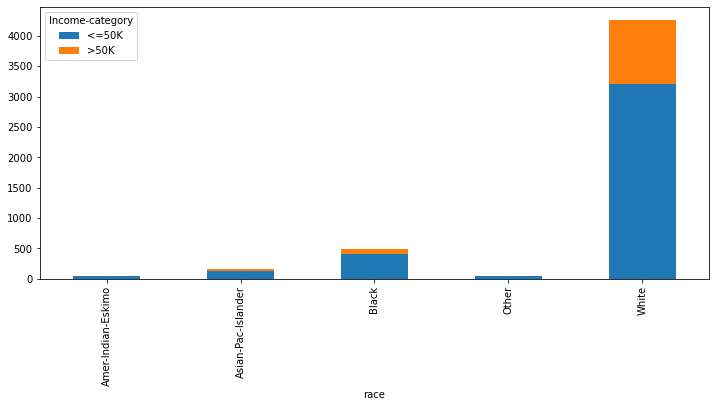

In [27]:
stackedBarCategorical(5)

About 85% of the data corresponds to the White race. Of these, around 76% earn <=50K. Races Amer-Indian-Eskimo and Other all earn <=50K, and a very small portion of Asian-Pac-Islander and Black earn >50K.

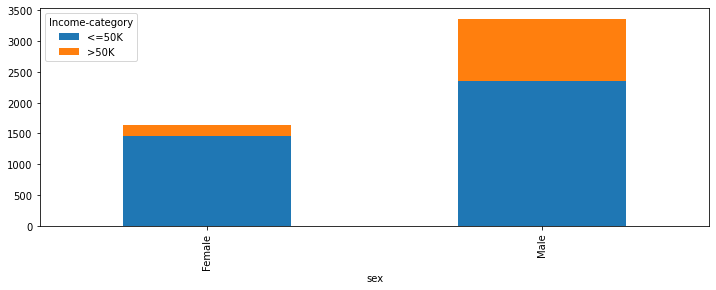

In [28]:
stackedBarCategorical(6, w=4)

About 67% of the data corresponds to men, and the remaining 33% women. 30% of the men earn >50K, while only 10% of the women do.

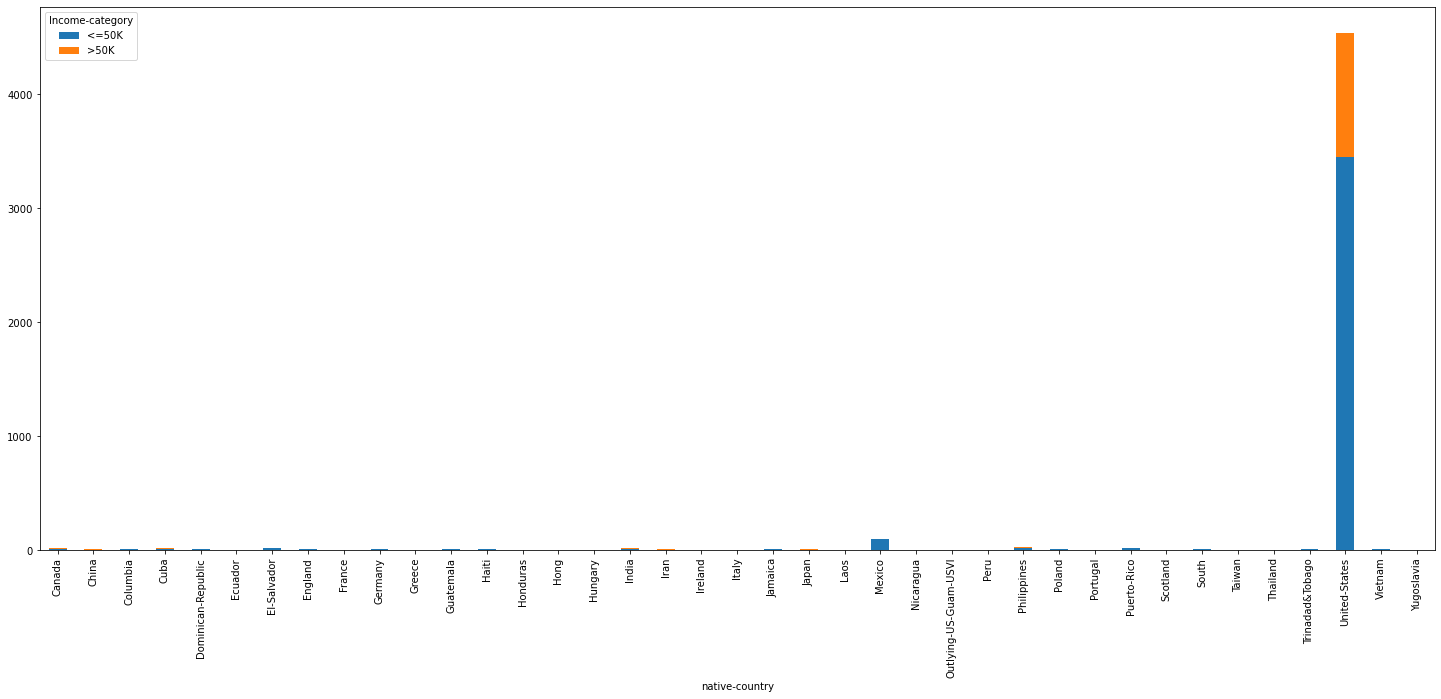

In [29]:
stackedBarCategorical(7, 10, 25)

The Unite-States make up 88% of the data, and have 77% with income <= 50K, 23% income >50K.

Next we can explore the numeric variables. I will start by checking the range for each variable. If there are any major outliers which are a mistake this should be obvious from the range, for example an age range of 17 - 800 would immediantely indicate a mistake as 800 is not a possible age for this real data, or a negative age value would indicate an obvious mistake. 

Following this, visual analysis will provide further insight. 

I will print the range for each numeric variable below:

In [30]:
numeric_columns_list = list(set(df.columns) - set(categorical_columns))
print(numeric_columns_list)

['hours-per-week', 'capital-gain', 'age', 'fnlwgt', 'capital-loss', 'education-num']


In [31]:
for column in numeric_columns_list:
    print("*",column, "*") 
    print("Num Unqiue Values:",df[column].nunique())
    print("Value Range: %d - %d\n" %(df[column].min(),df[column].max()))

* hours-per-week *
Num Unqiue Values: 74
Value Range: 1 - 99

* capital-gain *
Num Unqiue Values: 82
Value Range: 0 - 99999

* age *
Num Unqiue Values: 68
Value Range: 17 - 90

* fnlwgt *
Num Unqiue Values: 4577
Value Range: 19302 - 1226583

* capital-loss *
Num Unqiue Values: 57
Value Range: 0 - 4356

* education-num *
Num Unqiue Values: 16
Value Range: 1 - 16



Upon inspection of the ranges, the range seems to make sense for age and education-num. I am not familiar with the figures one would expect for capital loss and gain and for the fnlwgt, so I will leave this for now and explore these in more detail later with some graphs. 

The max value for hours-per-week variable (the typical number of hours worked per week) is quite high at 99 hours. The average numnber of working hours per week globally is about 35 hours according to this resource: https://everhour.com/blog/average-working-hours/ so it is necessary to explore this variable in more detail to ensure this isn't a mistake:

In [32]:
df["hours-per-week"].value_counts().sort_index(ascending=False).head(10)

99    15
98     1
91     1
90     7
86     1
85     1
84     9
81     1
80    18
77     1
Name: hours-per-week, dtype: int64

Upon inspection it seems that the high value for the max working hours per week is not a mistake, as there are numerous similar values. It seems that a significant number of people in the dataset work approx double the average number of working hours per week.

Interestingly we can see below that of the 15 people who work the max number of hours of 99, 86% of these are originally from the United States, and 86% earn less than or equal to 50k. Logically one would assume that working much more hours a week would lead to a much higher income, but it is possible that these are low income individuals working long hours in low-paid jobs, or even wokring multiple low income jobs. 

This might indicate that hours-per-week is a strong variable for predicting the target, Income category, but we will discuss this more later. 

In [33]:
df[["hours-per-week", "native-country", "Income-category"]].sort_values(
    by="hours-per-week", ascending=False).head(15)

,hours-per-week,native-country,Income-category
27,99,United-States,<=50K
3631,99,United-States,<=50K
3590,99,United-States,<=50K
3555,99,United-States,>50K
3862,99,United-States,<=50K
819,99,United-States,<=50K
784,99,United-States,>50K
1949,99,United-States,<=50K
661,99,United-States,<=50K
2961,99,England,<=50K


In [34]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income-category'],
      dtype='object')

We can also make sure that the number of years of education and education level make sense together. For example, an individual with a master's degree and only 1 year of education would not make sense, or a preschooler with 10 years of education would not make sense.

We can check the value counts for the years of education corresponding to each education level:

In [35]:
list(df["education"].unique())

['Assoc-acdm',
 '7th-8th',
 'HS-grad',
 'Some-college',
 'Bachelors',
 'Assoc-voc',
 '10th',
 'Masters',
 '11th',
 'Doctorate',
 '12th',
 '9th',
 'Prof-school',
 '1st-4th',
 '5th-6th',
 'Preschool']

In [36]:
education_ordered = ['Preschool', '1st-4th', '5th-6th', 
                     '7th-8th', '9th', '10th', '11th', '12th','HS-grad',
                     'Prof-school','Assoc-acdm','Assoc-voc',
                     'Some-college','Bachelors','Masters','Doctorate']

In [37]:
print("Years of education, count:\n")
for edu in education_ordered:
    print("*%s*"%edu)
    print(df["education-num"][df["education"]==edu].value_counts(), "\n")

Years of education, count:

*Preschool*
1    6
Name: education-num, dtype: int64 

*1st-4th*
2    29
Name: education-num, dtype: int64 

*5th-6th*
3    37
Name: education-num, dtype: int64 

*7th-8th*
4    111
Name: education-num, dtype: int64 

*9th*
5    81
Name: education-num, dtype: int64 

*10th*
6    159
Name: education-num, dtype: int64 

*11th*
7    184
Name: education-num, dtype: int64 

*12th*
8    66
Name: education-num, dtype: int64 

*HS-grad*
9    1591
Name: education-num, dtype: int64 

*Prof-school*
15    74
Name: education-num, dtype: int64 

*Assoc-acdm*
12    177
Name: education-num, dtype: int64 

*Assoc-voc*
11    210
Name: education-num, dtype: int64 

*Some-college*
10    1115
Name: education-num, dtype: int64 

*Bachelors*
13    831
Name: education-num, dtype: int64 

*Masters*
14    256
Name: education-num, dtype: int64 

*Doctorate*
16    73
Name: education-num, dtype: int64 



Upon examining the number of years of education for each education level the values seem to make sense. I would have expected 5 or 6 years of education for "5th-6th" and so on for "7th-8th", "9th", "10th" and maybe some variation for individuals who skipped grades or were held back, however the actual years are 3 years for "5th-6th", 4 for "7th-8th", 5 for "9th", 6 for "10th", with only the 1 unique number of years for each, so this must be correct. I have immediately noticed that for every single education level there is only 1 unique value for years of education, the number of years of education is different for each education level, and the number of years increases in the same order as the ordered levels of education with the exception of "Prof-school" (assuming my understanding of the right ordering is correct). This means that we should be able to drop one of these columns later with little loss of information as they are highly correlated. I will discuss this more later. 

In [38]:
params = {'axes.titlesize':'20',
          'xtick.labelsize':'16',
          'ytick.labelsize':'16'}
matplotlib.rcParams.update(params)

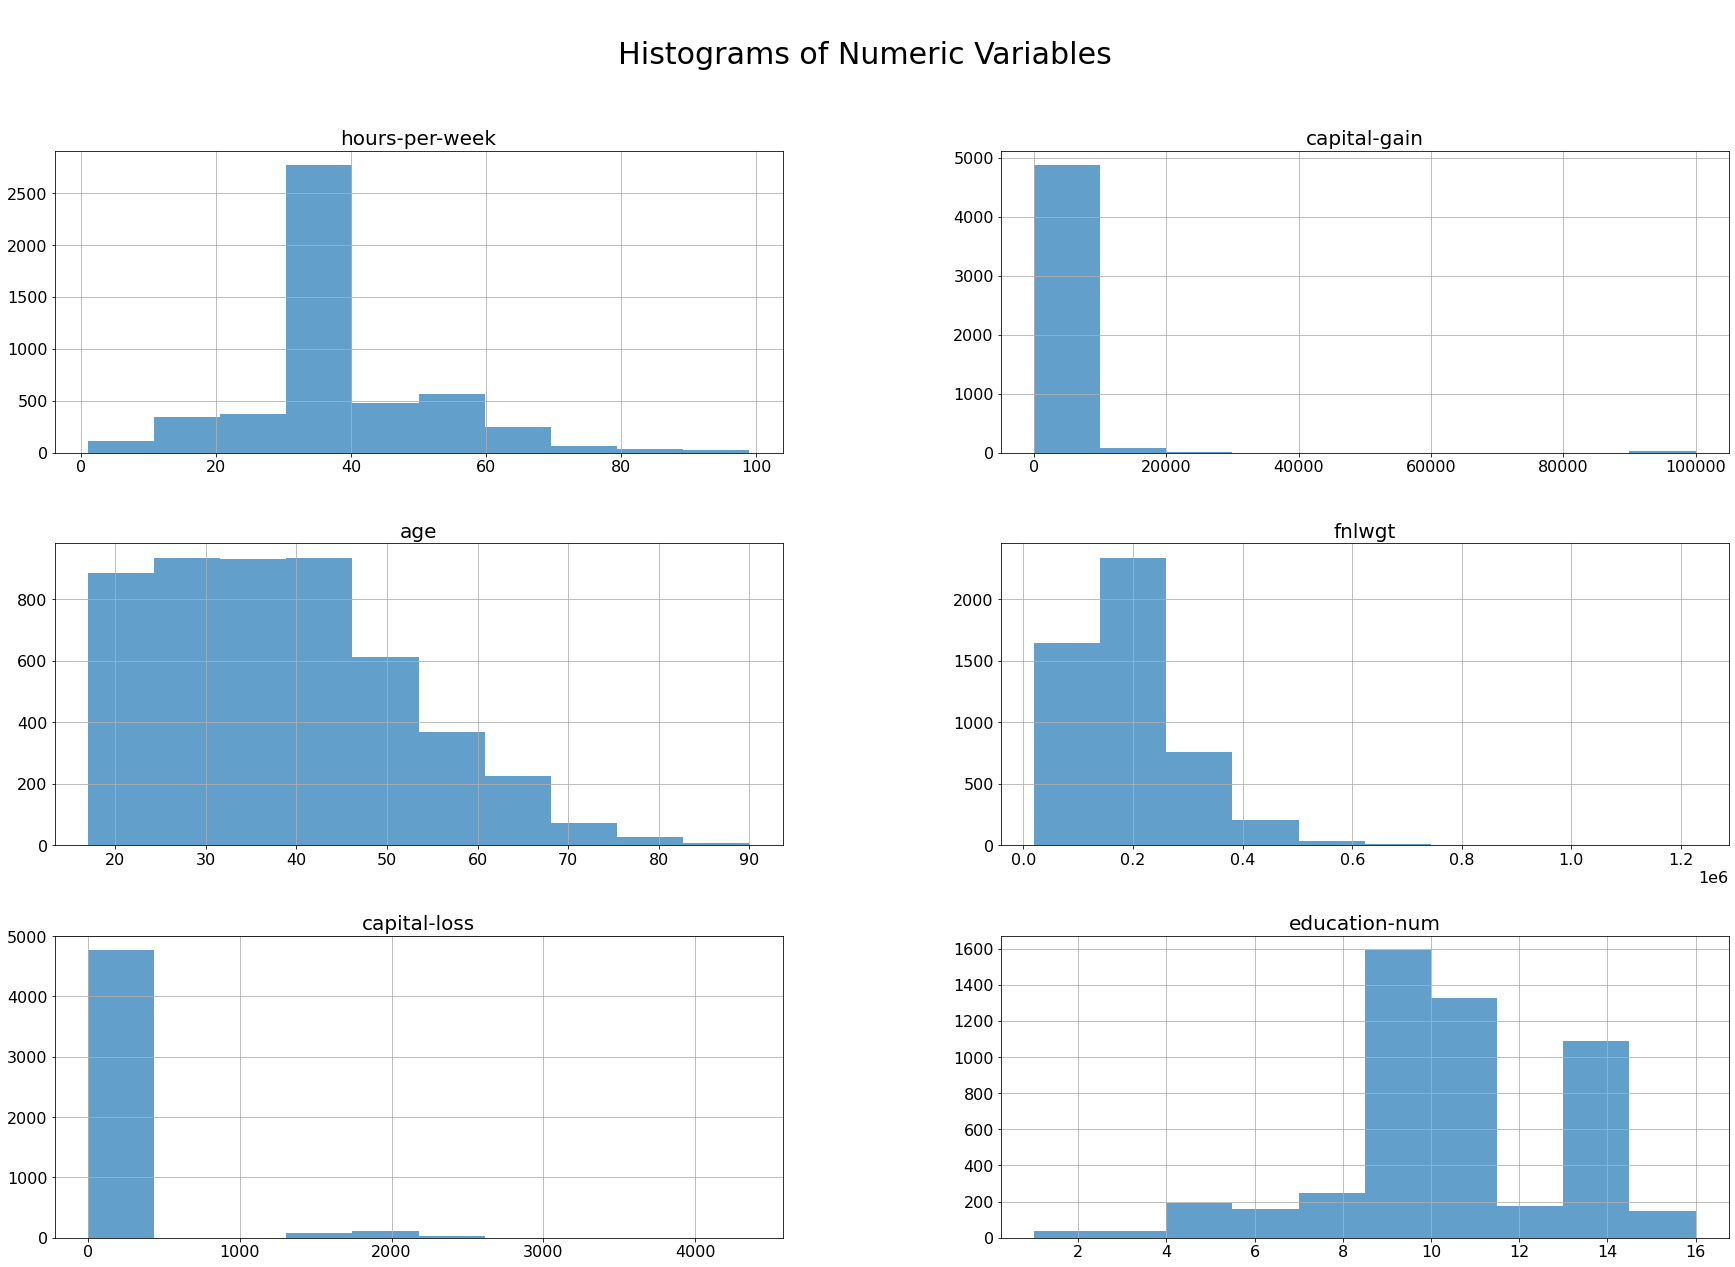

In [39]:
# Plot a histogram summary sheet of the continuous features and save in a png file
axes=df[numeric_columns_list].hist(layout=(3, 2), 
                              figsize=(30,20), 
                              alpha=0.7,
                              bins=10);
pl.suptitle("\nHistograms of Numeric Variables", fontsize=30)
pl.show()

I can immediately see that there are large skews and outliers for capital-loss, capital-gain and fnlwgt. I will come back to these.

__Age__:

Age is positively skewed. Approx 70% of ages are between 17 and 45. From here we can see a steady decline in the count as the ages increase, the highest being 90.

__Education-num__:

The number of years of edcucation is bimodal with a negative skew. There is a peak at 9-10 and 10-12. This would indicate people whos highest level of education was graduating highschool / going to some college. There is also a skew around 13-15, which would account for people who got a bachelors/masters degree. There are a very small number of occurrences of years of education below 8, which is not unexpected is it would not be the norm in most countries to drop out in the early years of school.

__Hours-per-week__:

The distribution for hours-per-week is approx bell shaped but with a very large peak, in other words there is a large peak and approx symmetric skews in either direction (slighly more positive skew but not a huge difference). As expecetd there is a very large peak at around 30-40 hours. As mentioned earlier, I researched the average global working week and it was 35, so a high peak here is expected. This accounts for about 70% of the data. About 12% work from 0-30 hours, and 28% work between 40 and 100 hours.

Another way to visualise these distributions is with boxplots:

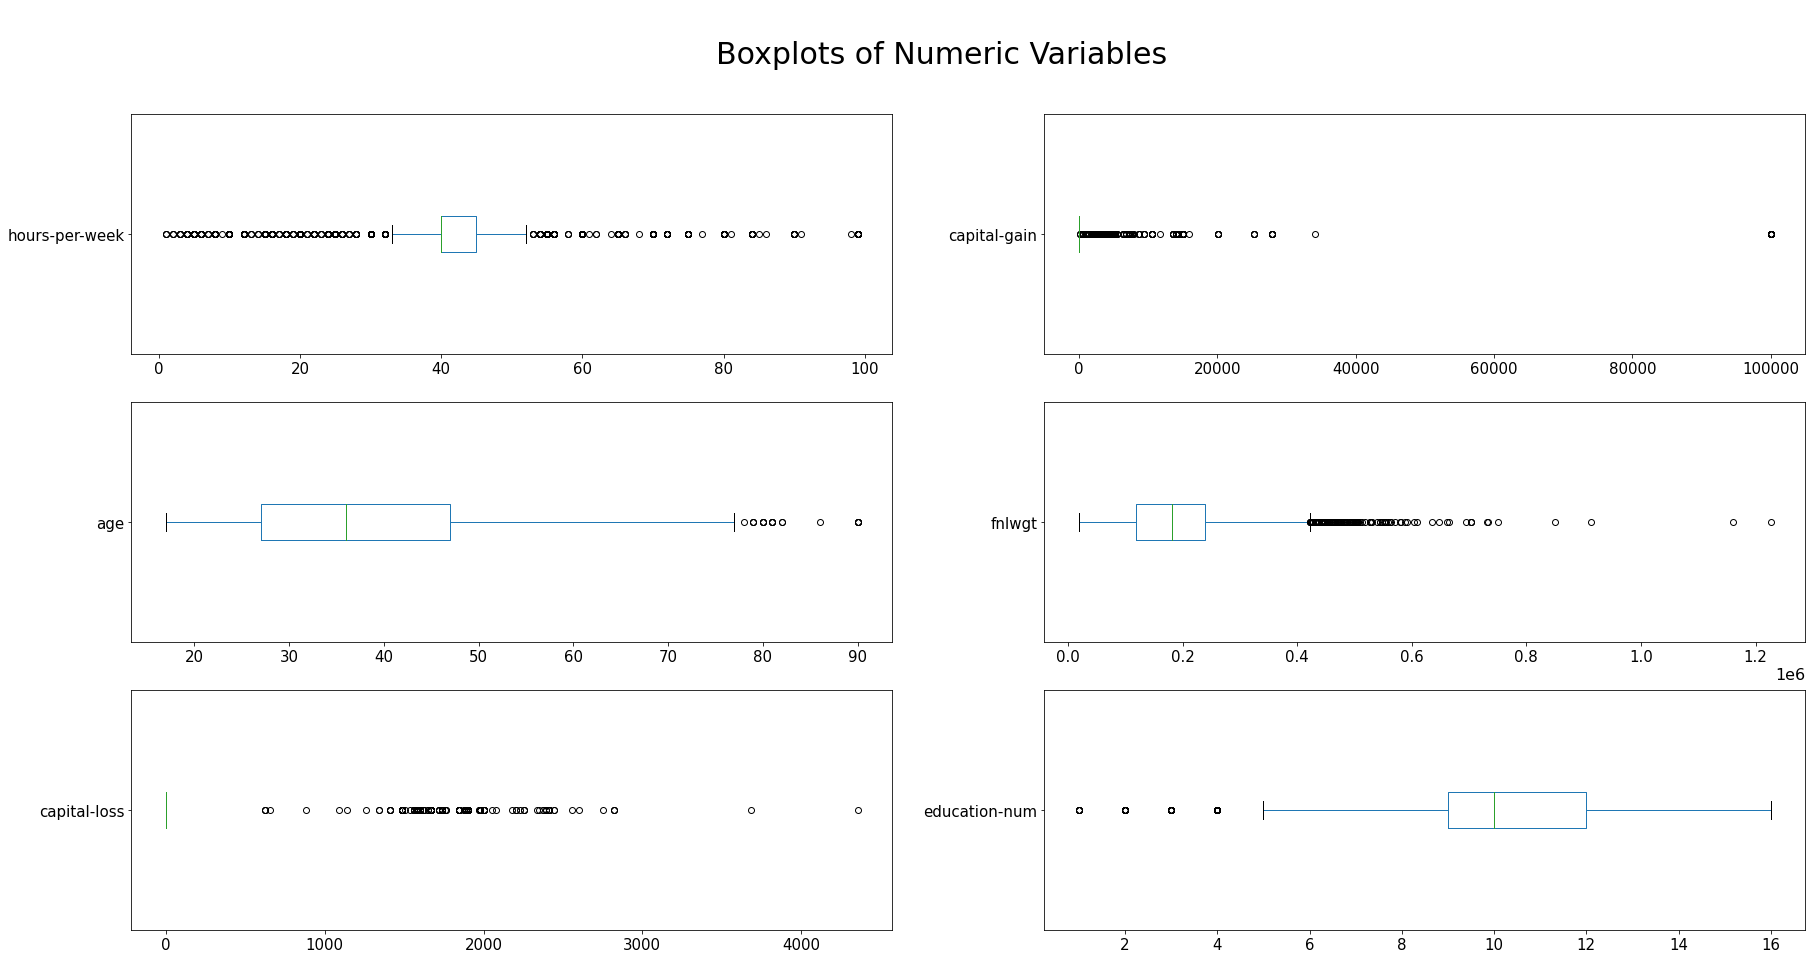

In [40]:
axes=df[numeric_columns_list].plot(kind='box', 
                              subplots=True, 
                              figsize=(30,15), 
                              layout=(3,2), 
                              sharex=False, 
                              sharey=False, 
                              fontsize=15, 
                              vert=False);

pl.suptitle("\nBoxplots of Numeric Variables", fontsize=30)
pl.show()

Again we can see large outliers for capital-loss, capital-gain and fnlwgt. Hours per week has approx symmetric large and small outliers, and we can see that the median is equal to the lower quartile. 75% of the data are between about 30 and 45. The mea  ge is 35, 75% of the ages are between 17 and 77, and there are a number of outliers between 77 and 90. There are few small outliers for education-num, and the median is 10 years if education. 75% of the values are between 5 and 16.

We can now take a closer look at the outliers for capital-gain:

In [41]:
df['capital-gain'][df['capital-gain']>40000].value_counts()

99999    31
Name: capital-gain, dtype: int64

In [42]:
df['capital-gain'][(df['capital-gain']>40000) & (df['Income-category']=='>50K')].value_counts()

99999    31
Name: capital-gain, dtype: int64

In [43]:
df[['capital-gain','Income-category']][df['capital-gain']>40000]

,capital-gain,Income-category
69,99999,>50K
483,99999,>50K
544,99999,>50K
559,99999,>50K
632,99999,>50K
664,99999,>50K
995,99999,>50K
1098,99999,>50K
1156,99999,>50K
1299,99999,>50K


We can see from the histogram that around 99% of the values for capital-gain are below 40,000. The above shows that the 31 values which are above this are all 99,9999. Due to the large number of values it is unlikely that this is a mistake. We can see that all of these high capital-gain values correspond to an income of >50K. Thus I will leave these values as they are.

Next we can check capital-loss:

In [44]:
df[['capital-loss','Income-category']][df['capital-loss']>1000].sort_values(by="capital-loss",ascending=False)

,capital-loss,Income-category
1261,4356,<=50K
1687,3683,<=50K
4052,2824,>50K
4478,2824,>50K
852,2824,>50K
...,...,...
1941,1340,<=50K
835,1340,<=50K
3085,1258,<=50K
331,1138,<=50K


There are 231 (4%) values of capital loss greater than 1,000. None of this values seem to be an obvious mistake. The largest capital loss is 4356 which seems reasonable. Thus I don't think that these are a mistake either.

We can also plot overlapping histograms of the numeric variables for each class. I will briefly comment on each histogram, but am not going to go into major detail as this is not necessary for the assignment.

In [45]:
def histogramNumericByIncome(column):
    colors = ["lightseagreen", "cornflowerblue"]
    incomes = ["<=50K", ">50K"]
    plt.figure(figsize=(10, 5))
    
    for i in range(0, 2):
        data = df[column][df["Income-category"]==incomes[i]]
            # create histogram
        _, bins, _ = plt.hist(data, 
                                bins=10, 
                                alpha=0.5,
                                color=colors[i], 
                                label=incomes[i],
                                density=2)
            
    # Grid lines
    plt.grid(b=True, 
             which='major', 
             color='#666666', 
             linestyle='-',
             alpha=0.1)
    
    plt.minorticks_on()
    
    plt.grid(b=True, 
             which='minor', 
             color='#999999', 
             linestyle='-', 
             alpha=0.07)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    plt.xlabel(column,size=12)

    # add legend
    plt.legend(loc='upper right')
    
    # show
    plt.show()

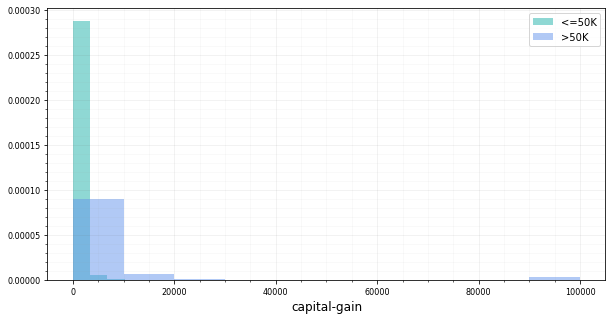

In [46]:
histogramNumericByIncome(numeric_columns_list[1])

We can see that individuals with higher capital gain tend to have a higher income (blue). Capital is likely a fairly good predictor of income.

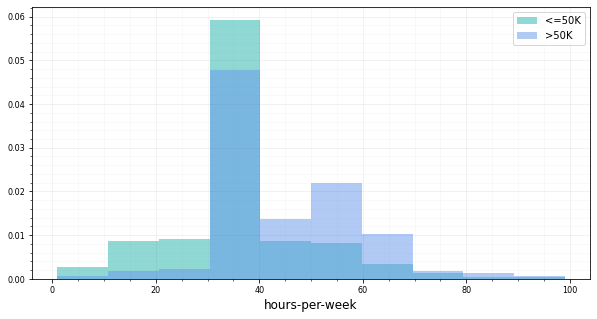

In [47]:
histogramNumericByIncome(numeric_columns_list[0])

The distribution if fairly similar for the two income classes in terms of work hours, however more lower income individuals work less hours (0-30) and more higher income work 40-80 hours. The amount that work 70-100 hours is about the same for each class.

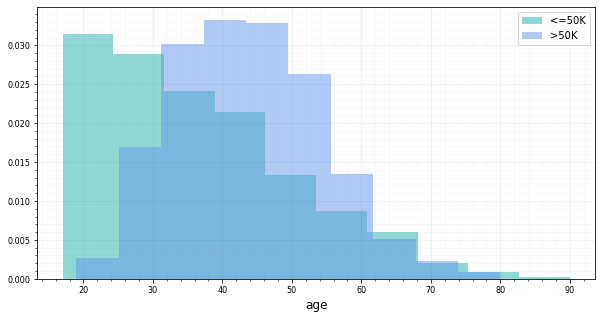

In [48]:
histogramNumericByIncome(numeric_columns_list[2])

Higher income earners in the dataset tend to be older. Age is likely a good predictor of income.

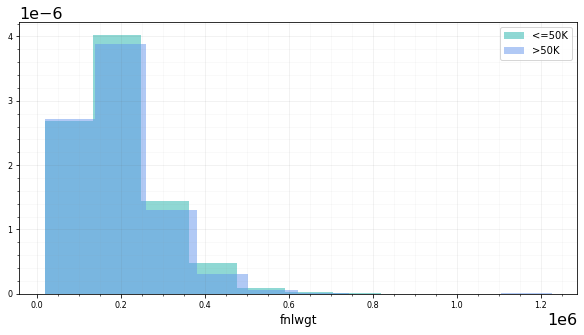

In [49]:
histogramNumericByIncome(numeric_columns_list[3])

The distribution for fnlwgt is almost the exact same for each class, so this is likely not a great predictor of income.

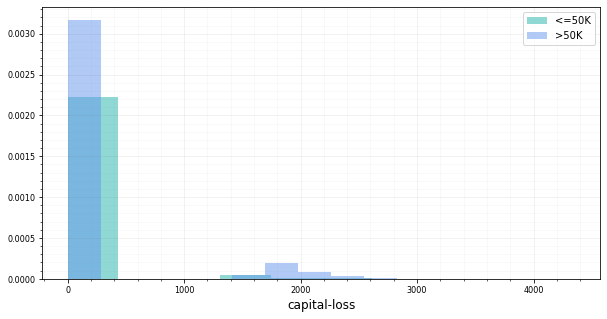

In [50]:
histogramNumericByIncome(numeric_columns_list[4])

It is dissicult to see which classes have the very high capital loss in the above diagram, however more higher income individuals have a lower capital loss.

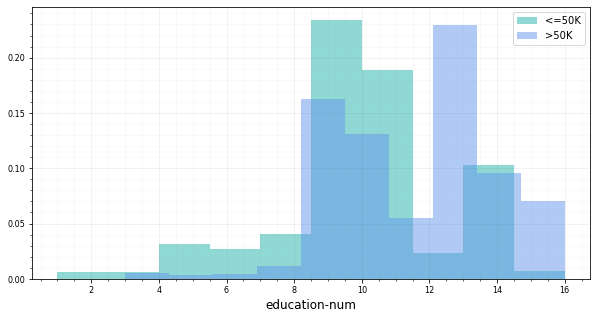

In [51]:
histogramNumericByIncome(numeric_columns_list[5])

We can clearly see that individuals with more years of education tend to have a higher income. This is likely a good predictor of income.

After a thorough analysis of the values for the numeric and categorical values I did not find any issues. 

This completes the data cleaning and EDA. The only change made to the data was the handling of the missing values. 

#### Summary of Data Preperation Issues and Solutions
| Issues | Solution Method | 
|--------------------------|-------------|
| Missing values (encoded with '?') in columns workclass, occupation, native-country | Replaced each missing value with the mode of the column          | 

I can now move on to the feature encoding and normalisation.

## Encoding and Normalisation

This section will be divided into the following sub-sections:

1. Encoding Categorical - Ordinal features

2. Encoding Categorical - Non-Ordinal features

3. Train/Test Split

4. Normalising Numeric Features

#### Encoding Features

To encode the features we can take a look again at the feature data types table, as numeric, ordinal and categorical variables will all be encoded differently:

#### Summary of variables: data types and interpretations

| Variable | Data Type | Explanation | 
|--------------------------|-------------|-------------
| age | numeric (int) | Age of the individual | 
| workclass | categorical | Employment class or status, categorizes individuals according to the type of ownership of the employing organization, for example self-employed, works in the private sector, works in government |
| fnlwgt | numeric (int) | The number of people the census believes the entry represents |
| education | categorical (ordinal) | The class of highest education received, e.g. high school, masters, etc. |
| education_num | numeric (int) | The number of years of education received |
| marital-status | categorical | Marital status of an individual. Married-civ-spouse corresponds to a civilian spouse while Married-AF-spouse is a spouse in the Armed Forces. The rest of the values are self explanatory |
| occupation | categorical | The general type of occupation of an individual |
| relationship | categorical | Represents what this individual is relative to others. For example 'Husband' means that the individual is a Husband. Each entry only has one relationship attribute |
| race | categorical | Description of an individual's race | 
| sex | categorical | The biological sex of the individual |
| capital-gain | numeric (int) | Capital gain from the sale of capital property or an investment |
| capital-loss | numeric (int) | Capital loss from the sale of capital property or an invertment |
| hours-per-week | numeric (int) | The number of hours the individual works per week |
| native-country | categorical | The country of origin of the individual |
| Income-category | categorical | The target label - Whether or not an individual makes more than $50,000 a year |

### Encoding Ordinal Features

Education is the only feature which I have identified as ordinal based on my understandng of the feature interpretations.

I have already created list of the values for Education in order. I can use this to create an OrdinalEncoder for this feature.

In [52]:
ordinal_encoder = OrdinalEncoder(categories=[education_ordered])
education_encoded = ordinal_encoder.fit_transform(df[['education']])
education_encoded = pd.Series(education_encoded.flatten(), name="education")

print("Encoding:")
for i in range(0, len(ordinal_encoder.categories_[0])):
    print(np.sort(education_encoded.unique())[i], ":", ordinal_encoder.categories_[0][i])

Encoding:
0.0 : Preschool
1.0 : 1st-4th
2.0 : 5th-6th
3.0 : 7th-8th
4.0 : 9th
5.0 : 10th
6.0 : 11th
7.0 : 12th
8.0 : HS-grad
9.0 : Prof-school
10.0 : Assoc-acdm
11.0 : Assoc-voc
12.0 : Some-college
13.0 : Bachelors
14.0 : Masters
15.0 : Doctorate


We can now replace the original Education feature with this new encoded feature:

In [53]:
df.drop(columns="education", inplace=True)
df["education"]=education_encoded
df.head(3)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category,education
0,47,Private,162741,12,Married-civ-spouse,Prof-specialty,Wife,Black,Female,15024,0,40,United-States,>50K,10.0
1,76,Private,70697,4,Widowed,Other-service,Not-in-family,White,Female,0,0,25,United-States,<=50K,3.0
2,36,Private,222584,9,Divorced,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K,8.0


#### Encoding Categorical Features:

The categorical columns are displayed below. These may be handelled differently depending on the number of unique values.

In [54]:
categorical_columns_list.remove("education")
categorical_columns_list

['workclass',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'Income-category']

In [55]:
for col in categorical_columns_list:
    print(col, ":", len(df[col].unique()))

workclass : 7
marital-status : 7
occupation : 14
relationship : 6
race : 5
sex : 2
native-country : 39
Income-category : 2


Immediately we can see that sex and income category have only 2 unique these values, thus these can be encoded with a binary encoder:

In [56]:
binary_encoder = LabelBinarizer()
sex_encoded = binary_encoder.fit_transform(df[['sex']])
sex_encoded = pd.Series(sex_encoded.flatten(), name="sex")

In [57]:
binary_encoder = LabelBinarizer()
income_encoded = binary_encoder.fit_transform(df[['Income-category']])
income_encoded = pd.Series(income_encoded.flatten(), name="Income-category")

We can check which of the values for each is encoded with 1 and with 0:

In [58]:
print(df["sex"][0], sex_encoded[0])
print(df["Income-category"][0], income_encoded[0])

Female 0
>50K 1


| Feature | 0 | 1 |
|----------|-------------|----|
|sex|Female | Male |
| Income-category | <=50K | >50K |

We can now replace these encoded features with the original feastures.

In [59]:
df.shape

(5000, 15)

In [60]:
df.drop(columns=["sex", "Income-category"], inplace=True)
df["Income-category"]=income_encoded
df["sex"] = sex_encoded
df.head(3)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,education,Income-category,sex
0,47,Private,162741,12,Married-civ-spouse,Prof-specialty,Wife,Black,15024,0,40,United-States,10.0,1,0
1,76,Private,70697,4,Widowed,Other-service,Not-in-family,White,0,0,25,United-States,3.0,0,0
2,36,Private,222584,9,Divorced,Adm-clerical,Unmarried,Black,0,0,40,United-States,8.0,0,0


In [61]:
df.shape

(5000, 15)

In [62]:
categorical_columns_list.remove("sex")
categorical_columns_list.remove("Income-category")
for col in categorical_columns_list:
    print("*", col, "*")
    print(df[col].value_counts(), "\n")

* workclass *
Private             3759
Self-emp-not-inc     387
Local-gov            347
State-gov            222
Self-emp-inc         141
Federal-gov          141
Without-pay            3
Name: workclass, dtype: int64 

* marital-status *
Married-civ-spouse    2289
Never-married         1674
Divorced               655
Separated              183
Widowed                136
Married-spouse-abs      60
Married-AF-spouse        3
Name: marital-status, dtype: int64 

* occupation *
Craft-repair         939
Exec-managerial      641
Prof-specialty       635
Adm-clerical         577
Sales                541
Other-service        453
Machine-op-inspct    331
Handlers-cleaners    231
Transport-moving     229
Tech-support         155
Farming-fishing      145
Protective-serv      100
Priv-house-serv       21
Armed-Forces           2
Name: occupation, dtype: int64 

* relationship *
Husband           2033
Not-in-family     1287
Own-child          783
Unmarried          524
Wife               216
Othe

We can see that for workclass there are only 3 occurrecnces of "Without-pay", for marital-status there are only 3 occurrences of "Married-AF-spouse", and for occupation there are only 2 occurrences of "Armed-Forces". I will be using one-hot-encoing to encode these features, which will generate a column according to each feature value. To avoid the curse of dimensionality we want to keep the the number of columns relativelty small. Due to the very low count for the feature values mentioned above I will remove them. There are not enough occurrences of these variables for us to see how they would influence the the target class for unseen data, and may even lead to overfitting if including these. There are a max of 5 examples which will be deleted here, whcih will lead to a max loss of information of 0.1%. 

In [63]:
df=df[(df["workclass"]!="Without-pay") & (df["marital-status"]!="Married-AF-spouse") & (df["occupation"]!="Armed-Forces")]

In [64]:
# convert type to remove the category with 0 count
for col in ["workclass", "occupation", "marital-status"]:
    df[col]=df[col].astype("object").astype("category")

In [65]:
df.shape[0]

4992

In [66]:
df=df.reset_index(drop=True)

We can see that 8 rows were removed. We can now encode the features. I will come back to native-country as it has a very large number of values. For now I will encode the rest. I will use one-hot-encoding which has 0% data loss, and creates a column for each of the values of the features. Because there are not a very large number of values, this should be okay and should not cause the issues due to the curse of dimensionaltiy when paired with feature extraction.

In [67]:
categorical_columns_list.remove("native-country")

In [68]:
df.shape # print to check that we have the right number of columns after

(4992, 15)

In [69]:
for col in categorical_columns_list:
    ohe = OneHotEncoder(sparse=False)
    categorical_feature_encoded=ohe.fit_transform(df[[col]]) 
    categorical_feature_encoded = pd.DataFrame(categorical_feature_encoded, columns=ohe.get_feature_names_out(df[[col]].columns))
    df = pd.concat([df, categorical_feature_encoded], axis=1)
    df.drop(columns=col, inplace=True)

In [70]:
df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,education,Income-category,sex,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,47,162741,12,15024,0,40,United-States,10.0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,76,70697,4,0,0,25,United-States,3.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,36,222584,9,0,0,40,United-States,8.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,28,76313,10,0,0,60,United-States,12.0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,33,173998,9,0,1485,38,United-States,8.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,47,67716,9,0,0,40,United-States,8.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4988,37,213008,11,0,0,40,Japan,11.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4989,55,170169,9,0,0,40,United-States,8.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4990,57,315460,15,0,0,36,United-States,9.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
df.shape # 46 = original 15 - orinal 5 categorical + 36 new categorical

(4992, 46)

For native country, 91% of the examples are from "United-States", and the remaining 9% are from 38 different countries, each of which represent 2% of the samples or less. For most of these values is not enough representation to add any predictive power and may even lead to overfitting, so  I will use binary encoding where 1 and 0 represent "United-States" and not "United-States". This will result in some loss of information but there is a trade off here between this minor loss of information and the consequences of keeping the individual countries and using 1 hot encoding (curse of dimensionality)

In [72]:
df["native-country"].value_counts()

United-States            4534
Mexico                    101
Philippines                26
Cuba                       21
Canada                     21
Puerto-Rico                19
India                      18
El-Salvador                16
South                      15
Guatemala                  15
Germany                    15
England                    14
Japan                      12
Iran                       12
Poland                     12
Dominican-Republic         11
Columbia                   11
Trinadad&Tobago            10
Jamaica                    10
Vietnam                    10
China                       9
Haiti                       9
Italy                       7
Taiwan                      7
Honduras                    6
France                      6
Peru                        6
Portugal                    6
Nicaragua                   5
Hong                        4
Greece                      4
Outlying-US-Guam-USVI       3
Scotland                    3
Thailand  

In [73]:
df["native-country"] = df["native-country"].astype("object")
for index, value in df.iterrows():
    df.loc[index,"native-country"]=int(value["native-country"]=="United-States")

In [74]:
df["native-country"].value_counts()

1    4534
0     458
Name: native-country, dtype: int64

In [75]:
df["native-country"]=df["native-country"].astype(int)
df["native-country"]

0       1
1       1
2       1
3       1
4       1
       ..
4987    1
4988    0
4989    1
4990    1
4991    1
Name: native-country, Length: 4992, dtype: int64

The encoding of categorical features is now complete and summarised below:

#### Encoding Summary
| Feature | Encoding | Notes |
|----------|-------------|----|
| education | Ordinal Encoding | |
|sex|Binary Encoding | 0=Female, 1=Male |
| Income-category | Binary Encoding | 0 = <=50K, 1 = >50K |
| workclass | One Hot Encoding | Dropped coulmns with workclass == Without-pay |
| marital-status | One Hot Encoding | Dropped coulmns with marital-status == Married-AF-spouse |
| occupation | One Hot Encoding | Dropped coulmns with occupation == Armed-Forces |
| relationship | One Hot Encoding | |
| race | One Hot Encoding | |
| United-States | Binary Encoding | 1 = United States, 0 = Other |


#### Train-Test Split

It is important to split into traning and test data prior to normalisation to avoid peeking. 

I realised at this point that I previously replaced all missing values in the categorical variables with the mode, so a train-test split should really have been done before that to avoid peeking. However, I went back to the begining, did a train and test split, and calculated the mode for both the train and test splits and the modes for all 3 of the variables were the same as those without the split, so this won't lead to peeking in this case luckily.

I will now split into target classs and dataframe of explanatory variables, and will then split each of these into train and test.

When tuning and testing my models I will be further splitting my test data using a three-way hold strategy and k-fold cross validation. Therefore, I want a significant ammount of test data. I have researched different options for splitting train and test data and an 80:20 split seems to be a popular split due to the Pareto Principle which states that "for many events, roughly 80% of the effects come from 20% of the causes." I will therefore carry out the train-test split with an 80:20 ratio.

In [76]:
y = df.pop('Income-category')
X = df

In [77]:
print("Target Variable: Income-category")
targetOutcome = y 
y

Target Variable: Income-category


0       1
1       0
2       0
3       0
4       0
       ..
4987    1
4988    0
4989    0
4990    0
4991    0
Name: Income-category, Length: 4992, dtype: int64

In [78]:
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,education,sex,workclass_Federal-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,47,162741,12,15024,0,40,1,10.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,76,70697,4,0,0,25,1,3.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,36,222584,9,0,0,40,1,8.0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,28,76313,10,0,0,60,1,12.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,33,173998,9,0,1485,38,1,8.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,47,67716,9,0,0,40,1,8.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4988,37,213008,11,0,0,40,0,11.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4989,55,170169,9,0,0,40,1,8.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4990,57,315460,15,0,0,36,1,9.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now I will split X & y into X & y test and X & y train data, using random_state=1 so that the output is reproducible and trainsize=0.8 so that 80% of the data will be in the train set, aswell as strtify=y indicating a stratified sampling based on outcome so that we should get about the same ratio of eac class is the test and train sets.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.8, stratify=y)

In [80]:
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,education,sex,workclass_Federal-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
710,63,175777,6,0,0,40,1,5.0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1872,44,193524,10,0,0,40,1,12.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4513,55,199713,5,0,0,48,1,4.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4311,24,223367,7,0,0,40,1,6.0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1346,70,410980,10,0,0,10,1,12.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,34,441454,9,0,0,24,1,8.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
596,30,342709,9,0,0,40,1,8.0,1,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4610,27,198188,9,2580,0,45,1,8.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2911,54,96460,9,7688,0,60,1,8.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The train set has 3993 rows.

In [81]:
X_test

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,education,sex,workclass_Federal-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
2496,66,205724,10,0,0,24,1,12.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1274,53,141388,7,0,0,40,1,6.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
866,33,189368,10,0,0,40,1,12.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
698,25,257910,13,0,0,50,1,13.0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3592,28,309196,13,0,0,40,1,13.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,22,184665,9,0,0,40,1,8.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2106,20,215232,10,0,0,10,1,12.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2576,46,117605,5,0,0,35,1,4.0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3540,40,154076,12,0,0,60,1,10.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The test set has 999 rows.

#### Normalisation

It is best practice to normalise for neural networks, as it leads to more efficient training and better predictions. If numeric data is not normalized, and the magnitudes of two predictors are far apart, then a change in the value of a neural network weight has far more relative influence on the feature with larger magnitudes. There are a number of normalisation options, such as min max or gaussian. I will use min max, which normalises all data into the range 0-1. I have chosen this because the majority of the features are already within this range, so it makes most sense to have the remaining features in the same range.

Normalisation needs to be done for the X_train and X_test splits separately as mentioned previously to avoid peeking. That is, if we are doing min max normalisation then the min and max for X_train will be used to normalise X_train, and the min and max for X_test will be used to normalise X_test. The taregt variable does not need to be normalised as it is already within the range 0-1.

In [82]:
df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,education,sex,workclass_Federal-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,47,162741,12,15024,0,40,1,10.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,76,70697,4,0,0,25,1,3.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,36,222584,9,0,0,40,1,8.0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,28,76313,10,0,0,60,1,12.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,33,173998,9,0,1485,38,1,8.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,47,67716,9,0,0,40,1,8.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4988,37,213008,11,0,0,40,0,11.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4989,55,170169,9,0,0,40,1,8.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4990,57,315460,15,0,0,36,1,9.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The only variables which need to be normalised are age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week, education. The rest are already in the 0-1 range.

In [83]:
numeric_columns_list.append("education")
numeric_columns_list

['hours-per-week',
 'capital-gain',
 'age',
 'fnlwgt',
 'capital-loss',
 'education-num',
 'education']

In [84]:
# Normalise X_train
mm_scaler = MinMaxScaler()

# fit and transform the data
X_train_mm = pd.DataFrame(
    # fit the scaler 
    mm_scaler.fit_transform(X_train[numeric_columns_list]), 
    columns=numeric_columns_list
)

X_train.drop(columns=numeric_columns_list, inplace=True)
X_train=X_train.reset_index(drop=True)

X_train = pd.concat([X_train, X_train_mm], axis=1)
X_train

,native-country,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,marital-status_Divorced,marital-status_Married-civ-spouse,...,race_Black,race_Other,race_White,hours-per-week,capital-gain,age,fnlwgt,capital-loss,education-num,education
0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.397959,0.000000,0.630137,0.129609,0.0,0.333333,0.333333
1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.397959,0.000000,0.369863,0.144309,0.0,0.600000,0.800000
2,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.479592,0.000000,0.520548,0.149436,0.0,0.266667,0.266667
3,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.397959,0.000000,0.095890,0.169029,0.0,0.400000,0.400000
4,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.091837,0.000000,0.726027,0.324430,0.0,0.600000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.234694,0.000000,0.232877,0.349672,0.0,0.533333,0.533333
3989,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.397959,0.000000,0.178082,0.267880,0.0,0.533333,0.533333
3990,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.448980,0.025800,0.136986,0.148173,0.0,0.533333,0.533333
3991,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.602041,0.076881,0.506849,0.063911,0.0,0.533333,0.533333


In [85]:
# Normalise X_test
mm_scaler = MinMaxScaler()

# fit and transform the data
X_test_mm = pd.DataFrame(
    # fit the scaler with age upon income and outcome and transform
    mm_scaler.fit_transform(X_test[numeric_columns_list]), 
    columns=numeric_columns_list
)

X_test.drop(columns=numeric_columns_list, inplace=True)
X_test=X_test.reset_index(drop=True)
X_test = pd.concat([X_test, X_test_mm], axis=1)
X_test

,native-country,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,marital-status_Divorced,marital-status_Married-civ-spouse,...,race_Black,race_Other,race_White,hours-per-week,capital-gain,age,fnlwgt,capital-loss,education-num,education
0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.226804,0.0,0.671233,0.251815,0.0,0.600000,0.800000
1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.391753,0.0,0.493151,0.163534,0.0,0.400000,0.400000
2,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.391753,0.0,0.219178,0.229371,0.0,0.600000,0.800000
3,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.494845,0.0,0.109589,0.323424,0.0,0.800000,0.866667
4,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.391753,0.0,0.150685,0.393799,0.0,0.800000,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.391753,0.0,0.068493,0.222918,0.0,0.533333,0.533333
995,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.082474,0.0,0.041096,0.264862,0.0,0.600000,0.800000
996,1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.340206,0.0,0.397260,0.130899,0.0,0.266667,0.266667
997,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.597938,0.0,0.315068,0.180944,0.0,0.733333,0.666667


We can double check that all features are in to 0-1 range for test and train:

In [86]:
def checkAllInRange(df):
    cols = list(df.columns)

    max1 = True
    min0 = True
    for col in cols:
        if df[col].max() > 1: max1 = False
        if df[col].min() < 0: min0 = False

    print("Max <= 1 for all features:", max1)
    print("Min >= 0 for all features:", min0)

In [87]:
checkAllInRange(X_train)

Max <= 1 for all features: True
Min >= 0 for all features: True


In [88]:
checkAllInRange(X_test)

Max <= 1 for all features: True
Min >= 0 for all features: True


All features are now encoded and in the range 0-1. Thus, data cleaning and preperation are complete. We can now move on to feature selection.

### Feature Selection

Currently we have 45 features. We can reduce the number of features so as to reduce the model complexity, computational costs and intrerpretability of the model. 

Having too many features can worsen performance, known as the curse of dimensionality, as mentioned briefly previously. The __Curse of Demonsonality__ refers to the idea of machine learning algorithms performing poorly on high-dimensional data, i.e. data with a very large number of features. Usually, in practice, if we start with 1 feature and gradually add more, the additional features are adding more information so our model should perform better. However, we will reach a point where we have the optimal number of features added, and adding more features no longer helps and may even worsen performance, i.e. cause less accuracte predictions Thus, we need to choose a reduced subset of the features and build a model on the smaller feature subset.

Feature Selection aims to ﬁnd a minimum subset of the original features that optimises one or more criteria, rather than producing an entirely new set of dimensions for the data.

We want to find the best subset of all available features, which contains the smallest number of features that best contribute to the model, and discard the remaining, unimportant features.

Before I discuss feature selection methods I will consider a few features which I think can be removed: 

#### Removing Unnecessary Features

__fnlwgt__ is a weight assigned by the Census Bureau which represents the estimated number of individuals which the Bureau believes the corresponding characteristics represent. There are a couple of possible ways of dealing with this variable. One could argue that this variable adds important weight, and so a possible approach would be to duplicate each row fnlwgt times. This would lead to an absolutely huge data set, however. The largest fnlwgt value is 1226583, meaning the corresponding row would be duplicated 1226583 times. There are 4,992 rows each of which would be duplicated a large number of times, and this huge dataset would be very difficult to use and the models would have extremely long training times. This may also lead to overfitting, as if certain traning examples have very large fnlwgt values in comparison to the others, this will lead to huge bias of these examples and could lead to inaccuracy when classifying unseen examples. Furthermore, fnlwgt is only an estimate, not an actual representation of the number of individuals with these characteristics. Thus, instead I will remove the fnlwgt column.

In [89]:
X_train.drop(columns="fnlwgt", inplace=True)
X_test.drop(columns="fnlwgt", inplace=True)

#### Drop Collinear Features

Collinear features are features that are highly correlated with one another. In machine learning, these lead to decreased generalization performance on the test set due to high variance and less model interpretability. I mentioned previously that it is likely that education and education-num are co-linear. We can check if there are, and we can check if any other pairs of features are collinear.

Highly correlated features are usually handelled correctly by wrapper feature selection techniques, however to speed up the wrapper running time I will remove these features now, as the wrappers typically have a long running time.

First I will plot a heatmap of the correlations. There are a large amount of features so this may be difficult to read but should give us a good general overview:

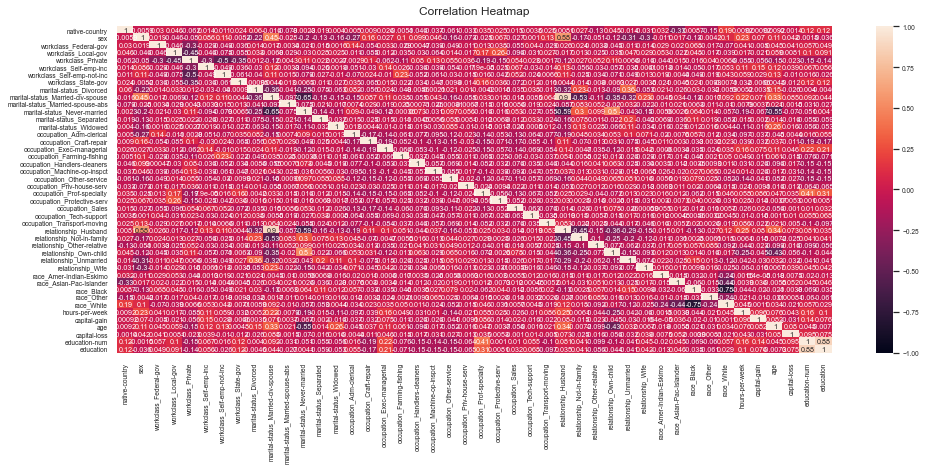

In [91]:
plt.figure(figsize=(16, 6))
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
sns.set(font_scale = 0.6)
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We can see light colured boxes indicating a strong positive correlation with correlations of 0.9 and 0.88 for 2 pairs of variables. We can check which these are:

In [92]:
combs = list(combinations(X_train.columns,2))
corrDict = {}
for comb in combs:
    corrDict[comb[0] + ", " + comb[1]] = X_train.corr()[comb[0]][comb[1]]

In [93]:
corrSeries = pd.Series(corrDict, name="Correlation")
corrSeries.sort_values(ascending=False).head(5)

marital-status_Married-civ-spouse, relationship_Husband    0.900614
education-num, education                                   0.882395
sex, relationship_Husband                                  0.582134
marital-status_Never-married, relationship_Own-child       0.503919
sex, marital-status_Married-civ-spouse                     0.445504
Name: Correlation, dtype: float64

As expected, education and education-num are highly correlated, with a correlation of 0.88. marital-status_Married-civ-spouse and relationship_Husband have a correlation of 0.9. We can drop 1 feature from each of these pairs:

In [90]:
X_train.drop(columns=["marital-status_Married-civ-spouse", "education-num"], inplace=True)
X_test.drop(columns=["marital-status_Married-civ-spouse", "education-num"], inplace=True)

I'm not entirely sure if this works in the same way for features which are strongly negatively correlated, so to be safe I will not remove those that are.

#### Evaluation Metric

Before I move on to the feature selection, I will first decide what metric to use throughout the remainder of the assignment for evaluation and comparisons.

We can see below that for the test set, 76% of examples are of the class <=50K (0) and the remaining 24% are of the class >50K (1). This dataset is quite imbalanced. 

In [95]:
y_train.value_counts()

0    3052
1     941
Name: Income-category, dtype: int64

In [97]:
greaterThan50K = 100*y_train.value_counts()[1] / y_train.shape[0]
print("<=50K: %.2f" %(100-greaterThan50K))
print(">50K: %.2f" %greaterThan50K)

<=50K: 76.43
>50K: 23.57


It is not as extreme as some other datasets which we have worked with, such as the dataset for assignment 1 which had about a 99:1 ratio for the target classes. However, this is still fairly imbalanced. If we had a classifier that just classified all samples as 0 (<=50K) this would give us a 76% accuracy which would seem pretty good. Thus we should consider an alternative metric.

For assignment 1, there was a very obvious different between the consequences of a false positive and false negative. We were designing a model that would help to prevent animal deaths in a shelter, so if an animal was not classified as at risk when they really were at risk then this could lead to the death of the animal. This has more of a consequence than flagging a safe animal as at risk.

In this assignment, however, I don't think there is the same extreme difference between a false positive and a flase negative. Below explains the meaning of false/true positive/negative in this context.

True Positive: Correctly classify individual with income >50K as >50K.
False Positive: Incorrectly classify individual with income <=50K as >50K.
True Negative: Correctly classify individual with income <=50K as <=50K.
False Negative: Incorrectly classify individual with income >50K as not <=50K.

We haven't been told very much about the context of the application of this model. For that reason I will assume that there should be equal weight for false positives and false negatives in the classifier that we choose.

Precision and recall are more suitable metrics to use in this type of inbalanced classification problem.

Precision is the proportion of retrieved results that are relevant. It is calculated as the rate of true positives divided by the sum of true positives and false positives. In this context, it is the proportion of individuals which were classified as >50K that were actually >50K.

Recall, also known as the sensitivity, is the proportion of relevant results that are retrieved. In the context of the question, this is the proportion of all individuals with income >50K that were actually classified as being >50K.

The F-Measure is a single measure that trades off precision against recall. It is calculated as (1 + B^2)(Precision)(Recall) / (B^2)(Precision + Recall). The B parameter controls the trade-off. B<1 focuses on precision, B>1 focuses on recall, and B=1 treats both precision and recall equally, known as the harmonic mean. 

The F-Measure if great for imbalanced data, however even with B=1 it only really focuses on the positive class.

The balanced accuracy metric, however, gives half of its weight to how many positives you labeled correctly and how many negatives you labeled correctly. It is calculated as the mean of TP Rate and TN Rate, i.e. (TPRate + TNRate)/2.

I will use this balanced accuracy (BAR) metric for my evaluations and comparisons.

#### Feature Selection Techniques

*********

#### NOTE: 
I had originally done sequential feature selection for the different classifiers. I however decided not to use the generated feature subsets and to just go with the full feature subsets, as I think it makes more sense for the feature subspacing ensemble to use the full feature sets, and so to keep it consistent I used the full feature sets for all ensembles. I have left in the feature selection explanation and code below as I didn't want to delete any work, but just note that the generated subsets were not used. I have just commented out the code so there is no confusion about what is used and what isnt.

*********


There are a number of different feature selection methods. These are usually divided into 2 general categories: Filters and Wrappers. Filters use a measure such an information gain or chi-sq to rank the features. From there, there are a number of aproaches to select the feature subset, such as:

- Score all features based on their Information Gain (IG). Rank features based on their scores. Then, 
    - Select top 50%.
    - Select features with IG > 50% of max IG score.
    - Evaluate classification performance using feature subsets of increasing size.

- Choose the top features using the chi-sq statistics and SelectKBest.

There are a few key problems with filter feature selection:
1. No Model Bias
    - Different features may suit different learning algorithms, but filters do not take this into account.
2. No Feature Dependencies
    - In filters, the features are considered in isolation from one another, and are not considered in context.
    - In some cases, a filter might select two predictive but correlated features, where one would be sufficient. (We have handelled this somewhat already as discussed)
    - In other cases, one feature needs another feature to boost accuracy, but a filter cannot discover this.
    
Wrapper techniques overcome these issues. The classifier is “wrapped” in the feature selection mechanism. Feature subsets are evaluated directly based on their performance when used with that specific classifier. In this case features are also considered in context. There are several wrapper aproaches, such as exhaustive search, exponential, sequential. Sequential chooses a subset by adding or removing one feature at a time. It is not guaranteed to find the optimal feature subset, however it is very fast and typically finds very good subsets, so I will use the sequential approach. Within sequential search we can do forward sequential selection or backward elimination. I will do both and compare the balanced accuracy.

The question states that I need to evaluate the performance for:
1. a decision tree with depth at most 3
2. a neural network with at most 10 hidden nodes 
3. a 1-NN. 

I will generate a feature subset for the decision tree and knn using using forward and backward sequential search. To do so I will use the sklean Sequential Feature Selection (SFS) with forward=False / forward = True to indicate backward elimination / forward search. I will use balanced accuracy as the metric. For the number of features I will specify 'best'. I will use 10 fold cross validation (cv=10).

I won't do feature selection for the neural network. There doesnt seem to be any simple way to do it, and since feature selection is not required for the assignment I won't do it.

__Decision Tree Classifier:__

In [208]:
# dtc = DecisionTreeClassifier(max_depth=3)

DTC Backward Elimination:

In [209]:
# sfs_dtc = SFS(dtc, k_features="best",  forward=False, floating=False, scoring='balanced_accuracy', cv=10)
# dtcFeatures = sfs_dtc.fit(X_train, y_train, custom_feature_names=X_train.columns)

In [210]:
# dtcFeatureListBack = dtcFeatures.k_feature_names_

DTC Forward Sequential Search:

In [211]:
# sfs_dtc_Forw = SFS(dtc, k_features="best",  forward=True, floating=False, scoring='balanced_accuracy', cv=10)
# dtcFeatures_Forw = sfs_dtc.fit(X_train, y_train, custom_feature_names=X_train.columns)

In [212]:
# dtcFeatureListForw = dtcFeatures_Forw.k_feature_names_

We can see below that the forward and backward searches yielded the same feature subset for the decision tree:

In [213]:
# print("Num features Backwards", len(dtcFeatureListBack), "/", X_train.shape[1])
# print("Num features Forward", len(dtcFeatureListForw), "/", X_train.shape[1])
# print("Intersection size", len(set(dtcFeatureListBack).intersection(set(dtcFeatureListForw))))
# print("Difference size",len(set(dtcFeatureListBack) - set(dtcFeatureListForw)))

Num features Backwards 40 / 42
Num features Forward 40 / 42
Intersection size 40
Difference size 0


__Decision Tree Feature Subset:__

In [214]:
# dtcFeatureList = dtcFeatureListForw
# print(len(dtcFeatureList), "/", X_train.shape[1])
# dtcFeatureListForw

40 / 42


('native-country',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'marital-status_Divorced',
 'marital-status_Married-spouse-abs',
 'marital-status_Never-married',
 'marital-status_Separated',
 'marital-status_Widowed',
 'occupation_Adm-clerical',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Other-service',
 'occupation_Priv-house-serv',
 'occupation_Prof-specialty',
 'occupation_Protective-serv',
 'occupation_Sales',
 'occupation_Tech-support',
 'occupation_Transport-moving',
 'relationship_Not-in-family',
 'relationship_Other-relative',
 'relationship_Own-child',
 'relationship_Unmarried',
 'relationship_Wife',
 'race_Amer-Indian-Eskimo',
 'race_Asian-Pac-Islander',
 'race_Black',
 'race_Other',
 'race_White',
 'capital-gain',
 'capital-loss',
 'ho

__1-Nearest Neighbours:__

In [279]:
# knn = KNeighborsClassifier(n_neighbors=1)

1-NN Backward Elimination:

In [280]:
# sfs_knn = SFS(knn, k_features="best",  forward=False, floating=False, scoring='balanced_accuracy', cv=10)
# knnFeatures = sfs_knn.fit(X_train, y_train, custom_feature_names=X_train.columns)

In [281]:
# knnFeatureListBack = knnFeatures.k_feature_names_

1-NN Forward Sequential Search:

In [282]:
# sfs_knn_Forw = SFS(knn, k_features="best",  forward=True, floating=False, scoring='balanced_accuracy', cv=10)
# knnFeatures_Forw = sfs_knn.fit(X_train, y_train, custom_feature_names=X_train.columns)

In [283]:
# knnFeatureListForw = knnFeatures_Forw.k_feature_names_

As with the decision tree, for knn we can see below that the forward and backward searches yielded the same feature subsets

In [285]:
# print("Num features Backwards", len(knnFeatureListBack), "/", X_train.shape[1])
# print("Num features Forward", len(knnFeatureListForw), "/", X_train.shape[1])
# print("Intersection size",len(set(knnFeatureListBack).intersection(set(knnFeatureListForw))))
# print("Difference size", len(set(knnFeatureListBack) - set(knnFeatureListForw)))

Num features Backwards 30 / 42
Num features Forward 30 / 42
Intersection size 30
Difference size 0


Again, using forward search yields a feature set that leads to a higher balanced accuracy for the 1-NN classifier. This is surpirising as usually backward elimination tends to generate better feature subsets.

__1-NN Feature Subset:__

In [287]:
# knnFeatureList = knnFeatureListForw
# print(len(knnFeatureList), "/", X_train.shape[1])
# knnFeatureList

30 / 42


('native-country',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Private',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'marital-status_Divorced',
 'marital-status_Never-married',
 'marital-status_Separated',
 'occupation_Adm-clerical',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Other-service',
 'occupation_Prof-specialty',
 'occupation_Protective-serv',
 'occupation_Transport-moving',
 'relationship_Not-in-family',
 'relationship_Own-child',
 'relationship_Unmarried',
 'relationship_Wife',
 'race_Amer-Indian-Eskimo',
 'race_Black',
 'race_White',
 'capital-gain',
 'capital-loss',
 'age')

__Features in both DTC and KNN subsets__

In [288]:
# set(knnFeatureList).intersection(set(dtcFeatureList))

{'capital-gain',
 'capital-loss',
 'marital-status_Divorced',
 'marital-status_Never-married',
 'marital-status_Separated',
 'native-country',
 'occupation_Adm-clerical',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Other-service',
 'occupation_Prof-specialty',
 'occupation_Protective-serv',
 'occupation_Transport-moving',
 'race_Amer-Indian-Eskimo',
 'race_Black',
 'race_White',
 'relationship_Not-in-family',
 'relationship_Own-child',
 'relationship_Unmarried',
 'relationship_Wife',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Private',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov'}

<!-- The above features are in both subsets. Based on my previous EDA I expected capital-gain, education-num and sex to be strong predictors of income category. I am surprised that occupation_Farming-fishing and occupation_Handlers-cleaners are too (given that they were chosen for both classifiers). Cleaners and handlers are typically low incomne jobs so it is likely that the majority of these are in the lower income  category. We can see below that this is the case, and is also the case for occupation_Farming-fishing. -->

In [223]:
# y_train.iloc[X_train[X_train['occupation_Handlers-cleaners']==1].index].value_counts()

0    162
1     14
Name: Income-category, dtype: int64

In [286]:
# y_train.iloc[X_train[X_train['occupation_Farming-fishing']==1].index].value_counts()

### Base Classifiers
#### Neural Network

The neural network needs to have a maximum of 10 hidden nodes. I will calculate all possible combbinations of hidden_layer_sizes that sum to 10 nodes and use grid search to find the best:

In [99]:
# find all combinations that sum to a 10
 
def combinationSum(arr, sum):
    ans = []
    temp = []
    arr = sorted(list(set(arr)))
    findNumbers(ans, arr, temp, sum, 0)
    return ans
 
def findNumbers(ans, arr, temp, sum, index):
     
    if(sum == 0):
         
        # Adding deep copy of list to ans
        ans.append(list(temp))
        return
       
    # Iterate from index to len(arr) - 1
    for i in range(index, len(arr)):
 
        # checking that sum does not become negative
        if(sum - arr[i]) >= 0:
 
            # adding element which can contribute to
            # sum
            temp.append(arr[i])
            findNumbers(ans, arr, temp, sum-arr[i], i)
 
            # removing element from list (backtracking)
            temp.remove(arr[i])

arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ans = []
for num in arr:
    ans.extend(combinationSum(arr, num))


print(ans)

[[1], [1, 1], [2], [1, 1, 1], [1, 2], [3], [1, 1, 1, 1], [1, 1, 2], [1, 3], [2, 2], [4], [1, 1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 3], [1, 2, 2], [1, 4], [2, 3], [5], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 2], [1, 1, 1, 3], [1, 1, 2, 2], [1, 1, 4], [1, 2, 3], [1, 5], [2, 2, 2], [2, 4], [3, 3], [6], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 2], [1, 1, 1, 1, 3], [1, 1, 1, 2, 2], [1, 1, 1, 4], [1, 1, 2, 3], [1, 1, 5], [1, 2, 2, 2], [1, 2, 4], [1, 3, 3], [1, 6], [2, 2, 3], [2, 5], [3, 4], [7], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 2], [1, 1, 1, 1, 1, 3], [1, 1, 1, 1, 2, 2], [1, 1, 1, 1, 4], [1, 1, 1, 2, 3], [1, 1, 1, 5], [1, 1, 2, 2, 2], [1, 1, 2, 4], [1, 1, 3, 3], [1, 1, 6], [1, 2, 2, 3], [1, 2, 5], [1, 3, 4], [1, 7], [2, 2, 2, 2], [2, 2, 4], [2, 3, 3], [2, 6], [3, 5], [4, 4], [8], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 2], [1, 1, 1, 1, 1, 1, 3], [1, 1, 1, 1, 1, 2, 2], [1, 1, 1, 1, 1, 4], [1, 1, 1, 1, 2, 3], [1, 1, 1, 1, 5], [1, 1, 1, 2, 2, 2], [1, 1, 1, 2, 4], [1, 1, 1, 3, 3], [1, 

In [105]:
nn = MLPClassifier(random_state=1, max_iter=600)

In [106]:
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"hidden_layer_sizes":ans}


# #use gridsearch to test all values for n_neighbors
nn_gscv = GridSearchCV(nn, param_grid, cv=5, scoring="balanced_accuracy")

In [107]:
print(nn_gscv)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=600, random_state=1),
             param_grid={'hidden_layer_sizes': [[1], [1, 1], [2], [1, 1, 1],
                                                [1, 2], [3], [1, 1, 1, 1],
                                                [1, 1, 2], [1, 3], [2, 2], [4],
                                                [1, 1, 1, 1, 1], [1, 1, 1, 2],
                                                [1, 1, 3], [1, 2, 2], [1, 4],
                                                [2, 3], [5], [1, 1, 1, 1, 1, 1],
                                                [1, 1, 1, 1, 2], [1, 1, 1, 3],
                                                [1, 1, 2, 2], [1, 1, 4],
                                                [1, 2, 3], [1, 5], [2, 2, 2],
                                                [2, 4], [3, 3], [6],
                                                [1, 1, 1, 1, 1, 1, 1], ...]},
             scoring='balanced_accuracy')


In [108]:
nn_gscv.fit(X_train, y_train)

/Users/DervlaScully/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/DervlaScully/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=600, random_state=1),
             param_grid={'hidden_layer_sizes': [[1], [1, 1], [2], [1, 1, 1],
                                                [1, 2], [3], [1, 1, 1, 1],
                                                [1, 1, 2], [1, 3], [2, 2], [4],
                                                [1, 1, 1, 1, 1], [1, 1, 1, 2],
                                                [1, 1, 3], [1, 2, 2], [1, 4],
                                                [2, 3], [5], [1, 1, 1, 1, 1, 1],
                                                [1, 1, 1, 1, 2], [1, 1, 1, 3],
                                                [1, 1, 2, 2], [1, 1, 4],
                                                [1, 2, 3], [1, 5], [2, 2, 2],
                                                [2, 4], [3, 3], [6],
                                                [1, 1, 1, 1, 1, 1, 1], ...]},
             scoring='balanced_accuracy')

In [110]:
nn_gscv.best_params_

{'hidden_layer_sizes': [1, 2, 3, 4]}

#### DTC, 1-NN, NN

Parameter tuning is not necessary, the classifiers need to just be better than random (0.5). We fit the classifiers and  calculate the average balanced accuracy for each using k fold cross validation with 10 folds, and then calculate the balanced accuracy for the unseen test data:

In [92]:
folds = 10
v = 0

In [93]:
dtc = DecisionTreeClassifier(max_depth=3, random_state=1)

cv_dict_DTC = cross_validate(dtc, X_train, y_train, cv=folds, verbose = v, n_jobs = -1, return_estimator=True, scoring="balanced_accuracy")

cv_scores_DTC = cv_dict_DTC["test_score"]
dtc = cv_dict_DTC["estimator"][0]

print("Average balanced accuracy of decision tree on training data using 10-fold cross validation:\n",cv_scores_DTC.mean())

predictions = dtc.predict(X_test)
print("Balanced accuracy of decision tree on unseen test data:\n", balanced_accuracy_score(y_test, predictions))

Average balanced accuracy of decision tree on training data using 10-fold cross validation:
 0.7143809231388724
Balanced accuracy of decision tree on unseen test data:
 0.7091734432438455


In [94]:
knn = KNeighborsClassifier(n_neighbors=1)

cv_dict_KNN = cross_validate(knn, X_train, y_train, cv=folds, verbose = v, n_jobs = -1, return_estimator=True, scoring="balanced_accuracy")

cv_scores_KNN = cv_dict_KNN["test_score"]
knn = cv_dict_KNN["estimator"][0]

print("Average balanced accuracy of 1-nearest neighbours classifier on training data using 10-fold cross validation:\n",cv_scores_KNN.mean())

predictions = knn.predict(X_test)
print("Balanced accuracy of 1-nearest neighbours classifier on unseen test data:\n", balanced_accuracy_score(y_test, predictions))

Average balanced accuracy of 1-nearest neighbours classifier on training data using 10-fold cross validation:
 0.6977151749580561
Balanced accuracy of 1-nearest neighbours classifier on unseen test data:
 0.6555085217778768


In [95]:
nn = MLPClassifier(random_state=1,hidden_layer_sizes = [1, 2, 3, 4], max_iter=600).fit(X_train, y_train)

cv_dict_NN = cross_validate(nn, X_train, y_train, cv=folds, verbose = v, n_jobs = -1, return_estimator=True, scoring="balanced_accuracy")

cv_scores_NN = cv_dict_NN["test_score"]
nn = cv_dict_NN["estimator"][0]

print("Average balanced accuracy of neural network classifier on training data using 10-fold cross validation:\n",cv_scores_NN.mean())

predictions = nn.predict(X_test)
print("Balanced accuracy of neural  network classifier on unseen test data:\n", balanced_accuracy_score(y_test, predictions))

Average balanced accuracy of neural network classifier on training data using 10-fold cross validation:
 0.7822552355193297
Balanced accuracy of neural  network classifier on unseen test data:
 0.7553330734098251


All three classifiers are better than random (balanced accuracy > 0.5). The neural network has the highest balanced accuracy, followed by the decision tree and finally the 1-nearest neighbours classifier.

#### Basic Classifiers: Summary


| Classifier | BAR on unseen test data | 
|----|----|
| Decision Tree Classifier  | 0.709 |
| 1-Nearest Neighbours Classifier | 0.66 |
| Neural Network | 0.76 |

## Ensemble Classification

Ensemble classification combines individual predictions from multiple classifiers in order to make more accurate predictions. We will generate an ensemble of decision trees, ensemble of 1-nearest neighbour classifiers, and ensemble of neural networks, using the 3 classifiers from above.

### Ensembles with Bagging

Generating ensembles using __Bagging involves training n classifiers on different subsets of the training data__, where we randomly sample from training data __with replacement__ and apply the classifier to each sample.

I will apply ensembles with bagging using the three classifiers from Task (b), and investigate the performance of these classifiers as the ensemble size increases. 

Using the best performing ensemble size, I will then investigate how changing the number of instances in the bootstrap samples affects classification performance.

I will use the sklearn BaggingClassifier. This will be used for the Bagging and the Random Subspacing.

BaggingClassifier will take parameters base_estimator which will be the classifier from the previous section, n_estimators which is the number of the classifiers, i.e. the ensemble size, bootstrap which will be set to true to indicate sample with replacement, max_samples which is the number of instances in the bootstrap samples, and random state = 1 so that the results are reproducible. 

I will leave max_features with its default value of 1.0, which means that if there are in total N features then N features will be selected for each estimator, and bootstrap_features is defaulted to False meaning features are selected without replacement. Thus, this means that all of the features will be selected for each estimator.
___ 
However, we note that if I keep the default max_samples for bagging and the default max_features for random subspacing then I will get the same results for each when investigating the performance as the ensemble size increases, as for each we will have max_samples = 1.0 and max_features = 1.0, their default values, so the ensembles will be the same. Because of this, I will also investigate the performance for increasing ensemble sizes for max_samples of 0.25, 0.5, 0.75 and will plot these together on a graph to see how the general trends differ. The question does not spefify the value to have max_samples at when choosing the best ensemble size so I will assume the default value of 1.0.

SO I will investigate for a few max_samples values but will choose the best performing ensemble size for when max_samples is its default value of 1.0.
___

I will define a number of functions which will calculated the average balanced accuracy for increasing ensemble sizes using cross validation and graph the results:

#### Ensemble Bagging - Varying ensemble_size

In [217]:
# function to calculate mean BAR for varying ensemble sizes
# returns dict where keys are ensemble sizes and corresponding values are mean BARs

def baggingVaryingEnsembleSize(classifier, min=2, max=20, step=2, max_samples=1.0):
    
    # dict to hold ensemble size : mean balance accuracy score
    EnsembleSize_MeanBalancedAccuracy = {}
    
    # iterate through increasing ensemble sizes, default from 0-20 with steps of size 2
    for i in range(min, max, step):
        
        # bagging
        dtc_bag = BaggingClassifier(classifier, 
                                n_estimators = i,
                                max_samples = max_samples, # bootstrap resampling 
                                bootstrap = True, 
                                random_state=1)

        # cross val
        scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, 
                                          cv=10, verbose = 0, n_jobs = -1, 
                                          scoring="balanced_accuracy")
        
        # extract scores, get mean, set ensemble size : mean balance accuracy score in dict
        EnsembleSize_MeanBalancedAccuracy[i] = round(scores_tree_bag.mean(), 5)

    return EnsembleSize_MeanBalancedAccuracy

# function to print the ensemble sizes and correpsonding mean balanced accuracy scores
def baggingVaryingEnsembleSizePrint(classifierName, classifier, min=2, max=20, step=2, max_samples=1.0):
    
    classifier_BaggingVaryingEnsemble = baggingVaryingEnsembleSize(classifier, min=min, max=max, step=step, max_samples=max_samples)
    
    print(classifierName)
    print("\nEnsemble Size, Mean Balanced Accuracy")
    
    for ensemblesize in classifier_BaggingVaryingEnsemble:
        print(ensemblesize, "\t\t", classifier_BaggingVaryingEnsemble[ensemblesize])
        
    return classifier_BaggingVaryingEnsemble

In [218]:
# function to plot ensemble size vs mean BAR
def baggingVaryingEnsembleSizeGraph(classifierName, scoresDict):
    plt.figure(figsize=(16, 6))
    sns.set(font_scale = 1)
    ax = sns.lineplot(data=pd.Series(scoresDict))
    ax.set(ylabel='Mean Balanced Accuracy', xlabel='Ensemble Size')
    ax.set_title('Mean Balanced Accuracy Varying Ensemble Size: ' + classifierName, fontdict={'fontsize':14}, pad=14)
    plt.show()

In [256]:
# Function which will graph ensemble size vs BAR for various max_samples values

def BaggingVaryingEnsembleSizeAndMaxSamples(classifier, min=2, max=20, step=2, max_samples_list = [0.25, 0.5, 0.75, 1.0], classifierName = "classifier"):
    
    # dataframe, columns = different values for max_features, values = correpsonding values for BAR with varying ensemble size 
    dfBARVaryingEnsembleSize = pd.DataFrame(columns = max_samples_list)
    
    # figure
    plt.figure(figsize=(16, 6))
    sns.set(font_scale = 1)
    
    #    Loop for different values of max_features
    for max_samples in max_samples_list:
        
        # dict to hold ensemble size : mean balance accuracy score
        EnsembleSize_MeanBalancedAccuracy = {}
    
        # iterate through increasing ensemble sizes, default from 0-20 with steps of size 2
        for i in range(min, max, step):

            # bagging
            dtc_bag = BaggingClassifier(classifier, 
                                    n_estimators = i,
                                    max_samples = max_samples,
                                    random_state=1)

            # cross val
            scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, 
                                              cv=10, verbose = 0, n_jobs = -1, 
                                              scoring="balanced_accuracy")

            # extract scores, get mean, set ensemble size : mean balance accuracy score in dict
            EnsembleSize_MeanBalancedAccuracy[i] = round(scores_tree_bag.mean(), 5)
        
        # add to dataframe
        dfBARVaryingEnsembleSize[max_samples] = pd.Series(EnsembleSize_MeanBalancedAccuracy)
    
    # plot
    ax = sns.lineplot(data=dfBARVaryingEnsembleSize)
    
    ax.set(ylabel='Mean Balanced Accuracy', xlabel='Ensemble Size')
    ax.legend(title="max_samples")
    ax.set_title('Mean Balanced Accuracy Vs Ensemble Size for '+classifierName, fontdict={'fontsize':14}, pad=14)
    plt.show()

#### Ensemble bagging increasing ensemble size: Decision Tree Classifiers

I will use the above methods to calculate and plot the mean BAR for ensemble sizes ranging from 2 to 34:

Decision Tree Classifier

Ensemble Size, Mean Balanced Accuracy
2 		 0.71561
4 		 0.71651
6 		 0.71634
8 		 0.71651
10 		 0.71684
12 		 0.71667
14 		 0.71598
16 		 0.71614
18 		 0.71614
20 		 0.71614
22 		 0.7163
24 		 0.71598
26 		 0.71614
28 		 0.71614
30 		 0.71614
32 		 0.71614
34 		 0.71614


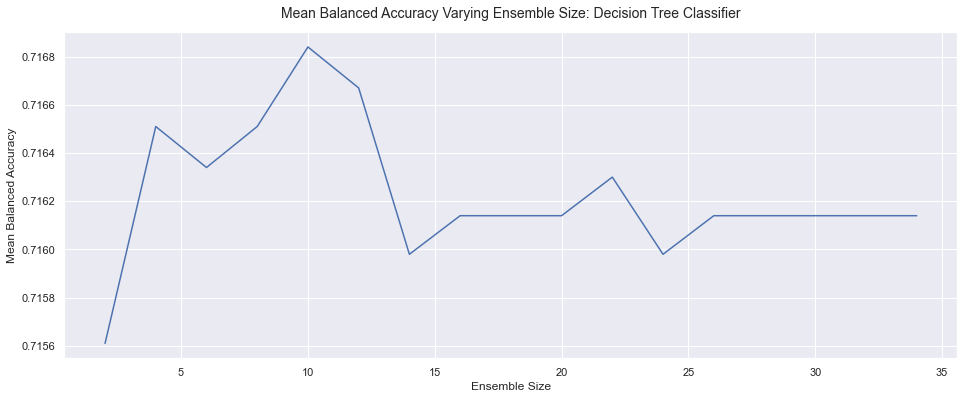

In [222]:
dtcBaggingScoresVaryingEnsembleSize = baggingVaryingEnsembleSizePrint("Decision Tree Classifier",dtc, max=35)
baggingVaryingEnsembleSizeGraph("Decision Tree Classifier",dtcBaggingScoresVaryingEnsembleSize)

For the ensemble of decision trees, the BAR increases fairly steadily as we increase the ensemble size. It reaches a max at size 10 of 0.71684, and then decreases. It eventually seems to converge at 0.71614 from ensemble size 34 onwards. 

This means that as we add more DT classifiers to our ensemble we see an increase in the balanced accuracy at first, we reach the highest BAr when we have 10 DTs, and then when we add more it starts to decrease again, and eventually settles at about BAR 0.71614 from 34 DTs onwards.


Thus the best performing ensemble size is 10.

As mentioned above I will also plot for max_samples of 025, 0.5, 0.75 and see if shape of the grsph / trends are consistent, however I will use 10, as calculated above, as the best performing ensemble size.

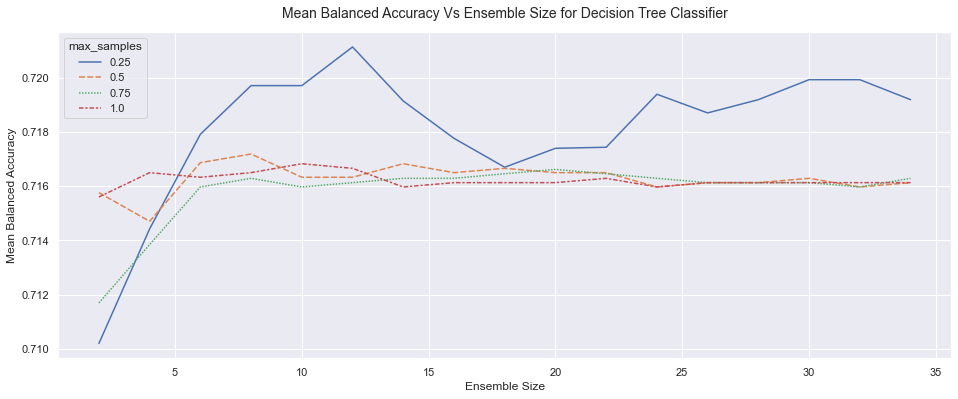

In [259]:
BaggingVaryingEnsembleSizeAndMaxSamples(dtc, max=35, classifierName = "Decision Tree Classifier")

Above we can see the mean balanced accuracy for increasing ensemble sizes for a number of different values of max_samples. There is a large amount of variation for max_samples of 0.25. For max_samples of 0.5 and 1.0 the range of BAR values for increasing ensemble sizes is much smaller. For max_samples 0.75 there is a steep positive slope followed by a flat line similar to that of 0.5 and 1.0. So for larger values of max_samples (>= 0.5) we get very similar BAR values for the increasing ensemble sizes, typically within a bar of about 0.714-0.718, however for max_samples 0.25 the BAR is heavily dependent on the ensemble size with very poor BAR values for small ensemble sizes, but a global max for all at ensemble size approx 12.

Once again I am looking at this as the question doesn't specifically say which value for max_samples to choose when investigating the performance for varying ensemble size, and choosing the default will mean that we will get the same results for the best performing ensemble size for the next question on random subspacing, however I will assume we are to choose the default max_samples 1.0 which has the highest BAR for ensemble size 10. 

#### Ensemble bagging increasing ensemble size: 1-Nearest Neighbours Classifier

1-Nearest Neighbours Classifier

Ensemble Size, Mean Balanced Accuracy
2 		 0.66733
4 		 0.68359
6 		 0.68852
8 		 0.68922
10 		 0.69277
12 		 0.69481
14 		 0.69567
16 		 0.69575
18 		 0.69718
20 		 0.69636
22 		 0.69742
24 		 0.6946
26 		 0.69595
28 		 0.69542
30 		 0.69599
32 		 0.69657
34 		 0.69714


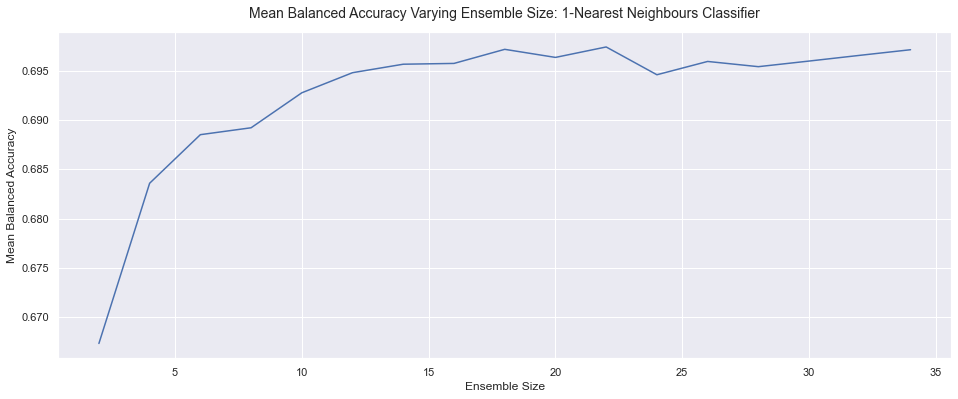

In [261]:
knnBaggingScoresVaryingEnsembleSize = baggingVaryingEnsembleSizePrint("1-Nearest Neighbours Classifier",knn, max=35)
baggingVaryingEnsembleSizeGraph("1-Nearest Neighbours Classifier",knnBaggingScoresVaryingEnsembleSize)

The shape of the graph is very different for KNN and DTC ensembles. For KNN the BAR increases steadily as the ensemble size increases, however when it reaches the max BAR it stays very close to the value as we continue to increase the ensemble size, unlike the DTC ensemble which had a sharp drop in the BAR after the max was reached. So for the KNN ensemble by increasing the ensemble size we seem to converge at the highest BAR. The exact max is at ensemble size 22 so I will take this to be the best performing ensemble size.

This means that as we add more KNN classifiers to the ensemble the BAR increases. It reaches a max BAR at around 22 KNNs, and then stays close to this as we add more KNN classifiers. So unlike the DT ensemble we dont see a decrease BAR when we add more.

I will also look at this for a few more values of max_samples:

<!-- As before, we can also graph for max_samples = 0.5. The shape is again very similar. There is a steep increase until about ensemble size 20, and then the graph stays fairly flat with a very slight increase as we increase the ensemble size. -->

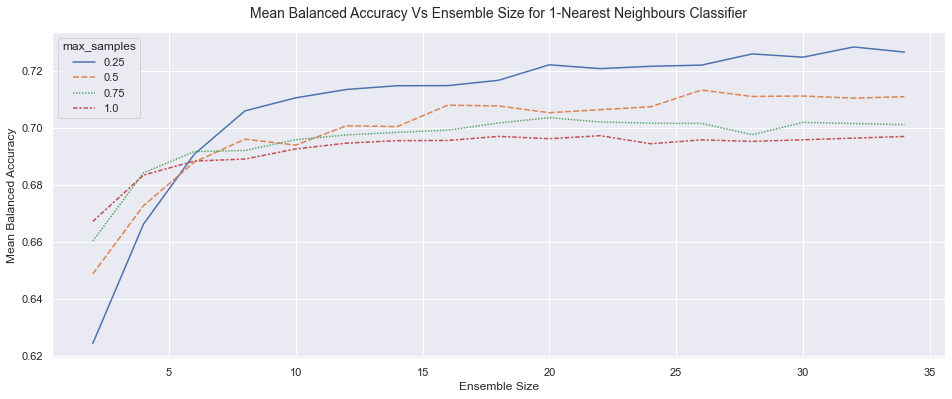

In [262]:
BaggingVaryingEnsembleSizeAndMaxSamples(knn, max=35, classifierName = "1-Nearest Neighbours Classifier")

Unlike with the decision tree ensemble in which the shape of the graph was very different for max_samples 0.25, in the case of KNN the shape is similar for each. For each max_samples value, as we increase the ensemble size we see a sharp increase in the BAR at the beggining, and after about ensemble size 20 the graphs flatten with a very gradual increase as ensemble size is further increased.

#### Ensemble bagging increasing ensemble size: Neural Network Classifier

Neural Network Classifier

Ensemble Size, Mean Balanced Accuracy
2 		 0.64573
4 		 0.64734
6 		 0.72473
8 		 0.716
10 		 0.72236
12 		 0.71479
14 		 0.70812
16 		 0.70258
18 		 0.69788


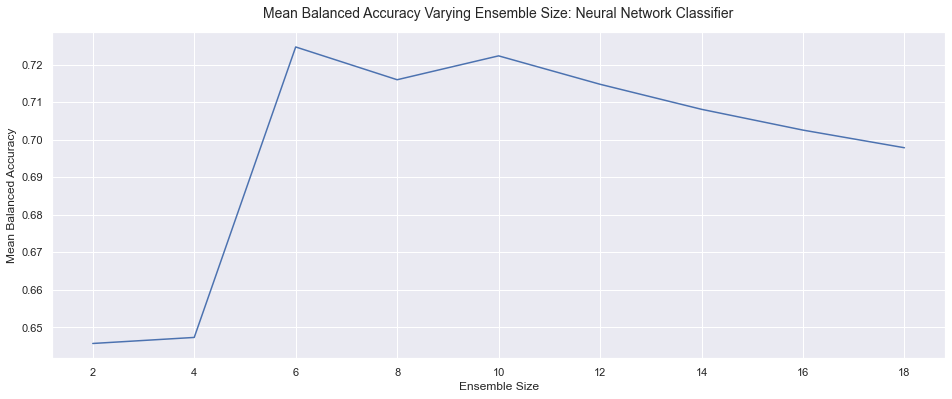

In [180]:
nnBaggingScoresVaryingEnsembleSize = baggingVaryingEnsembleSizePrint("Neural Network Classifier",nn, max=20)
baggingVaryingEnsembleSizeGraph("Neural Network Classifier",nnBaggingScoresVaryingEnsembleSize)

I'm graphing for a smaller number of ensemble sizes for the neural network as it takes much longer to run, and I don't excpet the direction of the slope to change drastically and start to increase if we increase the ensemble size further.

The graph for the neural network ensemble is similar to that of the decision tree. It increase steadily to reach the max BAR at ensemble size 6. We then see a fairly steady decrease as the ensemble size is further increased.

So this means that as we add more NNs to the ensemble the BAR increases. It reaches a max of 0.72473 at 6 NNs, and then the BAR decreases as we add more NNs.

Again, we will investigate for a few more values of max_samples:

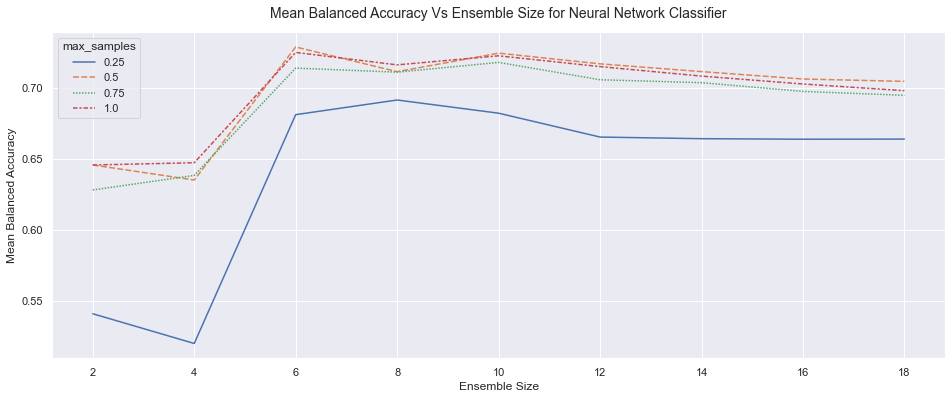

In [263]:
BaggingVaryingEnsembleSizeAndMaxSamples(nn, max=20, classifierName = "Neural Network Classifier")

Unlike the DTC and 1-NN ensembles, we can immediately see that the NN emseble performs much better with larger values for max_samples, which is something we will investigate in the necxt section. The BAR values for increasing ensemble sizes are very similar for max_samples 0.5, 0.75, 1.0, and much lower BAR values bet very similar trends are seen for max_samples 0.25.

#### Ensemble Bagging Varying Ensemble Size: Summary

The best ensemble sizes as well as the highest mean BAR for each ensemble are summarised below:

| Ensemble Classifier | Best Ensemble Size | Max Mean BAR | 
|----|----|---|
| Decision Tree Classifier | 10 | 0.71684 |
| 1-Nearest Neighbours Classifier | 22 | 0.69742 |
| Neural Network |6 | 0.72473 |

#### Ensemble Bagging - Varying max_samples

Next we will vary the max_samples parameter, with the best performing ensemble size as calculated above. Max_samples is the number of samples to draw from the data to train each base estimator.

When max_samples is a float, the number of samples  drawn for each estimator is max_samples * total number of samples.

Say there are n samples total. For the case of max_samples = 1.0 we are choosing n samples for each estimator, for max_samples = 0.5 we are choosing 0.5n samples, and so on. 

Because we are sampling with replacement, choosing max_samples=1.0 does not mean that every classifier is trained on all of the samples. There may be duplicates choosen, and some samples not choosen which are known as out of bag samples. Typically, when max_samples = 1.0 only about 63% of the samples are actually chosen and the rest are out of bag.

I will evalute the performance for max_samples of 0.1, 0.2, 0.3, ...., 1.0. As above, I will define functions to calculate and graph the BAR for varying max_samples to avoid repeating the same code for each. 

In [283]:
# function to calculate mean BAR for increasing  max_samples
# returns a dictionary, keys = ensemble sizes, values = corresponding mean BARs

# can also be used for random subspacing varying max_features.
# for this, bagging = False is passed in as parameter

def baggingVaryingMaxSamples(classifier, n_estimators, bagging=True):
    
    # dictionary to hold ensemble size : mean BAR
    MaxSamples_MeanBalancedAccuracy = {}
    
    # iterate through max samples  0.1, 0.2, .., 1.0
    for i in np.linspace(0,1,11):
        
        i=round(i, 3) # round
        if i>0: # can't get for max_samples = 0
            
            # for bagging
            if bagging:
                samples, features = i, 1.0 # max_features set to default 1.0
                
            # for random subspacing
            else:
                samples, features = 1.0, i # max samples set to default 1.0
            
            
            # apply bagging
            dtc_bag = BaggingClassifier(classifier, 
                                    n_estimators = n_estimators,
                                    max_samples = samples, # bagging
                                    max_features = features, # randomn subspacing
                                    random_state=1)

            # cross val
            scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, 
                                              cv=10, verbose = 0, n_jobs = -1, 
                                              scoring="balanced_accuracy")

            # add to dictionary
            MaxSamples_MeanBalancedAccuracy[i] = round(scores_tree_bag.mean(), 5)

    return MaxSamples_MeanBalancedAccuracy

# function to print the values from the dictionary created above
def baggingVaryingMaxSamplesPrint(classifierName, classifier, n_estimators, bagging=True):
    
    classifier_BaggingVaryingMaxSamples = baggingVaryingMaxSamples(classifier, n_estimators, bagging=bagging)
    
    print(classifierName)
    print("\nEnsemble Size, Mean Balanced Accuracy")
    
    for MaxSample in classifier_BaggingVaryingMaxSamples:
        print(MaxSample, "\t\t", classifier_BaggingVaryingMaxSamples[MaxSample])
        
    return classifier_BaggingVaryingMaxSamples


In [297]:
# function to graph the values from the dictionary created above
def baggingVaryingMaxSamplesGraph(classifierName, scoresDict, bagging=True):
    plt.figure(figsize=(16, 6))
    sns.set(font_scale = 1)
    ax = sns.lineplot(data=pd.Series(scoresDict))
    
    if bagging: 
        label = "Max Samples: " + classifierName
        ax.set(ylabel='Mean Balanced Accuracy', xlabel='Max Samples')
    else:
        label = "Max Features: " + classifierName
        ax.set(ylabel='Mean Balanced Accuracy', xlabel='Max Features')
        
    ax.set_title('Mean Balanced Accuracy Varying ' + label, fontdict={'fontsize':14}, pad=14)
        
    plt.show()

#### Ensemble Bagging Varying max_samples - Decision Tree Classifiers

Decision Tree Classifier

Ensemble Size, Mean Balanced Accuracy
0.1 		 0.71226
0.2 		 0.71532
0.3 		 0.72308
0.4 		 0.71954
0.5 		 0.71634
0.6 		 0.71598
0.7 		 0.71598
0.8 		 0.71614
0.9 		 0.71598
1.0 		 0.71684


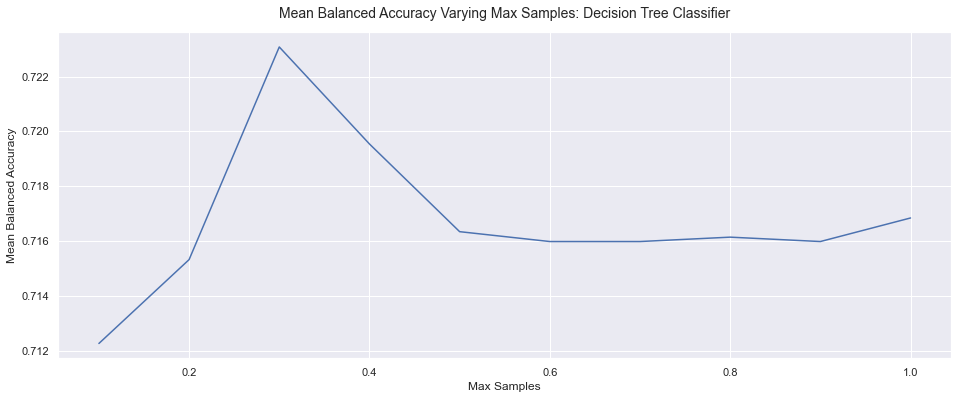

In [306]:
dtcBaggingScoresVaryingMaxSamples = baggingVaryingMaxSamplesPrint("Decision Tree Classifier",dtc,10)
baggingVaryingMaxSamplesGraph("Decision Tree Classifier",dtcBaggingScoresVaryingMaxSamples)

For the decision tree classifier ensemble, as we increase the number of samples used to train the estimators the BAR increases at first. It reaches a max BAR of 0.72308 at 0.3, and then decreases steadily. From max_samples 0.5 - 1 the BAR stays at arounf 0.716, with a slight increase from 0.9 to 1.0.

This means that the best performance is seen when 30% of the samples are used to train each classifier.

#### Ensemble Bagging Varying max_samples -1-Nearest Neighbours Classifiers

1-Nearest Neighbours Classifier

Ensemble Size, Mean Balanced Accuracy
0.1 		 0.71578
0.2 		 0.72161
0.3 		 0.71546
0.4 		 0.71856
0.5 		 0.70654
0.6 		 0.70898
0.7 		 0.70358
0.8 		 0.69952
0.9 		 0.69555
1.0 		 0.69742


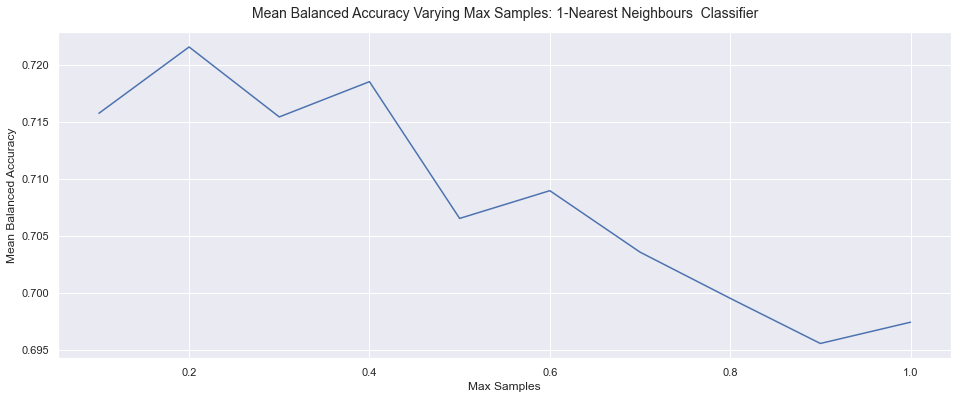

In [184]:
knnBaggingScoresVaryingMaxSamples = baggingVaryingMaxSamplesPrint("1-Nearest Neighbours Classifier",knn, 22)
baggingVaryingMaxSamplesGraph("1-Nearest Neighbours  Classifier",knnBaggingScoresVaryingMaxSamples)

For the KNN classifier ensemble, as we increase the number of samples used to train the estimators from 0.1 to 0.2 the BAR increases and reaches its max at this point, with a BAR of 0.72161. We can then see a general downward trend after this.

This means that the best performance is seen when 20% of the samples are used to train each KNN classifier.

#### Ensemble Bagging Varying max_samples -Neural Network Classifiers

Neural Network Classifier

Ensemble Size, Mean Balanced Accuracy
0.1 		 0.59153
0.2 		 0.62624
0.3 		 0.68187
0.4 		 0.7197
0.5 		 0.72857
0.6 		 0.72564
0.7 		 0.72576
0.8 		 0.72209
0.9 		 0.72
1.0 		 0.72473


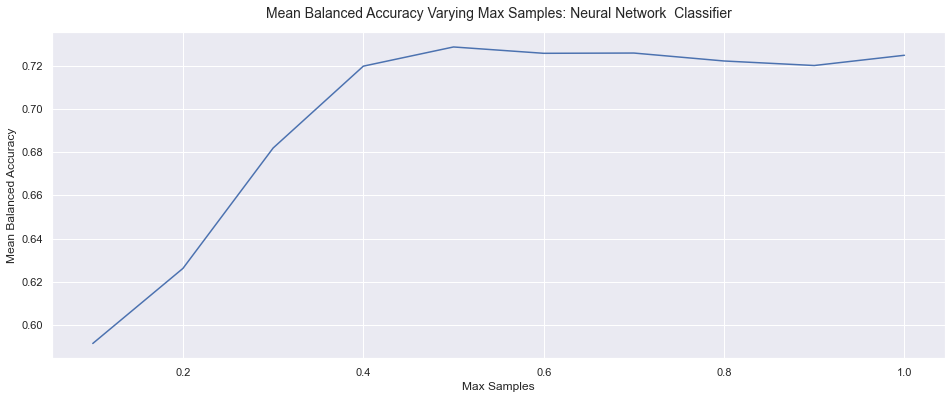

In [185]:
nnBaggingScoresVaryingMaxSamples = baggingVaryingMaxSamplesPrint("Neural Network Classifier",nn, 6)
baggingVaryingMaxSamplesGraph("Neural Network  Classifier", nnBaggingScoresVaryingMaxSamples)

As we increase the max sample for the neural network ensemble we seem to converge at the max BAR. There is a steady increase in balanced accuracy as we increase the sample size, and the max bar of 0.72857 at max samples 0.5. The BAR then stays very close to this value as we continue to increase the sample size. So unlike the DTC and KNN ensembles in which the performance reaches a peak and then worsens as we add more samples, the performance reaches a peak for the NN ensemble and then stays at this performance rate while we increase to max_samples = total number of samples. 

So the NN ensemble performs better with more samples, while the DTC and KNN ensembles perform worse with more samples.

#### Ensemble Bagging Varying max_samples: Summary

| Ensemble Classifier | Best Max Samples | Max Mean BAR | 
|----|----|---|
| Decision Tree Classifier | 0.3 |  0.72308 |
| 1-Nearest Neighbours Classifier | 0.2 | 0.72161 |
| Neural Network | 0.5| 0.72857 |

It is interesting to see at this point how all 3 classifiers are performing pretty similarly in terms of BAR on the training data, even though there was quite a significant difference in the performance of the individual classifiers (for example the NN had a higher BAR, 10% higher than KNN, on the unseen data and now they are both very simialr at approx 0.72 BAR). I will discuss this more later in the comparison but it is interesting to see.

Before I move on to the feature subspacing I will fit each of the ensembles using the optimal ensemble size and max_samples on the training data, predict using the test data, calculate the BAR for each, and these will be used later for the comparison.

#### Fit and Predict using Ensembles with best performing ensemble size and number of samples - Bagging

__Decision Tree Ensemble__

In [202]:
dtc_bagging = BaggingClassifier(dtc, 
                            n_estimators = 10,
                            max_samples = 0.3,
                            bootstrap = True, 
                            random_state=1)
dtc_bagging.fit(X_train, y_train)
pred = dtc_bagging.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7207948089562215

#### 1-Nearest Neighbours Ensemble

In [300]:
knn_bagging = BaggingClassifier(knn, 
                            n_estimators = 22,
                            max_samples = 0.2,
                            bootstrap = True, 
                            random_state=1)
knn_bagging.fit(X_train, y_train)
pred = knn_bagging.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.702798819204634

#### Neural Network Ensemble

In [301]:
nn_bagging = BaggingClassifier(nn, 
                            n_estimators = 6,
                            max_samples = 0.5,
                            bootstrap = True, 
                            random_state=1)
nn_bagging.fit(X_train, y_train)
pred = nn_bagging.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7229196836359586

The NN performs best on the test and training data, and also had the best performing base classifiers. The DTC and 1-NN ensembles have almost the same BARs on the unseen data and also had very simialr performance for the training data. I will discuss this in more detail later in the comparisons.

#### Ensemble Bagging Summary: BAR on unseen test data

| Ensemble Classifier | BAR |  
|----|----|
| Decision Tree Classifier | 0.721 |  
| 1-Nearest Neighbours Classifier | 0.721 | 
| Neural Network | 0.723 | 

### Ensembles with Random Subspacing

Bagging trains the base classifiers on different subsets of the training examples with replacement. In comparison, random subspacing trains the base classifiers on different subsets of the features without replacement.

As mentioned previously, if we investigate the performance for different ensemble sizes and keep max_samples and max_features at their default values of 1.0 then the best ensemble sizes will be the same for random subspacing as those found for bagging. I will show this below, and will also investigate for max_features 0.25, 0.5, 0.75 as done before with max_samples, but will choose the best ensemble size for max_features 1.0 for the next section as done previously.

In [226]:
def RSVaryingEnsembleSize(classifier, min=2, max=20, step=2, max_features=1.0):
    # dict to hold ensemble size : mean balanced accuracy score
    EnsembleSize_MeanBalancedAccuracy = {}
    folds = 10
    v = 0
    # iterate through increasing ensemble sizes, default from 0-20 with steps of size 2
    for i in range(min, max, step):
        # bagging
        dtc_bag = BaggingClassifier(classifier, n_estimators = i,max_features = max_features,
                                    bootstrap_features = False, random_state=1)
        # cross val
        scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, cv=folds, 
                                          verbose = v, n_jobs = -1,scoring="balanced_accuracy")
        # extract scores, get mean, set ensemble size : mean balance accuracy score in dict
        EnsembleSize_MeanBalancedAccuracy[i] = round(scores_tree_bag.mean(), 5)
    return EnsembleSize_MeanBalancedAccuracy

# function to print the ensemble sizes and correpsonding mean balanced accuracy scores
def RSVaryingEnsembleSizePrint(classifierName, classifier, min=2, max=20, step=2, max_features=1.0):
    
    classifier_BaggingVaryingEnsemble = RSVaryingEnsembleSize(classifier, min=min, max=max, step=step, 
                                                              max_features=max_features)
    print(classifierName)
    print("\nEnsemble Size, Mean Balanced Accuracy")
    for ensemblesize in classifier_BaggingVaryingEnsemble:
        print(ensemblesize, "\t\t", classifier_BaggingVaryingEnsemble[ensemblesize])
    return classifier_BaggingVaryingEnsemble

In [227]:
# function to plot ensemble size vs mean BAR
def RSVaryingEnsembleSizeGraph(classifierName, scoresDict):
    plt.figure(figsize=(16, 6))
    sns.set(font_scale = 1)
    ax = sns.lineplot(data=pd.Series(scoresDict))
    ax.set(ylabel='Mean Balanced Accuracy', xlabel='Ensemble Size')
    ax.set_title('Mean Balanced Accuracy Varying Ensemble Size: ' + classifierName, fontdict={'fontsize':14}, pad=14)
    plt.show()

In [268]:
# Function which will graph ensemble size vs BAR for various max_features values

def RSVaryingEnsembleSizeAndMaxFeatures(classifier, min=2, max=20, step=2, max_features_list = [0.25, 0.5, 0.75, 1.0], classifierName = "classifier"):
    
    # dataframe, columns = different values for max_features, values = correpsonding values for BAR with varying ensemble size 
    dfBARVaryingEnsembleSize = pd.DataFrame(columns = max_features_list)
    
    # figure
    plt.figure(figsize=(16, 6))
    sns.set(font_scale = 1)
    
    #    Loop for different values of max_features
    for max_features in max_features_list:
        
        # dict to hold ensemble size : mean balance accuracy score
        EnsembleSize_MeanBalancedAccuracy = {}
    
        # iterate through increasing ensemble sizes, default from 0-20 with steps of size 2
        for i in range(min, max, step):

            # bagging
            dtc_bag = BaggingClassifier(classifier, 
                                    n_estimators = i,
                                    max_features = max_features,
                                    bootstrap_features = False, 
                                    random_state=1)

            # cross val
            scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, 
                                              cv=10, verbose = 0, n_jobs = -1, 
                                              scoring="balanced_accuracy")

            # extract scores, get mean, set ensemble size : mean balance accuracy score in dict
            EnsembleSize_MeanBalancedAccuracy[i] = round(scores_tree_bag.mean(), 5)
        
        # add to dataframe
        dfBARVaryingEnsembleSize[max_features] = pd.Series(EnsembleSize_MeanBalancedAccuracy)
    
    # plot
    ax = sns.lineplot(data=dfBARVaryingEnsembleSize)
    
    ax.set(ylabel='Mean Balanced Accuracy', xlabel='Ensemble Size')
    ax.legend(title="max_features")
    ax.set_title('Mean Balanced Accuracy Vs Ensemble Size for '+classifierName, fontdict={'fontsize':14}, pad=14)
    plt.show()

#### Ensemble random subspacing increasing ensemble size: Decision Tree Classifiers

Decision Tree Classifier

Ensemble Size, Mean Balanced Accuracy
2 		 0.71561
4 		 0.71651
6 		 0.71634
8 		 0.71651
10 		 0.71684
12 		 0.71667
14 		 0.71598
16 		 0.71614
18 		 0.71614
20 		 0.71614
22 		 0.7163
24 		 0.71598
26 		 0.71614
28 		 0.71614
30 		 0.71614
32 		 0.71614
34 		 0.71614


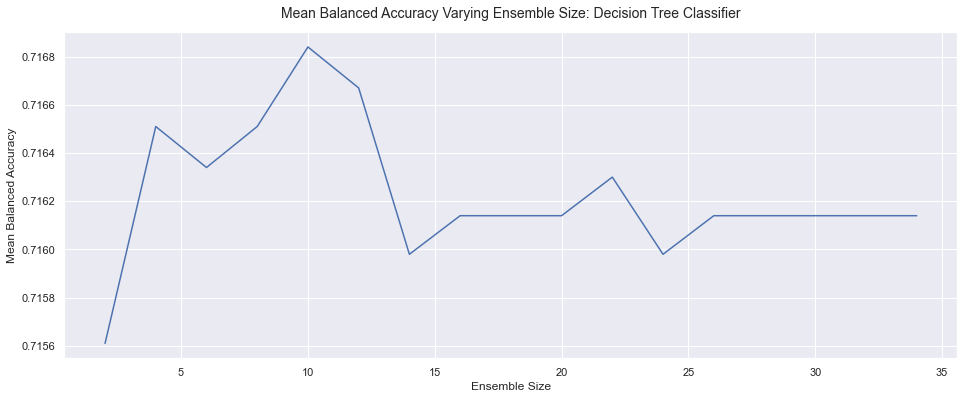

In [245]:
dtcRSScoresVaryingEnsembleSize = RSVaryingEnsembleSizePrint("Decision Tree Classifier",dtc, max=35)
RSVaryingEnsembleSizeGraph("Decision Tree Classifier",dtcRSScoresVaryingEnsembleSize)

As expected, this graph is the exact same as the graph we got for bagging with max_samples = 1.0, the default, as explained previously.

As before, for the ensemble of decision trees using random subspacing with max_features = 1.0 (default), the BAR increases fairly steadily as we increase the ensemble size. It reaches a max at size 10 of 0.71684, and then decreases. It eventually seems to converge at 0.71614 from ensemble size 34 onwards. 

This means that as we add more DT classifiers to our ensemble we see an increase in the balanced accuracy at first, we reach the highest BAR when we have 10 DTs, and then when we add more it starts to decrease again, and eventually settles at about BAR 0.71614 from 34 DTs onwards.

Thus the best performing ensemble size is again 10.

As before with max_samples for bagging, I will also plot for max_features of 025, 0.5, 0.75 and see if shape of the graph / trends are consistent, however I will use 10, as calculated above, as the best performing ensemble size.

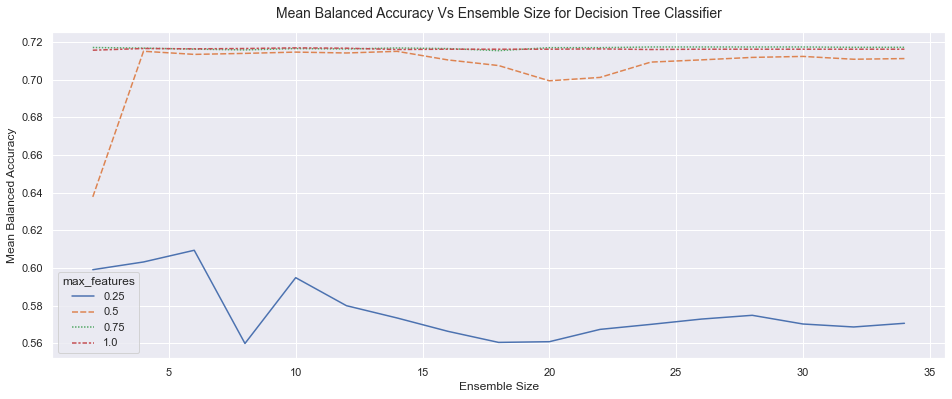

In [248]:
RSVaryingEnsembleSizeAndMaxFeatures(dtc, max=35, classifierName = "Decision Tree Classifier")

For random subspacing for our decision tree ensemble the BAR is much lower for all values of ensemble size for max_features = 0.25. For max_features 0.5 we see a sharp increase from ensemble size 2 to 4 in terms of BAR, and then from ensemble size 4 onwards the BAR stays were consistent and is almost the same for max_features 0.5, 0.75, 1.0.

It is interesting that for bagging we saw significantly higher BAR values for max_samples 0.25, however for random subspacing we see significantly lower BAR values for max_features 0.25. We will investigrate this in more detial in the next part but it is interesting to see how for the decision trees ensembles they work best with more features.

#### Ensemble random subspacing increasing ensemble size: 1-Nearest Neighbours Classifiers

1-Nearest Neighbour Classifiers

Ensemble Size, Mean Balanced Accuracy
2 		 0.66733
4 		 0.68359
6 		 0.68852
8 		 0.68922
10 		 0.69277
12 		 0.69481
14 		 0.69567
16 		 0.69575
18 		 0.69718
20 		 0.69636
22 		 0.69742
24 		 0.6946
26 		 0.69595
28 		 0.69542
30 		 0.69599
32 		 0.69657
34 		 0.69714


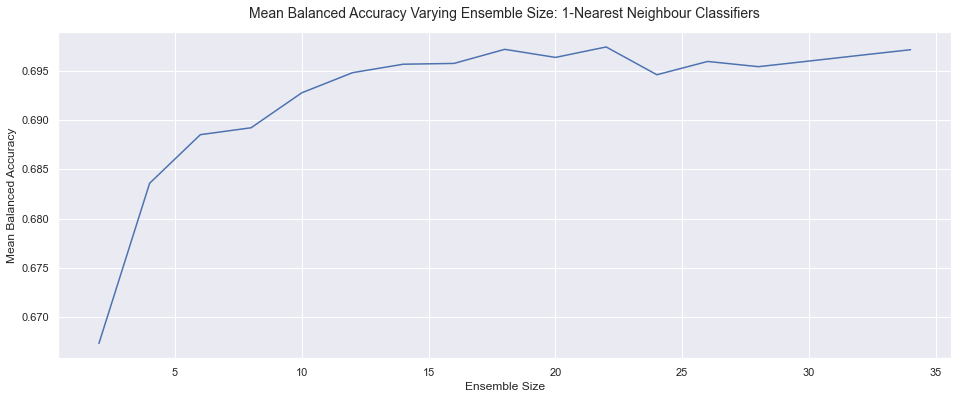

In [266]:
knnRSScoresVaryingEnsembleSize = RSVaryingEnsembleSizePrint("1-Nearest Neighbour Classifiers",knn, max=35)
RSVaryingEnsembleSizeGraph("1-Nearest Neighbour Classifiers",knnRSScoresVaryingEnsembleSize)

Once again our graph is the same for 1-NN random subspacing as it was for 1-NN bagging.

Again, the shape of the graph is very different for KNN and DTC ensembles. For KNN the BAR increases steadily as the ensemble size increases, however when it reaches the max BAR it stays very close to the value as we continue to increase the ensemble size, unlike the DTC ensemble which had a sharp drop in the BAR after the max was reached. So for the KNN ensemble by increasing the ensemble size we seem to converge at the highest BAR. The exact max is at ensemble size 22 so I will take this to be the best performing ensemble size.

This means that as we add more KNN classifiers to the ensemble the BAR increases. It reaches a max BAR at around 22 KNNs, and then stays close to this as we add more KNN classifiers. So unlike the DT ensemble we dont see a decrease BAR when we add more.

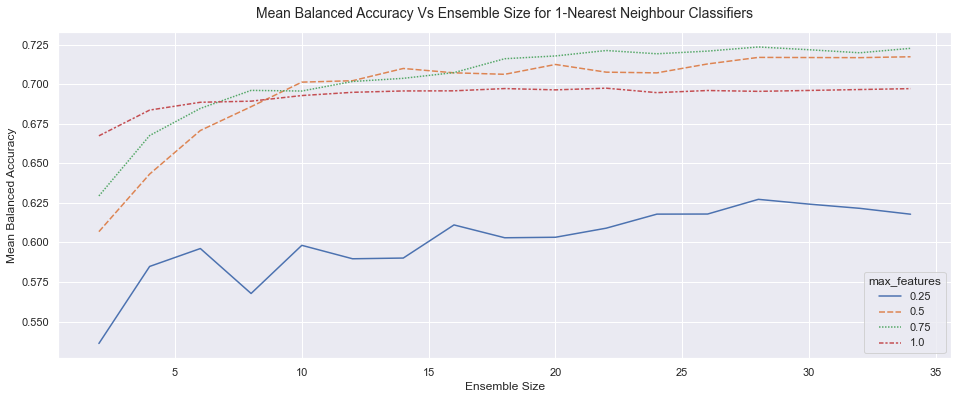

In [269]:
RSVaryingEnsembleSizeAndMaxFeatures(knn, max=35, classifierName = "1-Nearest Neighbour Classifiers")

As with the decision tree ensemble, for 1-NN the BAR values as we increase the ensemble size are very simialr for max_features 0.5, 0.75, 1.0, however much lower for max_features 0.25.

#### Ensemble random subspacing increasing ensemble size: Neural Network Classifiers

Neural Network Classifiers

Ensemble Size, Mean Balanced Accuracy
2 		 0.64573
4 		 0.64734
6 		 0.72473
8 		 0.716
10 		 0.72236
12 		 0.71479
14 		 0.70812
16 		 0.70258
18 		 0.69788


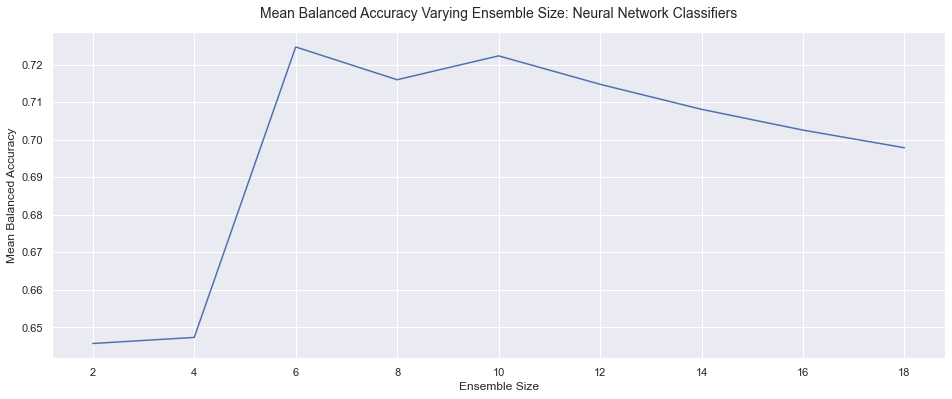

In [270]:
nnRSScoresVaryingEnsembleSize = RSVaryingEnsembleSizePrint("Neural Network Classifiers",nn, max=20)
RSVaryingEnsembleSizeGraph("Neural Network Classifiers",nnRSScoresVaryingEnsembleSize)

I'm graphing for a smaller number of ensemble sizes for the neural network as it takes much longer to run, and I don't excpet the direction of the slope to change drastically and start to increase if we increase the ensemble size further.

The graph is again the same as for bagging.

The graph for the neural network ensemble is similar to that of the decision tree. It increase steadily to reach the max BAR at ensemble size 6. We then see a fairly steady decrease as the ensemble size is further increased.

So this means that as we add more NNs to the ensemble the BAR increases. It reaches a max of 0.72473 at 6 NNs, and then the BAR decreases as we add more NNs.

Again, we will investigate for a few more values of max_features:

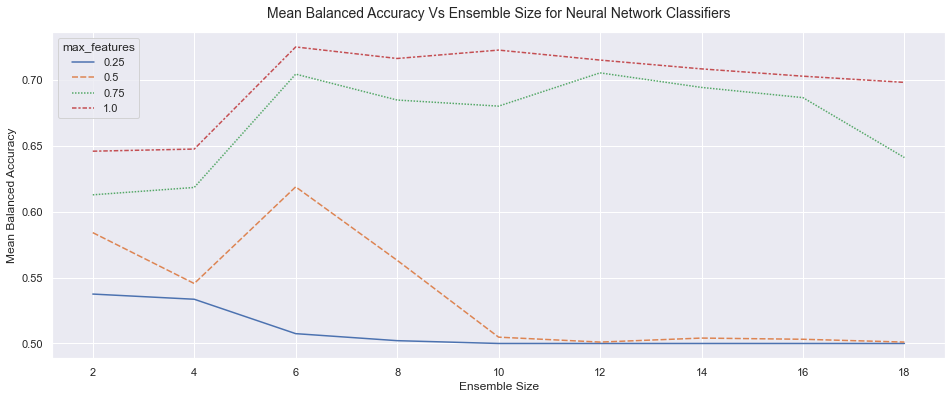

In [271]:
RSVaryingEnsembleSizeAndMaxFeatures(nn, max=20, classifierName = "Neural Network Classifiers")

Unlike the DTC and 1-NN ensembles in which the BAR values for increasifn ensemble sizes were very similar vor max_features of 0.5, 0.75, 1.0, for the neural network ensemble the vaslues and trends are very sifferent for each. The trends for 0.75 and 1.0 are fairly similar, but with higher BAR values for 1.0. The BAR is lowest for max_features 0.25. For max_features 0.5 the BAR is higher than for 0.25 for ensemble sizes below 10, but then drops to BAR values similar to that of max_features 0.25. We will investigate this more in the next section but it is clear that for the neural network ensemble, better performance is seen with more features. We also saw previously that the neural network performs better for bagging with more samples.

#### Ensemble Random Subspacing Varying Ensemble Size: Summary

The best ensemble sizes as well as the highest mean BAR for each ensemble are summarised below:

| Ensemble Classifier | Best Ensemble Size | Max Mean BAR | 
|----|----|---|
| Decision Tree Classifier | 10 | 0.71684 |
| 1-Nearest Neighbours Classifier | 22 | 0.69742 |
| Neural Network |6 | 0.72473 |

These results are the same as for Bagging.

#### Ensemble Random Subspacing - Varying max_features

Next we will vary the max_features parameter, with the best performing ensemble size as calculated above. 

Max_features is the number of features to train each base estimator on.

When max_features is a float, the number of features used for each estimator is max_features * total number of features. Say there are n features total. For the case of max_features = 1.0 we are choosing n features for each estimator, for max_features = 0.5 we are choosing 0.5n features, and so on. 

Because we are sampling without replacement, choosing max_samples=1.0 means that every classifier is trained on all of the features. There are no duplicates.

I will evalute the performance for max_features of 0.1, 0.2, 0.3, ...., 1.0. 

I will use the function I defined for bagging and pass in bagging = False to indicate Random Subspacing vary max_features instead of max_samples.

#### Ensemble Random Subspacing Varying max_features - Decision Tree Classifiers

Decision Tree Classifier

Ensemble Size, Mean Balanced Accuracy
0.1 		 0.5
0.2 		 0.55069
0.3 		 0.66217
0.4 		 0.70893
0.5 		 0.7146
0.6 		 0.71542
0.7 		 0.7163
0.8 		 0.7163
0.9 		 0.7163
1.0 		 0.71684


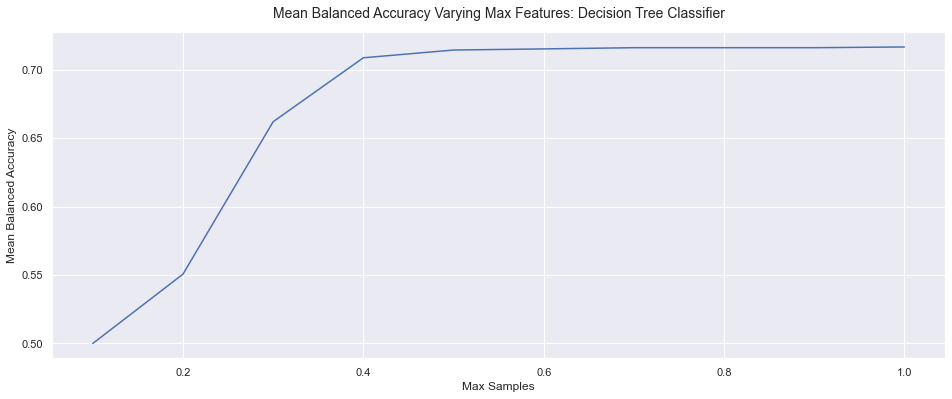

In [292]:
dtcRSScoresVaryingMaxFeatures = baggingVaryingMaxSamplesPrint("Decision Tree Classifier",dtc,10, bagging=False)
baggingVaryingMaxSamplesGraph("Decision Tree Classifier",dtcRSScoresVaryingMaxFeatures, bagging=False)

From the graph above we can clearly see that the decision tree ensemble performs best with more features. The highest BAR is seen when 100% of the features are used. In this case, the BAR is 0.71684. Although the BAR is technically highest for max_features 1.0, there isnt very much change in the BAR after max_features 0.7. When only half of the features are used, the ensemble performs no better than random (50%) on the training data. A rapid increase to a BAR of 0.7 is seen from max_features 0.1 to 0.4.

Since the highest BAR is seen for max_features 1.0 I will choose this as the best performing value, although I think choosing a smaller value with  a very similar BAR such as 0.7 would not make a huge difference, and could even potentially perform better on the unseen data as less features means less complexity and therefore less potential for overfitting. 

However since 1.0 technically yields the highest BAR I will go with this.

It is interesting to see that the DTC ensemble performs better with more feastures, but with less samples, as we saw previously for bagging, which had the highest BAR for max_samples of 0.3.

#### Ensemble Random Subspacing Varying max_features - 1-Nearest Neighbours Classifiers

1-Nearest Neighbours Classifier

Ensemble Size, Mean Balanced Accuracy
0.1 		 0.50372
0.2 		 0.55756
0.3 		 0.64221
0.4 		 0.69524
0.5 		 0.70754
0.6 		 0.71893
0.7 		 0.71502
0.8 		 0.71095
0.9 		 0.70141
1.0 		 0.69742


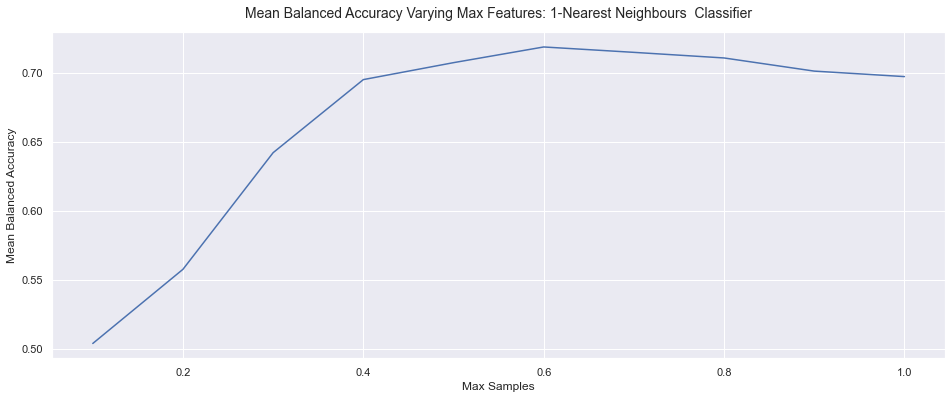

In [295]:
knnRSScoresVaryingMaxFeatures = baggingVaryingMaxSamplesPrint("1-Nearest Neighbours Classifier",knn, 22, bagging=False)
baggingVaryingMaxSamplesGraph("1-Nearest Neighbours  Classifier",knnRSScoresVaryingMaxFeatures, bagging=False)

The graph for the 1-NN ensemble is very similar to that of the DTC-ensemble. For max_samples 0.1 the ensemble is just better than random (BAR 0.50372). There is a steep increase to the max BAR of 0.71893 for max_features 0.6. Following this there is a very gradual decrease to a BAR of 0.69742 for max_features 1.0.

Overall, the 1-NN ensemble performs better with more features.

#### Ensemble Random Subspacing Varying max_features - Neural Network Classifiers

Neural Network Classifier

Ensemble Size, Mean Balanced Accuracy
0.1 		 0.5
0.2 		 0.5
0.3 		 0.5
0.4 		 0.5
0.5 		 0.61871
0.6 		 0.66781
0.7 		 0.5
0.8 		 0.71181
0.9 		 0.72105
1.0 		 0.72473


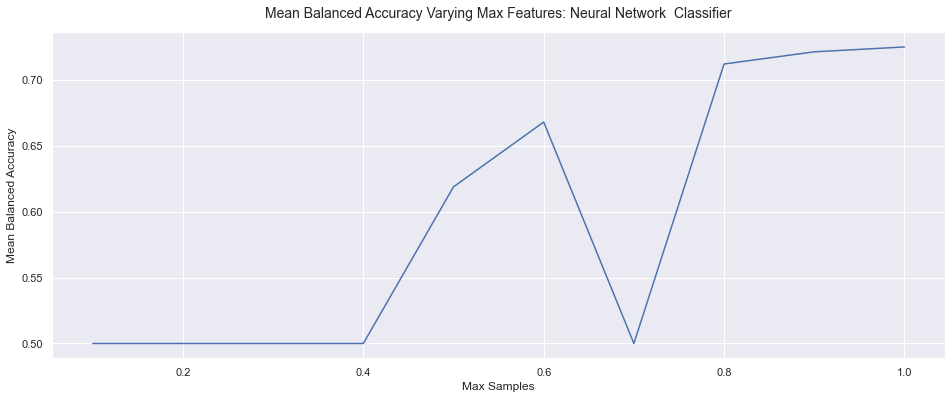

In [296]:
nnBaggingScoresVaryingMaxSamples = baggingVaryingMaxSamplesPrint("Neural Network Classifier",nn, 6, bagging=False)
baggingVaryingMaxSamplesGraph("Neural Network  Classifier", nnBaggingScoresVaryingMaxSamples, bagging=False)

Once again, we can immediately see that the NN ensemble performs better with more features. The classifier is no better than random for less than or equal to 40% of features (BAR 0.5). There is a sharp increase to a BAR of 0.66781 for max_features 0.6, a drop back to BAR 0.5 for max_feastures 0.7, and then an increase to a max BAR of 0.72473 when all features are used (max_features 1.0).

#### Ensemble Random Subspacing Varying max_features: Summary

| Ensemble Classifier | Best Max Samples | Max Mean BAR | 
|----|----|---|
| Decision Tree Classifier | 1.0 | 0.71684 |
| 1-Nearest Neighbours Classifier | 0.6 | 0.71893 |
| Neural Network | 1.0 | 0.72473 |

Both the DTC and NN ensembles perform best with all features. 1-NN ensemble performs best with 60% of features. Overall, the NN has the highest mean BAR on the training data, followed by the 1-NN and DTC which have very similar mean BARs.

Next I will fit each of the ensembles using the optimal ensemble size and max_features on the training data, predict using the test data, calculate the BAR for each, and these will be used later for the comparison.

#### Fit and Predict using Ensembles with best performing ensemble size and number of features - Random Subspacing
#### Decision Tree Ensemble

In [298]:
dtc_RS = BaggingClassifier(dtc, 
                            n_estimators = 10,
                            max_features = 1.0, 
                            random_state=1)
dtc_RS.fit(X_train, y_train)
pred = dtc_RS.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7091734432438455

#### 1-Nearest Neighbours Ensemble

In [302]:
knn_RS = BaggingClassifier(knn, 
                            n_estimators = 22,
                            max_features = 0.6, 
                            random_state=1)
knn_RS.fit(X_train, y_train)
pred = knn_RS.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.6942826111172997

#### Neural Network Ensemble

In [304]:
nn_RS = BaggingClassifier(nn, 
                            n_estimators = 6,
                            max_features = 1.0,
                            random_state=1)
nn_RS.fit(X_train, y_train)
pred = nn_RS.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7232483012142141

#### Ensemble Random Subspacing Summary: BAR on unseen test data
    
| Ensemble Classifier | BAR |  
|----|----|
| Decision Tree Classifier | 0.709 |  
| 1-Nearest Neighbours Classifier | 0.694 | 
| Neural Network | 0.723 | 

## Comparison

As we saw previously, for the basic classifiers (with little to no tuning as these just needed to be better than random), the Neural Network perormed the best on the test data with a BAR of 0.76, followed by the DTC with a BAR of 0.709, and then the 1-NN with a BAR of 0.66. Its not too surprising that the NN performed the best, as I did no tuning for the DTC and 1-NN, however for the NN it was required that there be at most 10 hidden nodes, so I found the best combination of the number of nodes in each layer that would sum to a total of 10 or less, so some tuning was done here. I didn't bother tuning the other 2 classifiers as they were already better than random and met the requirements (max depth and number of neighbours requirements) without tuning.

#### Basic Classifiers Summary - BAR on test data
| Classifier | BAR on test data | 
|----|----|
| Decision Tree Classifier  | 0.709 |
| 1-Nearest Neighbours Classifier | 0.66 |
| Neural Network | 0.76 |

When we then calculated the best ensemble size for each of the classifiers, its interesting to see that the BAR for the training data increased from the BAR from the test data for the individual classifiers for the DTC and 1-NN, however it decreased for the NN classifier ensemble. We will see this more clearly when comparing with the ensembles on the test data but it is interesting to note. The ordereding of the best ensemble is still the same as that of the base classifiers, with the NN ensemble performing the best, followed by the DTC and then the 1-NN.

#### Ensemble Bagging/Random Subspacing Varying Ensemble Size Summary - BAR on training data

The best ensemble sizes as well as the highest mean BAR for each ensemble are summarised below:

| Ensemble Classifier | Best Ensemble Size | Mean BAR on training data | 
|----|----|---|
| Decision Tree Classifier | 10 | 0.71684 |
| 1-Nearest Neighbours Classifier | 22 | 0.69742 |
| Neural Network |6 | 0.72473 |


When we then tuned the number of samples, the BAR further increased for each ensemble on the training data, with the DTC and 1-NN ensembles now having very similar BARs of 0.723 and 0.721 respectively, and the NN ensemble still having the highest BAR of 0.729.

#### Ensemble Bagging Varying max_samples Summary - BAR on training data

| Ensemble Classifier | Best Max Samples | Mean BAR on training data | 
|----|----|---|
| Decision Tree Classifier | 0.3 |  0.72308 |
| 1-Nearest Neighbours Classifier | 0.2 | 0.72161 |
| Neural Network | 0.5| 0.72857 |

Now that the ensemble size and max_samples were both tuned, we tested the classifiers with the tuned parameter values on the test data. Interestingly, all 3 classifiers now had very simialr BARs despite the very big difference in the BARs for the base classifiers. It is also very interesting to note that the performance for the NN ensemble was worse than the base NN classifier. the base classifier had a BAR of 0.76, but the ensemble had a BAR of only 0.723. For the DTC, the base classifier had a BAR of 0.709, and using the bagging ensemble improved the performance to a BAR of 0.721. The biggest increase was seen for the 1-NN classifier. The base classifier had a BAR of only 0.66, wherease the ensemble had a BAR of 0.721. The results for the 1-NN ensemble espically highlights the idea of a committee of weak learners performing better than the individual weak learners, which is the main idea behind ensembles. It is strange that the NN performed worse than the base classifier. It is posibly due to a lack of diversity. The largest number of samples were chosen for the NN classifier, which might mean that a lot of the same samples were chosen for each classifier. Furthermore less classifiers were used in comparison to the other 2 ensembles. This might have caused a lack of diversity. 

#### Ensemble Bagging Summary: BAR on test data

| Ensemble Classifier | BAR on test data |  
|----|----|
| Decision Tree Classifier | 0.721 |  
| 1-Nearest Neighbours Classifier | 0.721 | 
| Neural Network | 0.723 | 

We also looked at Random Subspacing. The ensemble sizes chosen for each ensemble were the same as for bagging. We then tuned the number of features. Both the DTC and NN ensembles used all of the features, and the 1-NN ensemble used 60% of the features. The NN ensemble performed the best on the training data with a BAR of 0.72, followed by the 1-NN classifier with a BAR of 0.719 and the DTC with a BAR of 0.717. In this case the ordering is not the same as the performance ordering for the base classifiers, as the DTC base classifier had performed better than the 1-NN.

#### Ensemble Random Subspacing Varying max_features Summary - BAR on training data

| Ensemble Classifier | Best Max Features | Mean BAR on training data | 
|----|----|---|
| Decision Tree Classifier | 1.0 | 0.71684 |
| 1-Nearest Neighbours Classifier | 0.6 | 0.71893 |
| Neural Network | 1.0 | 0.72473 |

We then once again tested these ensembles on the test data using the tuned parameters. The BAR was highest for the NN ensemble. The BAR for the NN ensemble was the same as that of the BAR for bagging, which was 0.723, and which as we noted previosuly is less than the BAR for the underlying base classifier. The BAR was only slightly lower than the BAR on the test data so the NN ensemble generalises well. The BAR for the DTC was 0.709, which was the same as the BAR for the udnerlying classifier, but which was less than the BAR for bagging which was 0.721. The reason we saw no improvement from the base classifier was possibly due to an overly complex model due to all features and all samples being used (max_features 1.0, max_samples 1.0) which could lead to over fitting. Furthermore, having max_features of 1.0 and max_samples of 1.0 means that there is very little diversity. All base classifiers are trained on the same features, and likely a lot of the same samples (not the exact same due to sampling with replacement). Thus there is a lack of diversity. The BAR was lower than the BAR on the test data (0.71684) so the classifier does not generalise particularly well to unseen data. The BAR was lowest for the 1-NN classifier. It was 0.694, which is only slightly higher than the BAR of the base classifier of 0.66. The BAR is significantly lower than the BAR on the traning data (0.71893) so this classifier does not generalise well. 

#### Ensemble Random Subspacing Summary: BAR  on test data
    
| Ensemble Classifier | BAR on test data |  
|----|----|
| Decision Tree Classifier | 0.709 |  
| 1-Nearest Neighbours Classifier | 0.694 | 
| Neural Network | 0.723 | 


### Summary of Results

Below is a summary of the results showing the BAR for the base classifiers, the best ensemble technique (bagging vs random subspacing) for each classifier, the parameters, and the BAR for the ensembles using the best perfoming techniques (bagging vs random subspacing)

| Classifier | Base Classifier BAR | Best Ensemble Technique | Parameters | Ensemble BAR | 
|---|---|---|---|---|
| Decision Tree Classifier  | 0.709 | Bagging | ensemble size 10, max samples 0.2  |0.721 |
| 1-Nearest Neighbours Classifier | 0.66 | Bagging | ensemble size 22, max samples 0.3| 0.721|
| Neural Network | 0.76 |Bagging / Random Subspacing | ensemble size 6, max samples 0.5 or max_features 1.0| 0.723 |


I find some of these results very surprising. In the lectures we learned that __Bagging typically works best for unstable classifiers__. Unstable classifier are highly sensitive to the training data and often don't generalise as well for unseen data. Decsision Trees and Neural Networks are both unstable classifiers. 

The reason why bagging can typically improve performance is because such classifiers, such as decision trees, are sensitive to the specific data on which they are trained, so if the training data is changed, for example if a tree is trained on a subset of the training data, then the resulting decision tree can be quite different and in turn the predictions can be quite different. So training the trees on different subsets can improve diversity.

We learned that __feature subspacing, however, works best for stable classifiers__ such as KNN. KNN is stable with respect to the variations in the training data. Random subspacing causes individual learners to not over-focus on features that appear highly predictive/descriptive in the training set, but fail to be as predictive for points outside that set. It is therefore surprising that the KNN ensemble performed better for the bagging ensemble than the random subspacing. 

I think that there is quite a lot of diversity since 20% and 30% of the total number of samples are chosen for each classifier for DTC and 1-NN ensembles, which should mean that quite different predictions are made for the different subsets (fot the DTC emseble espically since DTC are unstable). For the NN ensemble we saw the same BAR for bagging an random subspacing. There is very little diversity for the random subspacinf since all features are used (and total number of samples since max_samples was at default 1.0 for random subspacing). For bagging however there was more diversity as each classifier was trained on 50% of the number of samples, which should encourage diversity. I am therefore surprised that the results were the same for both technqiues, I would have expected a higher BAR for bagging.

One possible thing that we could try to further increase the diversity would be to apply bagging AND feature subspacing. I will try this for 1-NN using the max_samples and max_features values calculated above:

In [307]:
knn_RS_Bagging = BaggingClassifier(knn, 
                            n_estimators = 22,
                            max_samples = 0.2,
                            max_features = 0.6, 
                            random_state=1)
knn_RS_Bagging.fit(X_train, y_train)
pred = knn_RS_Bagging.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.683151386877576

Surprsingly this performs worse than the individual random subspacing and bagging. There is not point in applying both for NN and DTC for the values that we calculated as we found max_features 1.0 to be the best, which would be the same as just applying bagging as this is the defualt value.

### Boosting 

A different approach that we could try is __boosting__.

Boosting refers to a group of algorithms that utilize weighted averages to make weak learners into stronger learners. Unlike bagging in which each model runs independently and then aggregates the outputs at the end, boosting is more focused on “teamwork”, in which each model runs and then dictates what features the next model will focus on. Boosting trains a sequence of classifiers, one after another, so that later classifiers are trained to better predict class labels for examples that earlier ones performed poorly on. The errors which one clasifier made are identified, and the next classifier focuses on correctly classifying those difficult examples. Boosting could generate a combined model with lower errors as it optimises the advantages and reduces pitfalls of the single model. Boosting can often reduce variance and bias, since it focuses on misclassified examples, however it may sometimes increase error, as it is susceptible to noise, which can lead to overfitting. However, we can investigate if in this case Boosting is a better option.

There are a number of boosting algorithms, such as Ada Boost and Gradient Boost, which different in the way that they increase the weights for missclassified examples. I will apply Ada Boost.

#### Ada Boost

As with the bagging and random subspacing, we can find the best performing ensemble size. We can then also find the best learning rate. The learning rate is the weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier.

In [350]:
# function to calculate mean BAR for varying ensemble sizes
# returns dict where keys are ensemble sizes and corresponding values are mean BARs

def AdaBoostVaryingEnsembleSize(classifier, min=2, max=20, step=2):
    
    # dict to hold ensemble size : mean balance accuracy score
    EnsembleSize_MeanBalancedAccuracy = {}
    
    # iterate through increasing ensemble sizes, default from 0-20 with steps of size 2
    for i in range(min, max, step):
        
        dtc_bag = AdaBoostClassifier(classifier, 
                                n_estimators = i, 
                                random_state=1)

        # cross val
        scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, 
                                          cv=10, verbose = 0, n_jobs = -1, 
                                          scoring="balanced_accuracy")
        
        # extract scores, get mean, set ensemble size : mean balance accuracy score in dict
        EnsembleSize_MeanBalancedAccuracy[i] = round(scores_tree_bag.mean(), 5)

    return EnsembleSize_MeanBalancedAccuracy

# function to print highest value and corresponding key in a dictionary
def HighestValue(d):
    print(pd.Series(d).sort_values(ascending=False).head(1))

In [351]:
# function to calculate mean BAR for varying learning rates
# returns dict where keys are ensemble sizes and corresponding values are mean BARs

def AdaBoostVaryingLearningRate(classifier, n_estimators):
    
    # dictionary to hold ensemble size : mean BAR
    dic = {}
    
    # iterate through max samples  0.1, 0.2, .., 1.0
    for i in np.linspace(0,1,11):
        
        i=round(i, 3) # round
        if i>0: 

            dtc_bag = AdaBoostClassifier(classifier, 
                                    n_estimators = n_estimators, 
                                    learning_rate=i,
                                    random_state=1)
        

            # cross val
            scores_tree_bag = cross_val_score(dtc_bag, X_train, y_train, 
                                              cv=10, verbose = 0, n_jobs = -1, 
                                              scoring="balanced_accuracy")

            # add to dictionary
            dic[i] = round(scores_tree_bag.mean(), 5)

    return dic

#### Ada Boost - Decision Tree Ensemble

I won't bother with graphing all the values again and looking at the trends as before. I will just calculate the best performing ensemble size, and corresponding best learning rate.

In [349]:
HighestValue(AdaBoostVaryingEnsembleSize(dtc, min=2, max=20, step=2))

18    0.77811
dtype: float64


In [321]:
HighestValue(AdaBoostVaryingLearningRate(dtc, 18))

0.7    0.78129
dtype: float64


For the decision tree ensemble, the best ensemble size is 18 and best learning rate is 0.7. We can now fit the ensemble and calculate the BAR on the test data.

In [323]:
dtc_Ada = AdaBoostClassifier(dtc, 
                             n_estimators = 18, 
                             learning_rate=0.7,
                             random_state=1)

dtc_Ada.fit(X_train, y_train)
pred = dtc_Ada.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7644981619694775

The results are significantly higher better than the individual classifier and the bagging ensemble. the individual classifier had a BAR of 0.709, the bagging had a BAR of 0.721, and now the Ada boosting has a BAR of 0.76. 

#### Ada Boost - Neural Network Ensemble 

The sklearn MLPClassifier does not support sample_weights which is needed for Ada Boost. I found a custom MLP Classifier fuction online which I am going to use to create a new MLP classifier which supports this:

In [334]:
class customMLPClassifer(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)

        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

We can now fit this custom MLP classifier as before:

In [338]:
nn2 = customMLPClassifer(random_state=1,hidden_layer_sizes = [1, 2, 3, 4], max_iter=600).fit(X_train, y_train)
predictions = nn2.predict(X_test)
balanced_accuracy_score(y_test, predictions)

0.775799264787791

The balanced accuracy is similar to that of the original neural network classifier (which was 0.7553330). I will now use this new classifier for the Ada Boost and see if there is an improvement in performance.

In [339]:
HighestValue(AdaBoostVaryingEnsembleSize(nn2, min=2, max=20, step=2))

2    0.77211
dtype: float64


In [340]:
HighestValue(AdaBoostVaryingLearningRate(nn2, 2))

0.9    0.77395
dtype: float64


The best ensemble size is 2 and best learning rate is 0.9.

In [341]:
nn_Ada = AdaBoostClassifier(nn2, 
                             n_estimators = 2, 
                             learning_rate=0.9,
                             random_state=1)

nn_Ada.fit(X_train, y_train)
pred = nn_Ada.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7484571683190375

The results show a BAR of 0.75 on the unseen data. This is better than the bagging and random subspacing, which both had a BAR of 0.72. However this is still not as good as the individual classifier which had a BAR of 0.76.

#### 1-Nearest Neighbours Classifier

Sklearn's Ada Boost also doesn't work for standard KNN. However the bagging already improved the performance of KNN in comparison to the base classifier so I'm not going to try write a custom KNN for this and apply ada boost.

#### Ada Boost Summary

| Ensemble Classifier | BAR |
|---|---|
|Decision Tree | 0.76 |
|Neural Network | 0.75 |

For Ada Boost the Decision Tree ensemble performs better than the neural network despite the neural network having a better base classifier.

#### Bagging and Feature Subspacing Grid Search Parameter Tuning

Another thing that we could try to improve performance would be to use grid search cross validation to find the best ensemble size and max samples/features for bagging/feature subspacing as opposed to finding the best ensemble size on its own and then finding the best samples/features for that ensemble size. This will find the best pair of ensemble size, max samples/features.

#### Grid Search Parameter Tuning - Decision Tree Ensemble

In [102]:
#create new a knn model
baggingGridSearchDTC = BaggingClassifier(dtc)

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_estimators': np.arange(1, 30), 'max_samples' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

#use gridsearch to test all values for n_neighbors
dtcBagging_gscv = GridSearchCV(baggingGridSearchDTC, param_grid, cv=5, scoring="balanced_accuracy")

#fit model to data
dtcBagging_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
dtcBagging_gscv.best_params_

{'max_samples': 0.3, 'n_estimators': 8}

In [359]:
dtc_bag_gscv = BaggingClassifier(dtc, 
                            n_estimators = 5,
                            max_samples = 0.5,
                            random_state=1)
dtc_bag_gscv.fit(X_train, y_train)
pred = dtc_bag_gscv.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7098278935056255

In [360]:
#create new a knn model
baggingGridSearchDTC = BaggingClassifier(dtc)

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_estimators': np.arange(1, 30), 'max_features' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

#use gridsearch to test all values for n_neighbors
dtcBagging_gscv = GridSearchCV(baggingGridSearchDTC, param_grid, cv=5, scoring="balanced_accuracy")

#fit model to data
dtcBagging_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
dtcBagging_gscv.best_params_

{'max_features': 1.0, 'n_estimators': 3}

In [363]:
dtc_bag_gscv = BaggingClassifier(dtc, 
                            n_estimators = 3,
                            max_features = 0.1,
                            random_state=1)
dtc_bag_gscv.fit(X_train, y_train)
pred = dtc_bag_gscv.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.548936170212766

I am surprised by these results. Using the parameters for grid search cross validation yielded a BAR the same as the base classifier for bagging (0.709), and a far worse BAR for random subspacing of 0.55, which is only 0.05 better than random.

#### Grid Search Parameter Tuning - 1-Nearest Neighbour Ensemble

In [100]:
#create new a knn model
baggingGridSearchDTC = BaggingClassifier(knn)

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_estimators': np.arange(1, 30), 'max_samples' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

#use gridsearch to test all values for n_neighbors
dtcBagging_gscv = GridSearchCV(baggingGridSearchDTC, param_grid, cv=5, scoring="balanced_accuracy")

#fit model to data
dtcBagging_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
dtcBagging_gscv.best_params_

{'max_samples': 0.2, 'n_estimators': 21}

In [98]:
knn_bag_gscv = BaggingClassifier(knn, 
                            n_estimators = 25,
                            max_samples = 0.1,
                            random_state=1)
knn_bag_gscv.fit(X_train, y_train)
pred = knn_bag_gscv.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7104906984515985

In [365]:
#create new a knn model
baggingGridSearchDTC = BaggingClassifier(knn)

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_estimators': np.arange(1, 30), 'max_features' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

#use gridsearch to test all values for n_neighbors
dtcBagging_gscv = GridSearchCV(baggingGridSearchDTC, param_grid, cv=5, scoring="balanced_accuracy")

#fit model to data
dtcBagging_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
dtcBagging_gscv.best_params_

{'max_features': 0.5, 'n_estimators': 27}

In [99]:
knn_bag_gscv = BaggingClassifier(knn, 
                            n_estimators = 27,
                            max_samples = 0.5,
                            random_state=1)
knn_bag_gscv.fit(X_train, y_train)
pred = knn_bag_gscv.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.6697421187479113

I am again surprised by these results. Using the parameters for grid search cross validation yielded a BAR above the base classifier (0.66) of 0.71 for bagging, and just barely above it at 0.67 for random subspacing. 

So it seems that using the grid search cross validation does not improve performance. I'm not going to test this for the neural network as I tried and it ran for about an hour before crashing my laptop, but judging by the performance for the DTC and KNN I a doubtful that it will help.

#### Stacked Ensemble

One last thing that we can try to improve performance is use a stacked ensemble. Here we will create an insemble with the decision tree, the 1-nearest neighbour and the neural network base classifiers. The output of each of these individual classifiers serves as input to a LogisticRegression (by default) classifier. We can see how this compares to our other methods:

In [108]:
stackedEnsemble = StackingClassifier(estimators=[('dtc',dtc), ('knn',knn), ('nn',nn)])

stackedEnsemble.fit(X_train, y_train)
pred = stackedEnsemble.predict(X_test)
balanced_accuracy_score(y_test, pred)

0.7582794920352011

The BAR is 0.76 which is higher than the BAR for the underlying DTC and KNN, and the same as the BAR for the NN. This is also the same as the BAR for the best performing ensemble method for DTC, and higher than the BARs for the best performing ensemble methods for the KNN and NN ensembles (see table below). Thus this is one of the best performing methods which we have encountered so far in this assignment.

### Full Results Summary

The full table of results for each classifier are now summarised below.

|Classifier | Base Classifier BAR | Bagging BAR | Random Subspacing BAR | Ada Boost BAR | Best Ensemble Technique | Best BAR |
|---|---|---|---|---|---|---|
| Decision Tree Classifier  | 0.709 | 0.721 | 0.709 | 0.76 | Ada Boost |0.76 |
| 1-Nearest Neighbours Classifier | 0.66 | 0.721 | 0.694 |  | Bagging | 0.721|
| Neural Network | 0.76 |  0.723 |  0.723 | 0.75 | Ada Boost | 0.75 |

|Stacked Ensemble|
|---|
|0.76|

#### Parameter Tuning Base Classifiers

The final step is to tune the base classifiers and compare these to the ensembles. This will indicate whether more improvement for the weak base classifiers will be found through tuning the parameters or through combining many weak base classifiers into a stronger ensemble.

Tuning too many parameters may make the model too complex and lead to low accuracy on the test data so I will only tune a few key parameters.

#### Parameter Tuning Decision Tree 

For the decision tree I will tune the criterion and the max depth:

In [139]:
parameters = {'criterion':  ['gini', 'entropy'], 
              'max_depth' : [2,4,6,8,10,12]
             }

dtc_tuned = DecisionTreeClassifier()

clf_GS = GridSearchCV(dtc_tuned, parameters, scoring="balanced_accuracy")

clf_GS.fit(X_train, y_train)
clf_GS.best_params_

{'criterion': 'gini', 'max_depth': 12}

In [140]:
dtc_tuned = DecisionTreeClassifier(max_depth=12, 
                                   criterion='entropy', 
                                   random_state=1).fit(X_train, y_train)

predictions = dtc_tuned.predict(X_test)
balanced_accuracy_score(y_test, predictions)

0.7435501838030523

#### Parameter Tuning K-Nearest Neighbours

For the knn classifier I will tune the number of neighbours and the power parameter for the Minkowski metric.

In [148]:
parameters = {'n_neighbors' : [1, 3, 5, 7, 9, 11, 13, 15],
              'p' : [1, 2, 3, 4, 5]
             }

knn_tuned = KNeighborsClassifier()

clf_GS = GridSearchCV(knn_tuned, parameters, scoring="balanced_accuracy")

clf_GS.fit(X_train, y_train)
clf_GS.best_params_

{'n_neighbors': 15, 'p': 3}

In [147]:
knn_tuned = KNeighborsClassifier(n_neighbors=15, p=3).fit(X_train, y_train)

predictions = knn_tuned.predict(X_test)
balanced_accuracy_score(y_test, predictions)

0.7185111952768186

#### Parameter Tuning Neural Network

I already carefully tuned the neural network to find the best configuration of the number of nodes per hidden layer that are max 10 in total. Those I won't re-tune this. I will tune the solver for weight optimixation and the activation function for the hidden layers.

In [155]:
parameters = {'solver' : ['sgd', 'adam'],
              'activation' : ['identity', 'logistic', 'tanh', 'relu']
             }

nn_tuned = MLPClassifier(hidden_layer_sizes = [1, 2, 3, 4], max_iter=1000)

clf_GS = GridSearchCV(nn_tuned, parameters, scoring="balanced_accuracy")

clf_GS.fit(X_train, y_train)
clf_GS.best_params_

{'activation': 'tanh', 'solver': 'adam'}

In [151]:
nn_tuned = MLPClassifier(random_state=1,
                   hidden_layer_sizes = [1, 2, 3, 4], 
                   solver='adam',
                   activation='relu',
                   max_iter=600
                  ).fit(X_train, y_train)


predictions = nn_tuned.predict(X_test)
balanced_accuracy_score(y_test, predictions)

0.775799264787791

### Summary of Parameter Tuning

The results of the parameter tuning are shown below:

| Classifier | Parameters | BAR on test data | 
|---|---|---|
| Decision Tree | {'criterion': 'gini', 'max_depth': 12} | 0.744 |
| K-Nearest Neighbours | {'n_neighbors': 15, 'p': 3} | 0.719 |
| Neural Network | {'activation': 'tanh', 'solver': 'adam'} | 0.776 |

### Full Results Summary

For comparison I will also show the previous results table.

|Classifier | Base Classifier BAR | Bagging BAR | Random Subspacing BAR | Ada Boost BAR | Best Ensemble Technique | Best BAR |
|---|---|---|---|---|---|---|
| Decision Tree Classifier  | 0.709 | 0.721 | 0.709 | 0.76 | Ada Boost |0.76 |
| 1-Nearest Neighbours Classifier | 0.66 | 0.721 | 0.694 |  | Bagging | 0.721|
| Neural Network | 0.76 |  0.723 |  0.723 | 0.75 | Ada Boost | 0.75 |

For the Decision Tree classifier, the parameter tuning (BAR 0.744) better improved the performance than the bagging (0.721) or random subspacing (0.709) ensembles, and was also better than the performance for the un-tuned base classifier (0.709). The performance after tuning was not better than the Ada Boost performance however (0.76).


For the k-nearest neighbours, the parameter tuning (BAR 0.719) performed better than the un-tuned classifier (0.66), and better than the random subspacing (0.694), however not as good as the bagging ensemble (0.721).

For the neural network, the tuned classifier (BAR 0.776) was better than the base classifier (0.76), better than bagging and randomsubspacing (both 0.723), and better than the Ada Boost.

#### Final Summary of the best approach to improve each un-tuned base classifier:


| Classifier | Original BAR | Best Approach | BAR on test data | 
|---|---|---|---|
| Decision Tree |0.71 | Ada Boost Ensemble | 0.76 |
| K-Nearest Neighbours | 0.66 | Bagging Ensemble | 0.72 |
| Neural Network | 0.76 | Parameter Tuning | 0.78 |

So, the neural network performs better with parameter tuning than an ensemble. Part of this could be down to the fact that I tuned the hidden layer sizes at the beginning. I wasn't sure of the approach we were supposed to use - tuning using an approach such as grid search, or trial and error to find a combination that resulted in a better than random classifier, etc. 

The decision tree performs best with the Ada Boost ensemble, and following this the parameter tuning was best.

Finally, the k-nearest neighbours classifier performs best with the ensemble bagging. Once again I find this very surprising since bagging typically works better for unstable classifiers, which KNN is not. According to Data Mining: Practical machine learning tools and techniques, Morgan Kaufmann, 2016 "it is pointless to bag nearest-neighbor classifiers because their output changes very little if the training data is perturbed by sampling" so I find it really surprising that this was the best method for improving the performance of the base classifier.

Overall this was an extremely interesting and enjoyable assignment. It was very interesting to see how differently the different classifiers performed for the various ensemble methods, and how base classifiers which had very different balanced accuracy scores could have very similar scores for their ensembles. A lot of the results were as expected based on my understanding of the lectures and additional reading, and some of the results were not what I expected (such as bagging being the best method for KNN). 

## Question 2:


__<font color='red' size=3.5>(a) Emma took a rapid antigen test for SARS-CoV-2 (popularly called Covid-19) and her test came out positive. The particular brand of antigen test that she used claims that in their clinical study, the test showed a sensitivity of 0.825 and a specificity of 1.00. Assuming that their claimed numbers are true and given that she has been tested positive, what is the probability that she is actually positive for SARS-CoV-2? [10 marks]</font>__

For this question I was using a lot of fractions which are easier to do in word than  markdown so I have embedded images of the word doc. The document was 3 pages long so I have included 3 images below:

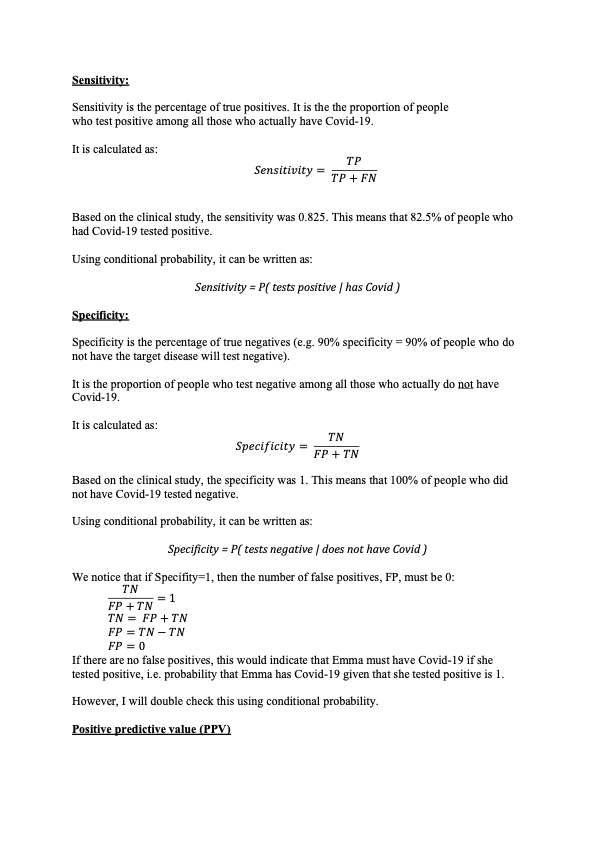

In [167]:
PATH="/Users/DervlaScully/OneDrive - University College Dublin/Final Year/Modules/Machine Learning COMP47490/Assignment 2/"

Image(filename = PATH + "Q2a1.png", width=800, height=800)


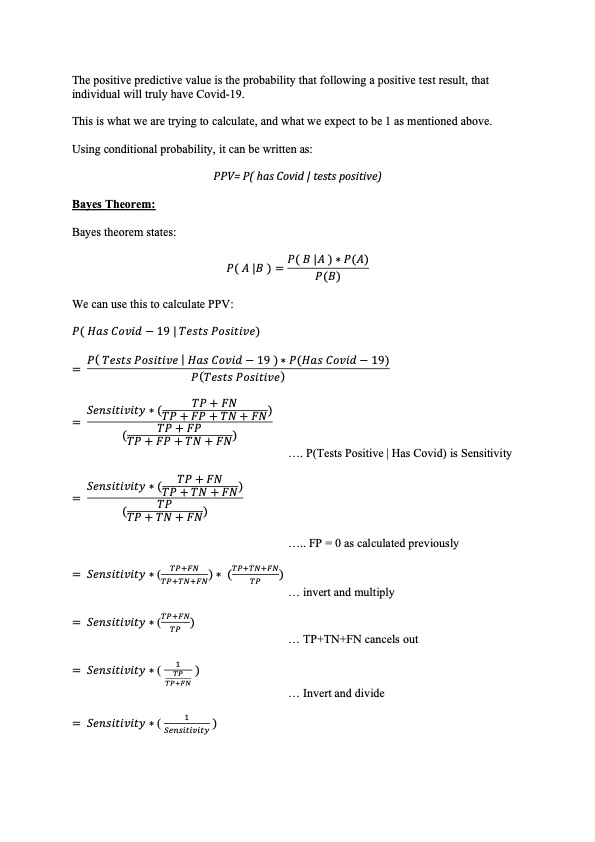

In [168]:
Image(filename = PATH + "Q2a2.png", width=800, height=800)

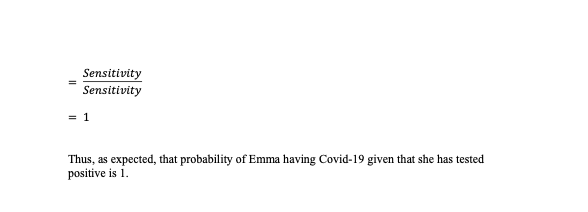

In [169]:
Image(filename = PATH + "Q2a3.png", width=800, height=800)

__<font color='red' size=3.5>(d)  Unlike the batch gradient descent, the stochastic gradient descent is not guaranteed to monotonically improve the cost function. And, yet, in applications involving large datasets, it is often preferred over the batch gradient descent. 
Why?</font>__


There are a number of forms of gradient descent, such as Batch, Mini Batch, and Stochastic.

In Batch Gradient Descent, all the training data is taken into consideration to take a single step. We take the average of the gradients of all the training examples and then use that mean gradient to update the parameters.  Batch gradient descent is guarnteed to monotonically decrease (i.e. improve) the cost function. By monotonically decreasing we mean that after each iteration the cost function is either less than or equal to the previous, that is 𝑥≤𝑦⇒cost(𝑥)≤cost(𝑦). This can be proven (such proofs can be found here:  https://www.cs.cornell.edu/courses/cs4787/2021sp/lectures/Lecture3.pdf  and here https://raghumeka.github.io/CS289ML/gdnotes.pdf ). A visualisation of this is shown below, which shows that the cost function decreases monotonically after each iteration:


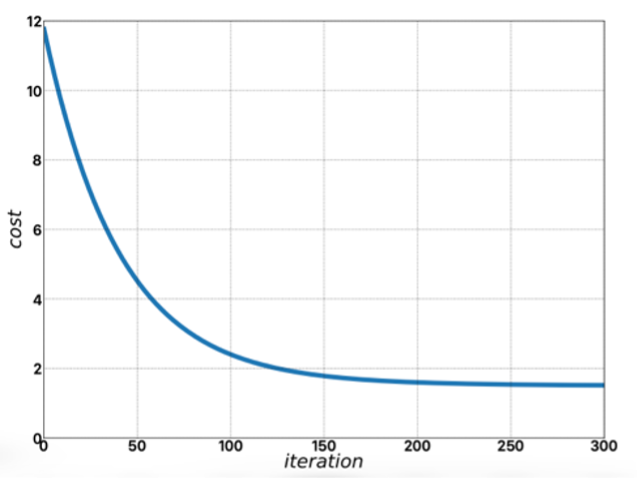

In [172]:
Image(filename = PATH + "CostIterations.png", width=400, height=400)

There are issues with batch gradient descent for large datasets, due to the need to calculate the gradient for each example on each iteration. Firstly, the entire training set can be too large to process in the memory due to which additional memory might be needed. Furthermore, depending on computer resources it can take too long for processing all the training samples as a batch. This leads on to an alternative approach which overcomes these issues: Stochastic Gradient Descent.

In stochastic gradient descent, instead of considering all data examples on each iteration we consider just 1 example. Instead of replacing the gradient with the mean graident for all samples, we replace the gradient with a single gradient example. In stochastic gradient descent we do not require the update direction to be based exactly on the gradient, but instead, we allow the direction to be a random vector and only require that its expected value at each iteration will equal the gradient direction. This means that unlike batch gradient descent, stochastic gradient descent does not necessairly decrease the cost function at each iteration.

There are intuitive, practical, and theoretical arguments in favour of stochastic over batch approaches in optimization methods for large-scale machine learning. Intuitively, we know that it is a lot more computationally expensive as well as time consuming to calculate the gradient for each example on each iteration. For smaller datasets this is not much of an issue, but for very large datasets this might mean that the algorithm will take a long time to run and may need a lot of computational power. This introduces the idea of a trade off between efficiency and accuracy of our optimization function. We have seen examples of this idea of not using the whole dataset in other aspects of machine learning, such as training, validation, and testing sets, in which we have seen that working with for example only half of the data in the training set is sufficient to make good predictions on unseen data.One then may argue against working with the entire training set in every optimization iteration.  These intuitive benefits of stochastic gradient descent have been observed repeatedly in practice. Stochastic gradient descent has been shown to be much faster than batch gradient descent for large datasets, and has also been shown to converge very closely to batch gradient descent. There are also a number of theoretical arguments which prove these ideas (see https://arxiv.org/pdf/1606.04838v1.pdf ).

Overall the advantages of stochastic gradient descent are as follows: stochastic gradient descent is easier to fit into memory due to a single training sample being processed, it is computationally faster as only one sample is processed at a time, for larger datasets it can converge faster as it causes updates to the parameters more frequently, and due to frequent updates the steps taken towards the minima of the loss function have oscillations which can help getting out of local minimums of the loss function (in case the computed position turns out to be the local minimum). 

For these reasons, stochastic gradient descent remains popular for large datasets despite not monotonically improving the cost function. It is due to this trade off with optimization accuracy and computational time/cost.

__<font color='red' size=3.5>(e)  Computing the exact solution for k-means clustering problem is NP-hard. How is it that k-means remains a highly popular clustering algorithm and is widely deployed in a range of applications and many different big data platforms?</font>__

In the k-means clustering problem we are given a finite set of points and an integer k ≥ 1, and the goal is to find k points (centroids) so to minimize the sum of squared distances (usually Euclidean distance) of each point in to its closest centroid. This problem of minimising the k-means objective funtion is NP-hard. 

NP stands for Non-deterministic Polynomial. Polynomials are functions of n raised to different powers and polynomial time means that if a problem involves n elements then the time that it takes to find the optimal solution to the problem will be roughly some polynomial function of n. NP is the class of problems which can be solved in polynomial time by a non-deterministic Turing machine.  NP-hard is the class of problems to which all problems in NP can be reduced to in polynomial time by a deterministic Turing machine. These are the hardest, most complex problems. They can be reduced to an NP problem and are at least as hard as any NP problem, and cannot be solved in polynomial time. These are slow to verify and slow to solve problems. To deal with this k-means NP hard problem we use a heuristic (e.g. Llyods algorithm) and an approximation algorithm. 

Despite k-means being an NP hard problem, it remains a highly popular clustering algorithm and is widely deployed in a range of applications. It is widely used in a wide variety of applications such as market segmentation, document clustering, image segmentation, image compression, etc. There are many reasons for the popularity of k means. Firstly, it is very easy to implement. Usually all that needs to be specified is the number of clusters for most k-means clustering algorithms in practice, such as KMeans in sklearn (in which the number of clusters can be specified or defauted to 8). It is then very simple to adjust other parameters, such as max iterations, initial centroid initialisation, etc.  K-means also works very well for large datasets in terms of execution time and computational costs. K-means is linear in the number of data objects. If we compare the complexity of k-means with other methods, k-means is 𝑂(𝑡𝑘𝑛), where n is the number of objects, k is the number of clusters, and t is how many iterations it takes to converge. K-medoids is 𝑂(𝑘(𝑛−𝑘)^2) for each iteration. Agglomerative hierarchical clustering is 𝑂(𝑛^3) (some more efficient agglomerative clustering techniques are 𝑂(𝑛^2)) while exhaustive divisive hierarchical clustering is 𝑂(2^𝑛). Thus, k-means scales much better than these other clustering methods and is therefore more suitable for large datasets. A popular approach for large datasets is also to apply a canopy clustering approach as a pre-clustering to initially partition a very large dataset into approximate clusters, and then apply k-means to each cluster. The k-means algorithm can also be very easily implemented as a map reduce program for very large data sets in Hadoop MapReduce and similar frameworks. Furthermore, k-means returns clusters which can be easily interpreted and even visualized. This simplicity makes it highly useful in cases when a quick overview of the data segments is needed.


__<font color='red' size=3.5>(f)  Consider a clustering task where you have three well-separated clusters, but the first cluster has ten times more items than the other two clusters combined. If you were using the random cluster centre initialisation in Lloyd's algorithm, where are the three initial cluster centres likely to be? What will be the impact of that on the final output of Lloyd's algorithm? How will the situation change if you were to use k-means++ for finding the initial cluster centres? [10 marks]</font>__



Llyod’s algorithm is a heuristic commonly used to minimise the NP-hard k-means objective function (the sum of the squared distances from each point to its nearest centroid). How Llyod’s algorithm works (if we are using random cluster centre initialisation with 3 initial cluster centres) is that 3 points in the dataset are chosen at random to be the initial cluster centroids, each data point is then assigned to the cluster of the nearest cluster centroid based on some distance metric (e.g. euclidean distance). Following this, the centroids are recomputed as the mean of each cluster based on the data points assigned to each cluster in the previous step. The iterative processes then repeats the steps of assigning each point to the cluster of the nearest centroid and recomputing the centroids. This repeates typically until no reassignments occur or until some predefined max iterations is reached.

When it comes to randomly choosing the initial centroids, data points in the large cluster are 10 times more likely to be chosen than data points in each of the smaller clusters.
We can check this mathematically. Say there are x points in each of the smaller clusters. For each choosing of the initial cluster centres, the probability of a data point from one of these smaller clusters being chosen is p = x/(12x). The probability of a data point being chosen in the larger cluster is p = 10x/12x=10(x/12x) = 10(p). The probability that 1 data point is chosen from each of the clusters is therefore p2 = 10(p) * p * p = 10(x/12)(x/12)(x/12). The probability of all 3 points being chosen from the large cluster is 10(x/12) * 10(x/12) * 10(x/12) = 10 * 10 * (10(x/12) * 10(x/12) * 10(x/12)) = 10 * 10 * p2. 10 * 10 * p2 > p2. Thus it is more likely that all points be chosen from the large cluster than 1 point be chosen from each of the 3 clusters for the initial cluster centroids. 

So, we have established that the initial 3 cluster centroids are likely to all be in the larger cluster.

To explain the impact of this on the final output I will use an example.

Consider an example like in the image below which I created in powerpoint. 

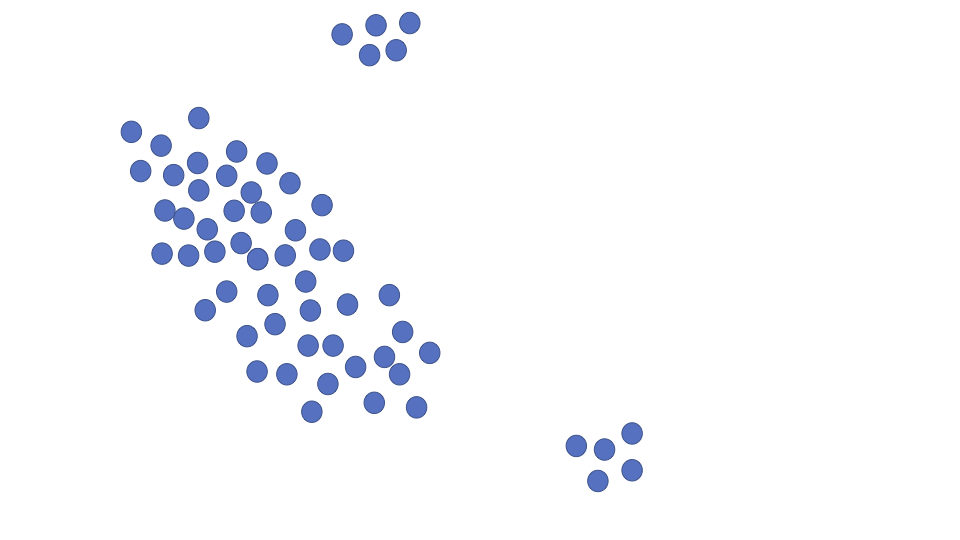

In [174]:
Image(filename = PATH + "ClusterPres-1.png", width=400, height=400)

We can see 3 well seperated clusters. Two have 5 datapoints and one has 5 * 10 = 50 datapoints. The clusters are visualised below:

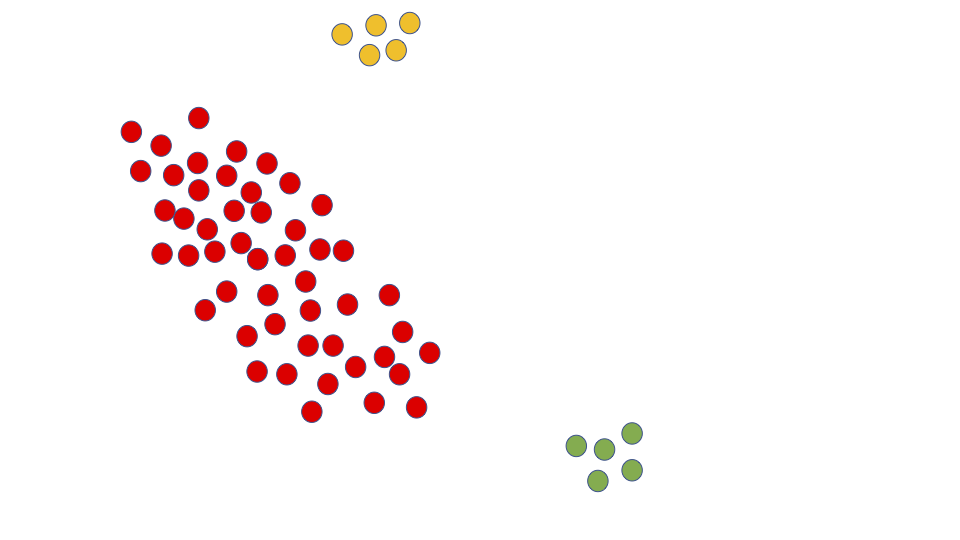

In [178]:
Image(filename = PATH + "ClusterPres-4.png", width=400, height=400)

If we were to apply llyods algorithm with random cluster initialisation, we are likely to get all 3 points in the largest cluster (or possibly 2 in the largest or 1 in one of the others, but it is not likely for 1 to be in each of the clusters). An example of this is visualised below, where the initial centres are coloured in orange:

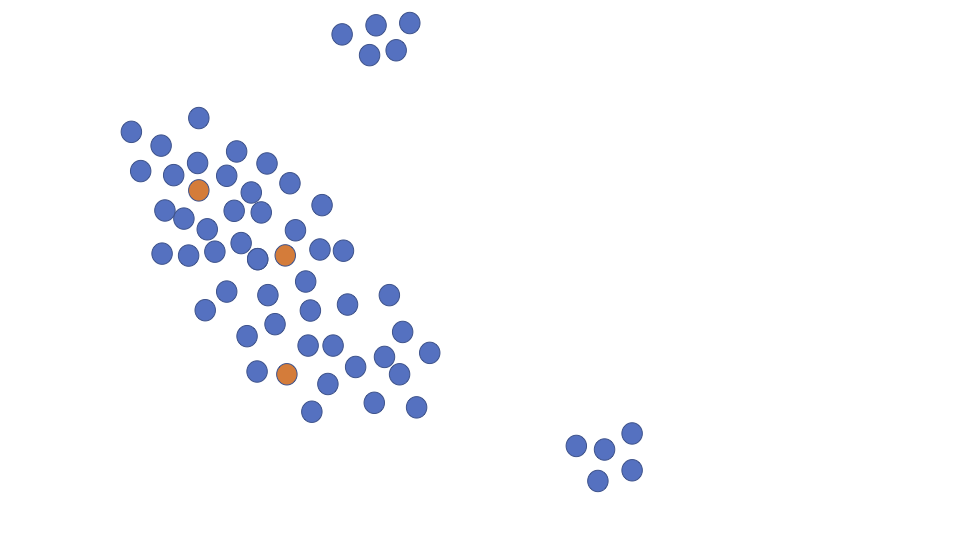

In [177]:
Image(filename = PATH + "ClusterPres-2.png", width=400, height=400)

These may lead to a seperation of the points within the largest cluster, as opposed to a correct seperation of the points from each cluster into their seperate clusters. An example of this is shown below:

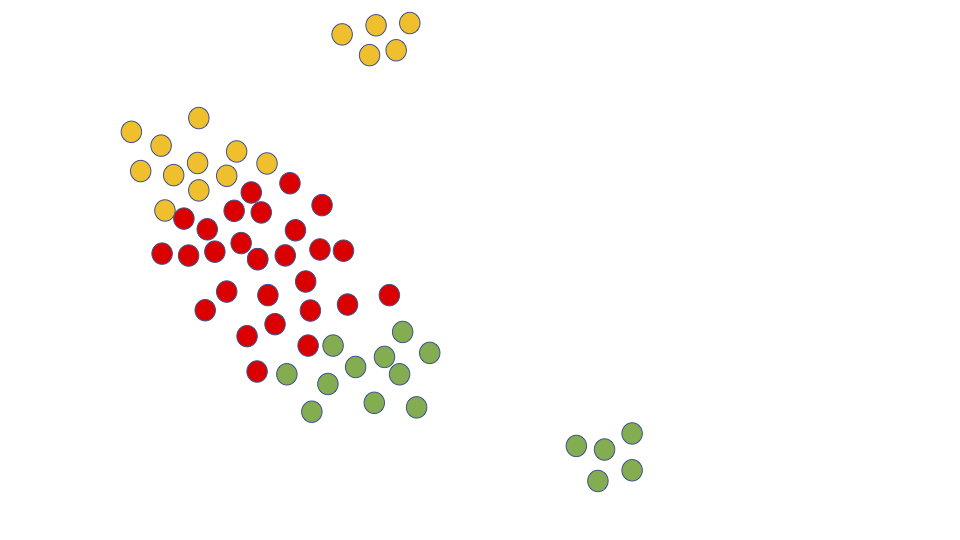

In [176]:
Image(filename = PATH + "ClusterPres-3.png", width=400, height=400)

So, as we saw above, if all 3 initial centroids are in the larger cluster this can lead to overclustering of the larger cluster (with the points in the other clusters assigned to the nearest of these clusters) as opposed to 3. This is poor and not useful clustering. 

We saw another example of this in the lecture slides:

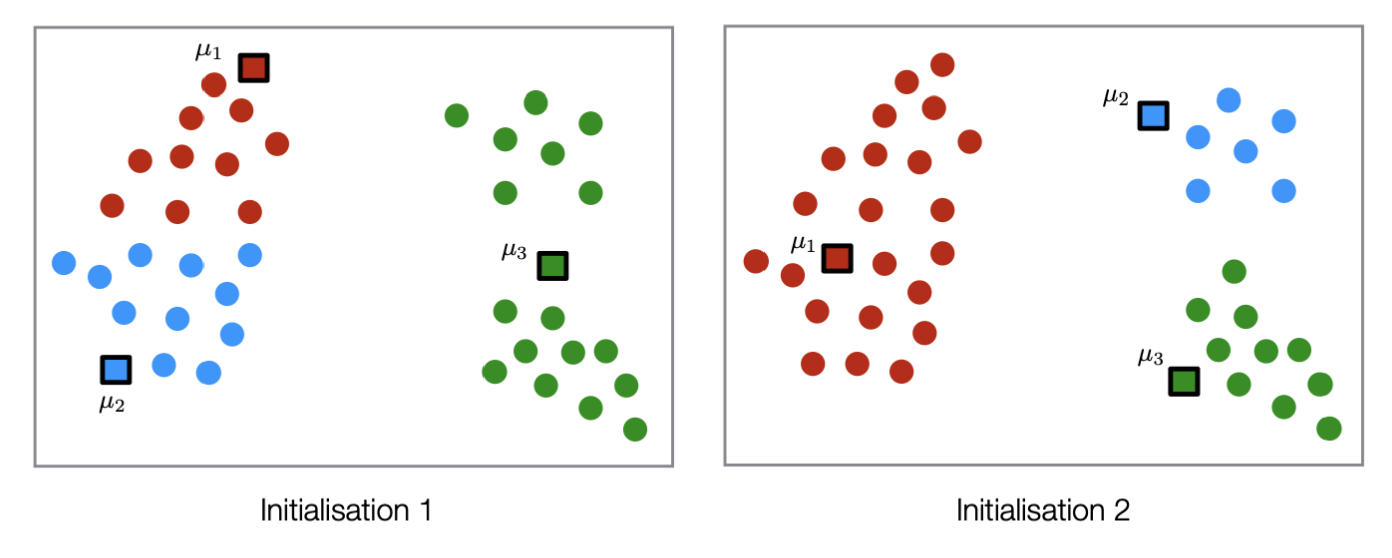

In [179]:
Image(filename = PATH + "ClusterPres-5.png", width=400, height=400)

The clustering on the left has overcluster the large cluster (left) and not seperated the two other clusters (right) into seperate clusters, due to the fact that 2 of the initial centroids were in the large cluster, and 1 was between the 2 smaller clusters. In contrast, in the second clustering on the right, there is 1 initial centroid in each of the well seperated clusters, which has lead to good, useful clustering.

So, we can see that Llyods algorithm is highly sensitive to the initial centroids, and we get different clustering depending on the initial centroids.

K-means++ is an approximation algorithm which aims to overcome this issue with the initial cluster centroids. This algorithm ensures a smarter initialization of the centroids and improves the quality of the clustering.

For k-means++ we star with an empty centroid set C, so C = { }. Say we have k datapoints. One datapoint, call it x1, is then randomly selected out of the data set and added to the centroid set C, so C = {x1} now. For the remaining k-1 datapoints, we pick each of the points and add them to C with a probability proportional to the distance from the point to the nearest centroid in C  (which on the first iteration will be the distance from the point to the point x1). So this second point, call it x2, is added to C with a probability proportional to distance(x2, x1)^2. We continue  with this process of randomly choosing a point, xn, and adding it to C with a probability proportional to to distance(xn, C)^2.

By following the above procedure for initialization, we pick up centroids that are far away from one another. This increases the chances of initially picking up centroids that lie in different clusters.  So in the case of  3 well seperated clusters where 1 cluster has 10 times more datapoints than the others,we are far more likely to choose 3 initial centres each in one of the 3 clusters when using kmeans++, as it will choose initial centres which are further apart, and due to the fact that the clusters are well seperated this is even more likely. 

__<font color='red' size=3.5>(b) Comment on the interpretability of k-nearest neighbour, decision tree, SVM, random forest and a deep neural network. For each of these supervised learning techniques, (i) how easy or difficult it is to explain the reason behind predictions to a layman, (ii) can you easily find out which training examples need to be modified to change the prediction for a particular query and (iii) can you find out the weight of the different features in your model? [10 marks]</font>__

__Decision Tree__

Decision Trees are very interpretable. We can very easily visualise our decision trees, such as the below visualisation of a decision tree generated in sklearn and plotted using the plot_tree function.

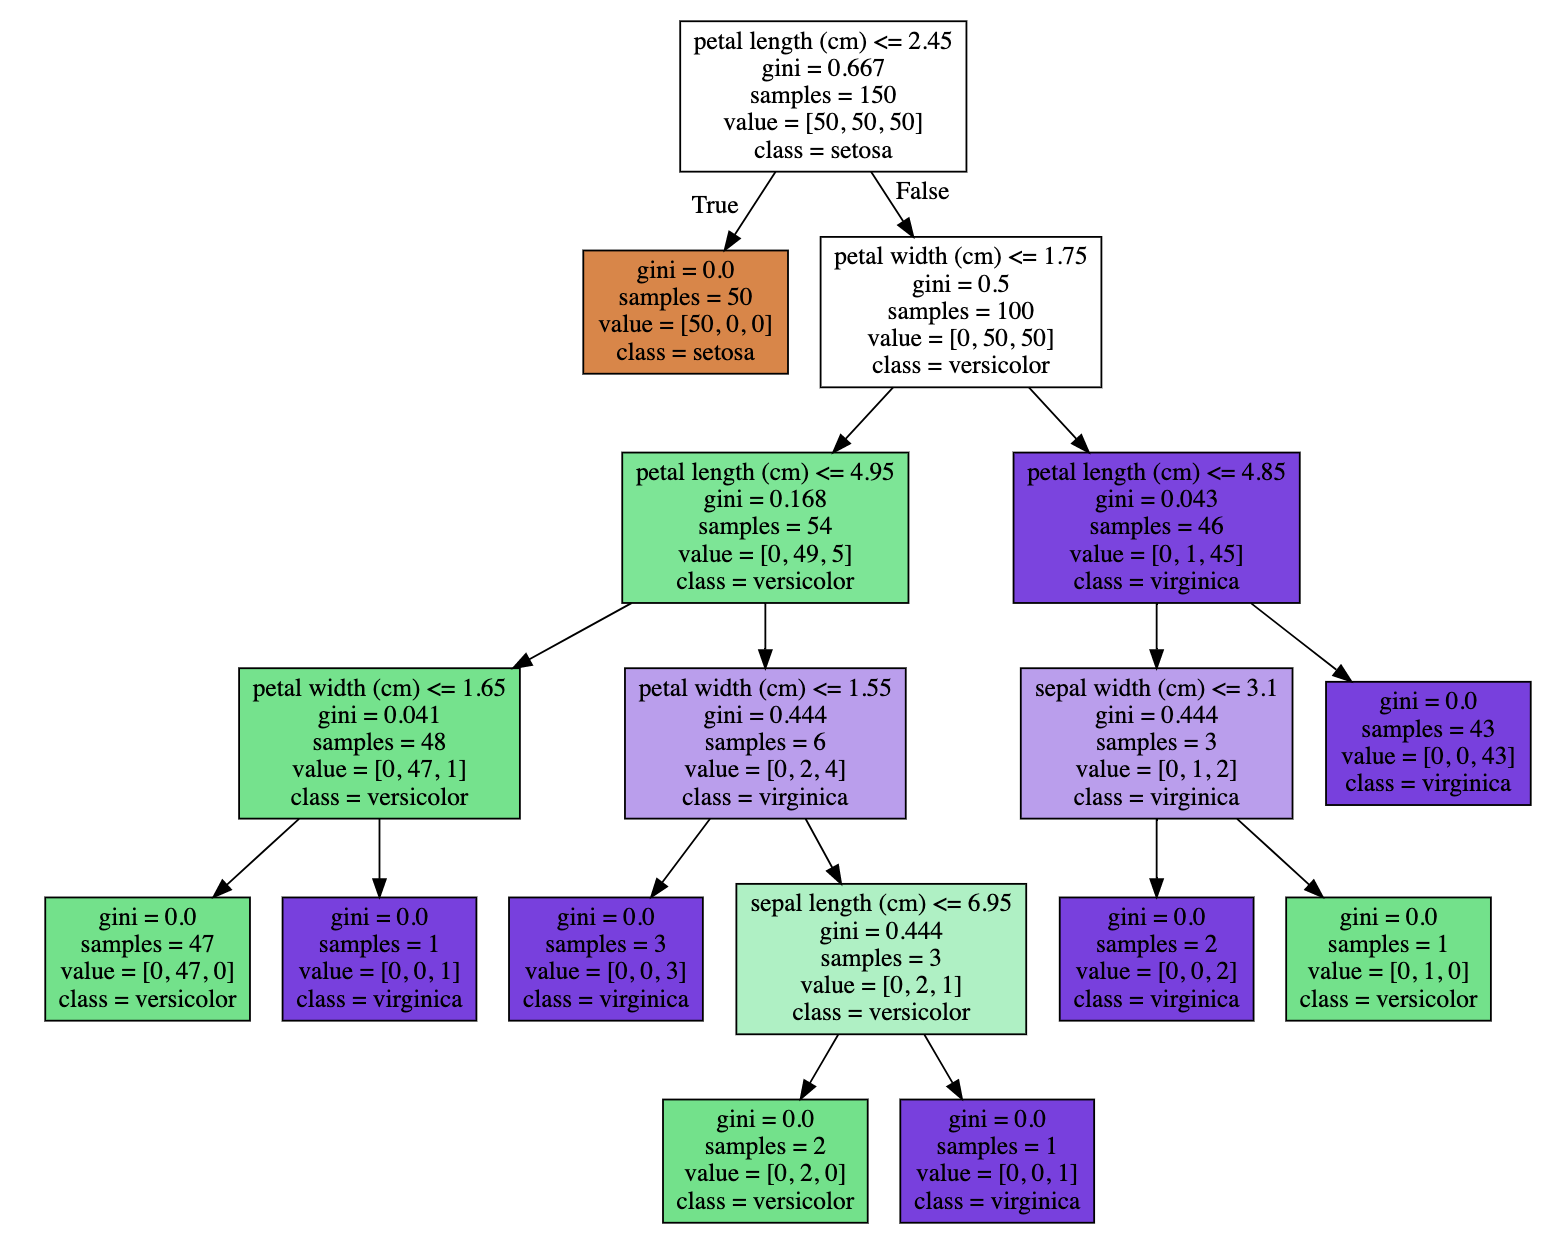

In [184]:
Image(filename = PATH + "Decision Tree.png", width=600, height=600)

Using the visualisation it is very easy to interpret the decision tree. It is easy to explain to a layman how at the root we are evaluating petal length. If the length is less than or equal to 2.45 we classify the flower as ‘Setosa’. If not, we move down the ‘False’ branch and next we are evaluating petal width. This process is very logical and easy to interpret for someone with no machine learning experience. We can also easily see which training examples need to be modified to change the prediction for a particular query if the attributes in question are close to the root. If a particular training example is classified much further down in the tree and we want to change the prediction, this would invole trainining examples related to the the same attribute values as the queried example for each of the attributes that were evaluated along the path down the tree to where the query point was classified. It is also easy to see the weight of the different features as it is based on information gain or gini index, which we can see displayed for each attribute on the tree diagram.

__SVM__

SVMs are very difficult to interpret and often considered “black boxes”. It is extremely difficult to explain to a layman. After 3 years of studying computer science it took me a long time this year to understand it, and I still don’t fully, so it would be extremely difficult to explain to someone with no machine learning background. The mathematics of the kernel trick and other aspects of SVM are very complex. For small dimensions (2 or 3) we could visualise the seperation of the classes using SVM, however as the dimensionality increases this is not so easy.

For a linear SVM (linear kernel), we can access and interpret the feature weights (in sklearn using coef_). The feature weights directly correspond to the importance of the feature within the model. Thus it is easy to understand what the model has ‘learned’. However, we cannot do this for more complex kernel functions as the features are transformed to a higher dimension. It is possible to find out the feature weights however the process is more complicated. We could fit a logistic regression model which estimates the probability of label y being class 1, given the original features, where f(x) is the SVM decision function.
We then use maximum likelihood estimation to fit the parameters of this logistic regression model, the technique is called Platt Scaling. To help us interpret the feature weights, we then simply fit the model and select a point in our dataset to evaluate it at, then perturb one feature at a time through a range of values, whilst keeping the other features fixed. We can use this to draw a graph of the sensitivity of the model to each feature. SKlearn comes with this feature built into the SVC model. You can use the clf.predict_proba(X) function to obtain the probabilities. It is also therefore difficult to find out which training examples need to be modified to change the prediction for a particular query, as we would need to work out which features have the highest weight, which examples have values of these high weight features simialr to the queried example, and then change these feature values.

__K-Nearest Neighbours (KNN)__

It is relatively easy to explain the reason behind predictions using KNN to a layman. Once you can explain what we mean by closeness of 2 points (based on mulitple features), it is easy to explain how for a new query in KNN we calculate the distance to all other datapoints, find the k nearest examples, and then use an approach such as majority voting to classify the new point based on these k nearest examples. It is very easy to know which points need to be modified to change the prediction for a particular query. We look at the k nearest points to the query and we can change the classes of these points to change the class prediction for the query. We can apply weights to the nearest neighbours of a queried point, where closer neighbours have a higher weighting. This is easy to understand and explain to a layman. Based on my understanding, feature weights are not an aspect of the standard knn algorithm, all features are given the same weighting, unless a different distance function is used. For global distance all features are used, for single distance just 1 feature is used.

__Random Forest__

Random forests are not very easily interpretable. A random forest is essentially an ensemble of decision trees, and as explained earlier decision trees themselves are easily interpretable. Random forests make predictions my combining the predictions of each of the base decision trees (using a method such as majority voting). The explanation of how this works requires an understanding of both decision trees and ensembles, so it is more difficult to explain to a layman than just a decision tree, however I think that in comparison to other methods such as SVM it is not too difficult to eplain. To explain exactly how a query is classified and understand which examples need to change to modify the prediction would be very complicated. It would involve looking at each inner decision tree seperately, finding out the classification for the query for each tree, and then the ensemble voting would also have to be taken into account, so it would get very complicated. Understanding the feature weights is not too difficult if the random forest is constructed in sklearn as wee can use the feature_importances_ property which shows the importance of each feature in the full model which we can view in a table as below:

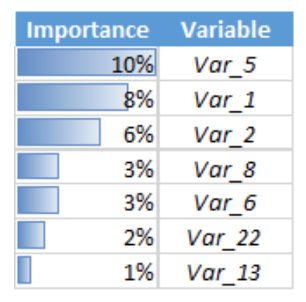

In [187]:
Image(filename = PATH + "FeatureImportance.png", width=200, height=200)

__Deep Neural Networks__

Deep neural networks (DNNs) are another very difficult model to interpret. As with SVM, the reasoning behinf NNs is difficult to explain to the layman. The concepts of perceptrons, signals, activation functions, sigmoid functions, etc. are not easy for a layman to understand, making the concept of NNs difficult to explain to those without a machine learning or mathematical background. The weights in a neural network are a measure of how strong each connection is between each neuron. So, looking at the first dense layer in your DNN you can tell how strong the connections are between the first layer’s neurons and the inputs. After the first layer you lose the one-to-many relationship and it turns into an entangled mess of many-to-many relationships. This means that a neuron in one layer may be related to some other neuron far away (i.e. neurons experience non-locality effects due to back propagation). The weights tell the story about the input but the information they have is compressed in the neurons after the application of the activation functions making it very difficult to decode. Thus is is difficult to understand the weighting of each feature, and which examples to modify to change the prediction of a particular query.

__<font color='red' size=3.5>(c) What are the relative advantages and disadvantages of agglomerative and divisive hierarchical clustering algorithms with respect to each other? What are the advantages and disadvantages of the different cluster metrics used in the agglomerative approaches? [10 marks]</font>__

Allgomerative and Divisive are two categories of hierarchial clustering.
Agglomerative clustering begins with each item assigned to its own cluster. A bottom-up strategy is applied where, at each step, the most similar pair of clusters are merged. 

In contrast, divisive clustering begins with a single cluster containing all items. A top-down strategy is applied where, at each step, a chosen cluster is split into two sub-clusters. 

Agglomerative clustering involves generating a distance matrix which is a symmetric matrix storing the distances between all pairs of items in the dataset, calculated according to some distance function (e.g. Euclidean distance).  The matrix must be preserved in the computer memory to allow for the repeated computations of the similarity between clusters, so agglomerative requires more memory than divisive (as divisive does not require such matrix).

If there are n datapoints, the time complexity of the agglomerative clustering is O(n^3) because we exhaustively scan the n x n matrix distance matrix for the lowest distance in each of N-1 iterations. This can be reduced somewhat using priority queuing, which  could allow for a complexity of O(n^2  log n), and could be reduced further to a complexity of )(n^2) using furtheroptimisation. In comparison, for divisive clustering given a fixed number of top levels, using an efficient flat algorithm like K-Means, divisive algorithms are linear in the number of patterns and clusters. Divisive clustering is more efficient if we do not generate a complete hierarchy all the way down to individual data leaves. 

Furthermore, divisive clustering is typically more accurate. Agglomerative clustering takes a bottom uop view of the data, so local decisions are made based on individual items in the beginning. In contrast, we have a top down and more holistic view of the dataset for divisive clustering. We are looking at a global picture at the beginning, taking into account the global distribution of data when making top-level partitioning decisions. Because of the fact that decisions which are made in hierarchial clustering can not be undone, poor splitting/merging at the beginning can lead to poor clustering, so for this reason we generally get better clustering with the divisive approach due to the global view when making decisions.

__Cluster Metrics__

For agglomerative clustering, we begin with each item assigned to its own cluster. A bottom-up strategy is applied where, at each step, the most similar pair of clusters are merged. The similarity between data points is based on a distance metrix (e.g. Euclidean) and the distances between each pair of points is strored in a distance matrix. So we know how to calculate the distance between two points, but how do we calculate the distance between two clusters so that we can merge the most similar pair. There are 3 such methods which we discussed in the lectures: single, complete and average linkage.

Single linkage defines the  distance between two clusters as the smallest pairwise distance between items from each cluster. In other words, the distance between the closest two points. This is visualised below:

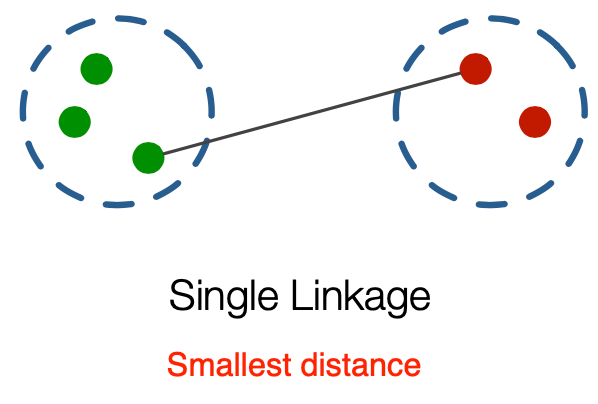

In [188]:
Image(filename = PATH + "singleLinkage.png", width=200, height=200)


It can sometimes produce clusters where observations in different clusters are closer together than observations within their own clusters. These clusters can appear spread-out, where we get a long chain of clusters that aren’t cohesive.

Complete Linkage defines cluster distance as the largest pairwise distance between items from each cluster. This is visualised below:


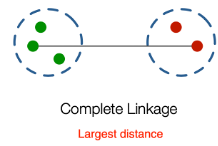

In [189]:
Image(filename = PATH + "completeLinkage.png", width=200, height=200)

Because is looks at the two furthest points in clusters it is very sensitive to outliers. This method also usually produces tighter clusters than single-linkage, but these tight clusters can end up very close together. 

Average linkage defines cluster distance as the average of all pairwise distances between items from each cluster. It is visualised below:

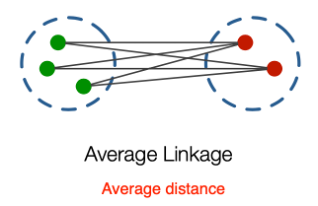

In [190]:
Image(filename = PATH + "avgLinkage.png", width=200, height=200)

Because it takes into account all points, it is less sensitive to outliers than complete linkage, but more sensitive to outliers than single linkage. It also overcomes the long chain of clusters problem associated with single linkage. Thus average linkage is a reasonable compromise.